# Deep cortical machine learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.3798767756387247 -2.881028293821042
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [15]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [16]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    g_loss = tf.reduce_mean(neg_log_prob_actions[:-1] * targetQs[1:])
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                     labels=reward*tf.ones_like(Qs_logits)))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits[:-1],
                                                                     labels=tf.reshape(tf.nn.sigmoid(targetQs[1:]),
                                                                                       shape=[-1, 1])))
    d_loss = d_lossR #+ d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [17]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [18]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [19]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [20]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [21]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [22]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [23]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
d_lossR_list, d_lossQ_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ),
)
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model2.ckpt')

Episode:0 meanR:46.0000 gloss:-0.0105 dloss:0.6879 dlossR:0.6879 dlossQ:0.6925
Episode:1 meanR:138.5000 gloss:0.0243 dloss:0.6955 dlossR:0.6955 dlossQ:0.6923
Episode:2 meanR:99.3333 gloss:0.0103 dloss:0.6993 dlossR:0.6993 dlossQ:0.6931
Episode:3 meanR:78.0000 gloss:0.0492 dloss:0.7240 dlossR:0.7240 dlossQ:0.6924
Episode:4 meanR:64.4000 gloss:0.0422 dloss:0.7186 dlossR:0.7186 dlossQ:0.6922
Episode:5 meanR:55.1667 gloss:0.0073 dloss:0.6942 dlossR:0.6942 dlossQ:0.6930
Episode:6 meanR:48.5714 gloss:-0.0253 dloss:0.6712 dlossR:0.6712 dlossQ:0.6929
Episode:7 meanR:43.7500 gloss:-0.0599 dloss:0.6476 dlossR:0.6476 dlossQ:0.6920
Episode:8 meanR:40.0000 gloss:-0.0982 dloss:0.6203 dlossR:0.6203 dlossQ:0.6898
Episode:9 meanR:36.8000 gloss:-0.1347 dloss:0.5985 dlossR:0.5985 dlossQ:0.6872
Episode:10 meanR:34.3636 gloss:-0.1867 dloss:0.5703 dlossR:0.5703 dlossQ:0.6819
Episode:11 meanR:32.1667 gloss:-0.2226 dloss:0.5528 dlossR:0.5528 dlossQ:0.6785
Episode:12 meanR:30.4615 gloss:-0.2882 dloss:0.5231 dl

Episode:105 meanR:30.8700 gloss:-1.7023 dloss:0.6261 dlossR:0.6261 dlossQ:0.2744
Episode:106 meanR:32.4800 gloss:-1.7848 dloss:0.9572 dlossR:0.9572 dlossQ:0.2528
Episode:107 meanR:32.9900 gloss:-1.7318 dloss:0.3853 dlossR:0.3853 dlossQ:0.2653
Episode:108 meanR:33.9800 gloss:-1.7852 dloss:0.6386 dlossR:0.6386 dlossQ:0.2533
Episode:109 meanR:34.4800 gloss:-1.7358 dloss:0.3701 dlossR:0.3701 dlossQ:0.2650
Episode:110 meanR:34.6800 gloss:-1.7164 dloss:0.2292 dlossR:0.2292 dlossQ:0.2704
Episode:111 meanR:34.8000 gloss:-1.7736 dloss:0.1768 dlossR:0.1768 dlossQ:0.2561
Episode:112 meanR:34.8900 gloss:-1.8613 dloss:0.1682 dlossR:0.1682 dlossQ:0.2360
Episode:113 meanR:34.8500 gloss:-1.8814 dloss:0.1575 dlossR:0.1575 dlossQ:0.2318
Episode:114 meanR:34.7000 gloss:-1.9276 dloss:0.1669 dlossR:0.1669 dlossQ:0.2216
Episode:115 meanR:34.3400 gloss:-1.9328 dloss:0.1393 dlossR:0.1393 dlossQ:0.2207
Episode:116 meanR:33.5900 gloss:-2.1017 dloss:0.1177 dlossR:0.1177 dlossQ:0.1883
Episode:117 meanR:31.3300 gl

Episode:209 meanR:47.8800 gloss:-1.9607 dloss:0.1229 dlossR:0.1229 dlossQ:0.2201
Episode:210 meanR:47.6700 gloss:-1.9431 dloss:0.1187 dlossR:0.1187 dlossQ:0.2240
Episode:211 meanR:47.6100 gloss:-1.8661 dloss:0.1468 dlossR:0.1468 dlossQ:0.2410
Episode:212 meanR:47.6300 gloss:-1.5528 dloss:0.1978 dlossR:0.1978 dlossQ:0.3193
Episode:213 meanR:47.7000 gloss:-1.7077 dloss:0.2072 dlossR:0.2072 dlossQ:0.2843
Episode:214 meanR:48.3600 gloss:-1.6612 dloss:0.4991 dlossR:0.4991 dlossQ:0.2924
Episode:215 meanR:48.8200 gloss:-1.5960 dloss:0.3767 dlossR:0.3767 dlossQ:0.3087
Episode:216 meanR:49.4700 gloss:-1.6177 dloss:0.4499 dlossR:0.4499 dlossQ:0.2994
Episode:217 meanR:49.6300 gloss:-1.5549 dloss:0.2263 dlossR:0.2263 dlossQ:0.3139
Episode:218 meanR:49.7000 gloss:-1.5685 dloss:0.1847 dlossR:0.1847 dlossQ:0.3104
Episode:219 meanR:49.8300 gloss:-1.6101 dloss:0.2143 dlossR:0.2143 dlossQ:0.2989
Episode:220 meanR:49.9800 gloss:-1.5808 dloss:0.2252 dlossR:0.2252 dlossQ:0.3069
Episode:221 meanR:49.9400 gl

Episode:321 meanR:37.9400 gloss:-1.8171 dloss:0.1362 dlossR:0.1362 dlossQ:0.2469
Episode:322 meanR:37.9300 gloss:-1.8834 dloss:0.1478 dlossR:0.1478 dlossQ:0.2314
Episode:323 meanR:37.9400 gloss:-1.9400 dloss:0.1454 dlossR:0.1454 dlossQ:0.2194
Episode:324 meanR:37.9900 gloss:-1.9716 dloss:0.1555 dlossR:0.1555 dlossQ:0.2131
Episode:325 meanR:38.0100 gloss:-2.0082 dloss:0.1322 dlossR:0.1322 dlossQ:0.2062
Episode:326 meanR:38.0100 gloss:-2.0714 dloss:0.1300 dlossR:0.1300 dlossQ:0.1940
Episode:327 meanR:38.0300 gloss:-2.0977 dloss:0.1407 dlossR:0.1407 dlossQ:0.1893
Episode:328 meanR:37.9900 gloss:-2.0926 dloss:0.1523 dlossR:0.1523 dlossQ:0.1902
Episode:329 meanR:37.9500 gloss:-2.1001 dloss:0.1347 dlossR:0.1347 dlossQ:0.1892
Episode:330 meanR:38.2900 gloss:-1.9332 dloss:0.4118 dlossR:0.4118 dlossQ:0.2283
Episode:331 meanR:39.8200 gloss:-1.8965 dloss:1.0858 dlossR:1.0858 dlossQ:0.2375
Episode:332 meanR:39.7700 gloss:-2.1225 dloss:0.2576 dlossR:0.2576 dlossQ:0.1879
Episode:333 meanR:39.7100 gl

Episode:434 meanR:28.5200 gloss:-2.3795 dloss:0.1094 dlossR:0.1094 dlossQ:0.1507
Episode:435 meanR:28.3500 gloss:-2.3963 dloss:0.1086 dlossR:0.1086 dlossQ:0.1488
Episode:436 meanR:27.9600 gloss:-2.4515 dloss:0.1085 dlossR:0.1085 dlossQ:0.1446
Episode:437 meanR:27.6500 gloss:-2.5578 dloss:0.1039 dlossR:0.1039 dlossQ:0.1212
Episode:438 meanR:27.2200 gloss:-2.5790 dloss:0.1174 dlossR:0.1174 dlossQ:0.1171
Episode:439 meanR:27.2200 gloss:-2.6764 dloss:0.1034 dlossR:0.1034 dlossQ:0.1077
Episode:440 meanR:27.2500 gloss:-2.7172 dloss:0.1178 dlossR:0.1178 dlossQ:0.1022
Episode:441 meanR:27.2400 gloss:-2.7003 dloss:0.1037 dlossR:0.1037 dlossQ:0.1064
Episode:442 meanR:27.2100 gloss:-2.7002 dloss:0.0969 dlossR:0.0969 dlossQ:0.1088
Episode:443 meanR:26.9600 gloss:-2.5048 dloss:0.1372 dlossR:0.1372 dlossQ:0.1257
Episode:444 meanR:26.5200 gloss:-2.2003 dloss:0.1693 dlossR:0.1693 dlossQ:0.1722
Episode:445 meanR:26.5800 gloss:-2.0520 dloss:0.2112 dlossR:0.2112 dlossQ:0.1990
Episode:446 meanR:27.0100 gl

Episode:538 meanR:26.3300 gloss:-1.6279 dloss:0.4976 dlossR:0.4976 dlossQ:0.2978
Episode:539 meanR:27.2100 gloss:-1.6421 dloss:0.5565 dlossR:0.5565 dlossQ:0.2944
Episode:540 meanR:27.6800 gloss:-1.6640 dloss:0.3704 dlossR:0.3704 dlossQ:0.2870
Episode:541 meanR:29.2500 gloss:-1.8625 dloss:0.9651 dlossR:0.9651 dlossQ:0.2395
Episode:542 meanR:31.1400 gloss:-1.7638 dloss:1.0856 dlossR:1.0856 dlossQ:0.2638
Episode:543 meanR:32.6900 gloss:-1.7199 dloss:0.9260 dlossR:0.9260 dlossQ:0.2743
Episode:544 meanR:34.1000 gloss:-1.6491 dloss:0.8567 dlossR:0.8567 dlossQ:0.2930
Episode:545 meanR:34.7500 gloss:-1.3939 dloss:0.4962 dlossR:0.4962 dlossQ:0.3637
Episode:546 meanR:35.1900 gloss:-1.3190 dloss:0.5468 dlossR:0.5468 dlossQ:0.3865
Episode:547 meanR:35.6100 gloss:-1.4191 dloss:0.5078 dlossR:0.5078 dlossQ:0.3575
Episode:548 meanR:36.5500 gloss:-1.3504 dloss:0.6421 dlossR:0.6421 dlossQ:0.3786
Episode:549 meanR:36.3900 gloss:-1.4846 dloss:0.2114 dlossR:0.2114 dlossQ:0.3406
Episode:550 meanR:36.6400 gl

Episode:642 meanR:51.8600 gloss:-1.6713 dloss:0.1781 dlossR:0.1781 dlossQ:0.2933
Episode:643 meanR:50.4600 gloss:-1.6132 dloss:0.2377 dlossR:0.2377 dlossQ:0.3058
Episode:644 meanR:49.2800 gloss:-1.4234 dloss:0.3013 dlossR:0.3013 dlossQ:0.3585
Episode:645 meanR:48.4600 gloss:-2.0519 dloss:0.1239 dlossR:0.1239 dlossQ:0.2093
Episode:646 meanR:47.8000 gloss:-1.4698 dloss:0.2919 dlossR:0.2919 dlossQ:0.3456
Episode:647 meanR:47.8000 gloss:-1.4130 dloss:0.5084 dlossR:0.5084 dlossQ:0.3601
Episode:648 meanR:47.5700 gloss:-1.5616 dloss:0.5881 dlossR:0.5881 dlossQ:0.3209
Episode:649 meanR:48.6900 gloss:-1.2547 dloss:0.6388 dlossR:0.6388 dlossQ:0.4079
Episode:650 meanR:49.1300 gloss:-1.4596 dloss:0.5511 dlossR:0.5511 dlossQ:0.3469
Episode:651 meanR:48.9100 gloss:-1.2545 dloss:0.4714 dlossR:0.4714 dlossQ:0.4077
Episode:652 meanR:48.7500 gloss:-1.3943 dloss:0.4140 dlossR:0.4140 dlossQ:0.3659
Episode:653 meanR:48.4600 gloss:-1.4744 dloss:0.2592 dlossR:0.2592 dlossQ:0.3452
Episode:654 meanR:52.0500 gl

Episode:746 meanR:67.7800 gloss:-1.2166 dloss:0.2335 dlossR:0.2335 dlossQ:0.4210
Episode:747 meanR:67.0400 gloss:-1.2863 dloss:0.2233 dlossR:0.2233 dlossQ:0.3989
Episode:748 meanR:66.1400 gloss:-1.2846 dloss:0.2130 dlossR:0.2130 dlossQ:0.3993
Episode:749 meanR:64.9800 gloss:-1.3024 dloss:0.2144 dlossR:0.2144 dlossQ:0.3943
Episode:750 meanR:64.1100 gloss:-1.3395 dloss:0.2025 dlossR:0.2025 dlossQ:0.3827
Episode:751 meanR:63.3700 gloss:-1.4499 dloss:0.1810 dlossR:0.1810 dlossQ:0.3502
Episode:752 meanR:62.8600 gloss:-1.4312 dloss:0.2067 dlossR:0.2067 dlossQ:0.3554
Episode:753 meanR:62.7000 gloss:-1.5639 dloss:0.1819 dlossR:0.1819 dlossQ:0.3179
Episode:754 meanR:58.8600 gloss:-1.5237 dloss:0.2024 dlossR:0.2024 dlossQ:0.3298
Episode:755 meanR:57.8700 gloss:-1.5479 dloss:0.1957 dlossR:0.1957 dlossQ:0.3229
Episode:756 meanR:56.4000 gloss:-1.5638 dloss:0.1989 dlossR:0.1989 dlossQ:0.3192
Episode:757 meanR:55.0900 gloss:-1.5604 dloss:0.2255 dlossR:0.2255 dlossQ:0.3206
Episode:758 meanR:54.9800 gl

Episode:851 meanR:61.8900 gloss:-1.4912 dloss:0.2139 dlossR:0.2139 dlossQ:0.3407
Episode:852 meanR:61.9600 gloss:-1.3981 dloss:0.2388 dlossR:0.2388 dlossQ:0.3680
Episode:853 meanR:62.2400 gloss:-1.1775 dloss:0.3238 dlossR:0.3238 dlossQ:0.4335
Episode:854 meanR:64.5300 gloss:-1.0637 dloss:0.9825 dlossR:0.9825 dlossQ:0.4639
Episode:855 meanR:65.6000 gloss:-1.2876 dloss:0.6175 dlossR:0.6175 dlossQ:0.3973
Episode:856 meanR:65.9400 gloss:-1.3314 dloss:0.3487 dlossR:0.3487 dlossQ:0.3842
Episode:857 meanR:66.0800 gloss:-1.3924 dloss:0.2922 dlossR:0.2922 dlossQ:0.3671
Episode:858 meanR:66.1000 gloss:-1.5268 dloss:0.2595 dlossR:0.2595 dlossQ:0.3317
Episode:859 meanR:65.4700 gloss:-1.5764 dloss:0.1927 dlossR:0.1927 dlossQ:0.3162
Episode:860 meanR:64.5300 gloss:-1.6838 dloss:0.1767 dlossR:0.1767 dlossQ:0.2885
Episode:861 meanR:64.1100 gloss:-1.7951 dloss:0.1557 dlossR:0.1557 dlossQ:0.2602
Episode:862 meanR:64.2200 gloss:-1.6907 dloss:0.1859 dlossR:0.1859 dlossQ:0.2871
Episode:863 meanR:64.5800 gl

Episode:955 meanR:74.4200 gloss:-1.3096 dloss:0.2145 dlossR:0.2145 dlossQ:0.3959
Episode:956 meanR:74.1300 gloss:-1.3126 dloss:0.2443 dlossR:0.2443 dlossQ:0.3957
Episode:957 meanR:74.3600 gloss:-1.0952 dloss:0.3915 dlossR:0.3915 dlossQ:0.4605
Episode:958 meanR:75.1900 gloss:-0.9739 dloss:0.5495 dlossR:0.5495 dlossQ:0.4980
Episode:959 meanR:75.9500 gloss:-0.9864 dloss:0.4915 dlossR:0.4915 dlossQ:0.4940
Episode:960 meanR:76.3100 gloss:-1.1095 dloss:0.3581 dlossR:0.3581 dlossQ:0.4542
Episode:961 meanR:76.6100 gloss:-1.1723 dloss:0.3233 dlossR:0.3233 dlossQ:0.4352
Episode:962 meanR:76.7000 gloss:-1.2258 dloss:0.2637 dlossR:0.2637 dlossQ:0.4189
Episode:963 meanR:76.5500 gloss:-1.3035 dloss:0.2658 dlossR:0.2658 dlossQ:0.3963
Episode:964 meanR:76.4400 gloss:-1.3268 dloss:0.2561 dlossR:0.2561 dlossQ:0.3894
Episode:965 meanR:76.5300 gloss:-1.3231 dloss:0.2373 dlossR:0.2373 dlossQ:0.3892
Episode:966 meanR:76.6700 gloss:-1.3668 dloss:0.2450 dlossR:0.2450 dlossQ:0.3761
Episode:967 meanR:76.7900 gl

Episode:1056 meanR:68.7700 gloss:-1.3877 dloss:0.2739 dlossR:0.2739 dlossQ:0.3729
Episode:1057 meanR:68.3600 gloss:-1.6535 dloss:0.2044 dlossR:0.2044 dlossQ:0.3001
Episode:1058 meanR:67.5000 gloss:-1.3709 dloss:0.2570 dlossR:0.2570 dlossQ:0.3767
Episode:1059 meanR:67.1000 gloss:-1.4395 dloss:0.3559 dlossR:0.3559 dlossQ:0.3567
Episode:1060 meanR:67.6600 gloss:-1.4800 dloss:0.5870 dlossR:0.5870 dlossQ:0.3460
Episode:1061 meanR:68.0700 gloss:-1.4015 dloss:0.4800 dlossR:0.4800 dlossQ:0.3701
Episode:1062 meanR:68.1500 gloss:-1.5275 dloss:0.2887 dlossR:0.2887 dlossQ:0.3494
Episode:1063 meanR:68.3500 gloss:-1.4538 dloss:0.3458 dlossR:0.3458 dlossQ:0.3589
Episode:1064 meanR:68.1900 gloss:-2.2420 dloss:0.1429 dlossR:0.1429 dlossQ:0.1804
Episode:1065 meanR:68.0400 gloss:-2.7274 dloss:0.1242 dlossR:0.1242 dlossQ:0.1398
Episode:1066 meanR:68.0400 gloss:-1.5647 dloss:0.2356 dlossR:0.2356 dlossQ:0.3267
Episode:1067 meanR:68.8500 gloss:-1.3052 dloss:0.5545 dlossR:0.5545 dlossQ:0.3940
Episode:1068 mea

Episode:1160 meanR:122.1800 gloss:-0.4766 dloss:0.5885 dlossR:0.5885 dlossQ:0.6375
Episode:1161 meanR:123.3500 gloss:-0.4936 dloss:0.6940 dlossR:0.6940 dlossQ:0.6342
Episode:1162 meanR:127.9800 gloss:-0.3960 dloss:1.0261 dlossR:1.0261 dlossQ:0.6568
Episode:1163 meanR:130.9700 gloss:-0.6490 dloss:0.9972 dlossR:0.9972 dlossQ:0.5986
Episode:1164 meanR:135.1100 gloss:-0.5295 dloss:1.0574 dlossR:1.0574 dlossQ:0.6190
Episode:1165 meanR:136.9600 gloss:-0.5354 dloss:0.7156 dlossR:0.7156 dlossQ:0.6114
Episode:1166 meanR:136.8300 gloss:-0.6857 dloss:0.3573 dlossR:0.3573 dlossQ:0.5842
Episode:1167 meanR:135.8500 gloss:-0.7315 dloss:0.3424 dlossR:0.3424 dlossQ:0.5703
Episode:1168 meanR:135.0300 gloss:-0.9098 dloss:0.2954 dlossR:0.2954 dlossQ:0.5147
Episode:1169 meanR:134.9700 gloss:-0.9586 dloss:0.2861 dlossR:0.2861 dlossQ:0.4999
Episode:1170 meanR:135.2200 gloss:-0.8758 dloss:0.3748 dlossR:0.3748 dlossQ:0.5348
Episode:1171 meanR:136.2300 gloss:-0.5423 dloss:0.5969 dlossR:0.5969 dlossQ:0.6090
Epis

Episode:1259 meanR:107.0400 gloss:-1.6705 dloss:0.2016 dlossR:0.2016 dlossQ:0.3073
Episode:1260 meanR:105.8900 gloss:-1.8838 dloss:0.1585 dlossR:0.1585 dlossQ:0.2540
Episode:1261 meanR:104.0000 gloss:-1.8971 dloss:0.1647 dlossR:0.1647 dlossQ:0.2525
Episode:1262 meanR:99.1800 gloss:-1.8333 dloss:0.1836 dlossR:0.1836 dlossQ:0.2656
Episode:1263 meanR:95.8100 gloss:-1.9154 dloss:0.1589 dlossR:0.1589 dlossQ:0.2460
Episode:1264 meanR:91.8300 gloss:-1.4547 dloss:0.2763 dlossR:0.2763 dlossQ:0.3815
Episode:1265 meanR:90.7300 gloss:-1.1145 dloss:0.4727 dlossR:0.4727 dlossQ:0.4661
Episode:1266 meanR:91.2300 gloss:-1.0851 dloss:0.4044 dlossR:0.4044 dlossQ:0.4765
Episode:1267 meanR:91.4600 gloss:-1.0856 dloss:0.3157 dlossR:0.3157 dlossQ:0.4717
Episode:1268 meanR:91.7800 gloss:-1.0516 dloss:0.3406 dlossR:0.3406 dlossQ:0.4831
Episode:1269 meanR:91.9300 gloss:-1.1499 dloss:0.2717 dlossR:0.2717 dlossQ:0.4496
Episode:1270 meanR:91.7800 gloss:-1.1591 dloss:0.2757 dlossR:0.2757 dlossQ:0.4463
Episode:1271 

Episode:1360 meanR:72.1900 gloss:-1.8531 dloss:0.1633 dlossR:0.1633 dlossQ:0.2606
Episode:1361 meanR:72.5300 gloss:-1.1995 dloss:0.3534 dlossR:0.3534 dlossQ:0.4413
Episode:1362 meanR:77.3500 gloss:-1.0170 dloss:1.6787 dlossR:1.6787 dlossQ:0.4878
Episode:1363 meanR:78.9900 gloss:-0.9724 dloss:0.7207 dlossR:0.7207 dlossQ:0.4993
Episode:1364 meanR:80.1200 gloss:-0.9723 dloss:0.6226 dlossR:0.6226 dlossQ:0.4994
Episode:1365 meanR:79.8000 gloss:-1.0521 dloss:0.3617 dlossR:0.3617 dlossQ:0.4758
Episode:1366 meanR:79.5000 gloss:-1.1445 dloss:0.3003 dlossR:0.3003 dlossQ:0.4506
Episode:1367 meanR:79.4300 gloss:-1.2077 dloss:0.2636 dlossR:0.2636 dlossQ:0.4308
Episode:1368 meanR:79.2800 gloss:-1.1816 dloss:0.2702 dlossR:0.2702 dlossQ:0.4402
Episode:1369 meanR:79.3200 gloss:-1.1755 dloss:0.2727 dlossR:0.2727 dlossQ:0.4396
Episode:1370 meanR:79.5200 gloss:-1.1030 dloss:0.3423 dlossR:0.3423 dlossQ:0.4636
Episode:1371 meanR:79.9500 gloss:-1.0012 dloss:0.4529 dlossR:0.4529 dlossQ:0.4900
Episode:1372 mea

Episode:1466 meanR:99.4300 gloss:-1.0524 dloss:0.2765 dlossR:0.2765 dlossQ:0.4773
Episode:1467 meanR:99.6500 gloss:-1.1088 dloss:0.3471 dlossR:0.3471 dlossQ:0.4555
Episode:1468 meanR:99.9400 gloss:-1.1542 dloss:0.3724 dlossR:0.3724 dlossQ:0.4458
Episode:1469 meanR:100.1300 gloss:-1.1567 dloss:0.3392 dlossR:0.3392 dlossQ:0.4403
Episode:1470 meanR:99.8400 gloss:-1.3264 dloss:0.2230 dlossR:0.2230 dlossQ:0.3926
Episode:1471 meanR:99.2000 gloss:-1.2721 dloss:0.2351 dlossR:0.2351 dlossQ:0.4094
Episode:1472 meanR:97.9500 gloss:-1.4617 dloss:0.2039 dlossR:0.2039 dlossQ:0.3551
Episode:1473 meanR:97.2100 gloss:-1.3984 dloss:0.2367 dlossR:0.2367 dlossQ:0.3684
Episode:1474 meanR:95.8000 gloss:-1.3497 dloss:0.2445 dlossR:0.2445 dlossQ:0.3861
Episode:1475 meanR:94.7100 gloss:-1.3504 dloss:0.2451 dlossR:0.2451 dlossQ:0.4035
Episode:1476 meanR:94.0200 gloss:-1.2597 dloss:0.2841 dlossR:0.2841 dlossQ:0.4240
Episode:1477 meanR:96.2400 gloss:-0.9276 dloss:0.9448 dlossR:0.9448 dlossQ:0.5178
Episode:1478 me

Episode:1572 meanR:76.8700 gloss:-1.3157 dloss:0.4152 dlossR:0.4152 dlossQ:0.4001
Episode:1573 meanR:78.6900 gloss:-1.4357 dloss:0.9906 dlossR:0.9906 dlossQ:0.3697
Episode:1574 meanR:79.1700 gloss:-1.8994 dloss:0.4820 dlossR:0.4820 dlossQ:0.2600
Episode:1575 meanR:79.0800 gloss:-2.8828 dloss:0.1327 dlossR:0.1327 dlossQ:0.1202
Episode:1576 meanR:79.1800 gloss:-2.0606 dloss:0.2795 dlossR:0.2795 dlossQ:0.2150
Episode:1577 meanR:76.7100 gloss:-2.3164 dloss:0.1570 dlossR:0.1570 dlossQ:0.1740
Episode:1578 meanR:76.7800 gloss:-2.1436 dloss:0.2093 dlossR:0.2093 dlossQ:0.2075
Episode:1579 meanR:76.6800 gloss:-2.5413 dloss:0.1344 dlossR:0.1344 dlossQ:0.1455
Episode:1580 meanR:76.6500 gloss:-3.0565 dloss:0.1200 dlossR:0.1200 dlossQ:0.1170
Episode:1581 meanR:75.1900 gloss:-2.4847 dloss:0.1673 dlossR:0.1673 dlossQ:0.1681
Episode:1582 meanR:74.4600 gloss:-2.7885 dloss:0.1351 dlossR:0.1351 dlossQ:0.1215
Episode:1583 meanR:74.5000 gloss:-2.6034 dloss:0.1444 dlossR:0.1444 dlossQ:0.1353
Episode:1584 mea

Episode:1672 meanR:77.6300 gloss:-0.9305 dloss:0.7849 dlossR:0.7849 dlossQ:0.5251
Episode:1673 meanR:76.7000 gloss:-1.2568 dloss:0.5986 dlossR:0.5986 dlossQ:0.4471
Episode:1674 meanR:76.2200 gloss:-2.0029 dloss:0.2764 dlossR:0.2764 dlossQ:0.3327
Episode:1675 meanR:76.6500 gloss:-1.2996 dloss:0.3554 dlossR:0.3554 dlossQ:0.4020
Episode:1676 meanR:76.4100 gloss:-1.8417 dloss:0.1524 dlossR:0.1524 dlossQ:0.2541
Episode:1677 meanR:76.4000 gloss:-1.8182 dloss:0.1631 dlossR:0.1631 dlossQ:0.2597
Episode:1678 meanR:76.2900 gloss:-1.9067 dloss:0.1486 dlossR:0.1486 dlossQ:0.2395
Episode:1679 meanR:76.3200 gloss:-1.9225 dloss:0.1603 dlossR:0.1603 dlossQ:0.2394
Episode:1680 meanR:76.3700 gloss:-1.9434 dloss:0.1538 dlossR:0.1538 dlossQ:0.2340
Episode:1681 meanR:76.3600 gloss:-1.9600 dloss:0.1582 dlossR:0.1582 dlossQ:0.2317
Episode:1682 meanR:76.9100 gloss:-1.3002 dloss:0.4056 dlossR:0.4056 dlossQ:0.4030
Episode:1683 meanR:77.9300 gloss:-1.0673 dloss:0.5619 dlossR:0.5619 dlossQ:0.4780
Episode:1684 mea

Episode:1773 meanR:159.7500 gloss:-0.2287 dloss:0.6159 dlossR:0.6159 dlossQ:0.6788
Episode:1774 meanR:160.8400 gloss:-0.2300 dloss:0.6336 dlossR:0.6336 dlossQ:0.6779
Episode:1775 meanR:161.4900 gloss:-0.2787 dloss:0.6118 dlossR:0.6118 dlossQ:0.6724
Episode:1776 meanR:162.3300 gloss:-0.3185 dloss:0.5832 dlossR:0.5832 dlossQ:0.6665
Episode:1777 meanR:163.2000 gloss:-0.3243 dloss:0.5866 dlossR:0.5866 dlossQ:0.6650
Episode:1778 meanR:164.5200 gloss:-0.2885 dloss:0.6333 dlossR:0.6333 dlossQ:0.6689
Episode:1779 meanR:165.2300 gloss:-0.3922 dloss:0.5523 dlossR:0.5523 dlossQ:0.6536
Episode:1780 meanR:166.2600 gloss:-0.3942 dloss:0.5875 dlossR:0.5875 dlossQ:0.6525
Episode:1781 meanR:167.0100 gloss:-0.4598 dloss:0.5415 dlossR:0.5415 dlossQ:0.6395
Episode:1782 meanR:167.6000 gloss:-0.4073 dloss:0.6000 dlossR:0.6000 dlossQ:0.6467
Episode:1783 meanR:167.8900 gloss:-0.4329 dloss:0.6215 dlossR:0.6215 dlossQ:0.6415
Episode:1784 meanR:168.2300 gloss:-0.4674 dloss:0.5757 dlossR:0.5757 dlossQ:0.6360
Epis

Episode:1875 meanR:122.5700 gloss:-0.9232 dloss:0.5618 dlossR:0.5618 dlossQ:0.5225
Episode:1876 meanR:123.6000 gloss:-0.9767 dloss:0.8040 dlossR:0.8040 dlossQ:0.5058
Episode:1877 meanR:124.2600 gloss:-0.8058 dloss:0.6695 dlossR:0.6695 dlossQ:0.5503
Episode:1878 meanR:124.4400 gloss:-0.8873 dloss:0.6700 dlossR:0.6700 dlossQ:0.5267
Episode:1879 meanR:124.5300 gloss:-0.9487 dloss:0.4949 dlossR:0.4949 dlossQ:0.5076
Episode:1880 meanR:123.7300 gloss:-1.3303 dloss:0.3154 dlossR:0.3154 dlossQ:0.4096
Episode:1881 meanR:123.5100 gloss:-1.4985 dloss:0.4129 dlossR:0.4129 dlossQ:0.3428
Episode:1882 meanR:122.7600 gloss:-1.3586 dloss:0.3615 dlossR:0.3615 dlossQ:0.3982
Episode:1883 meanR:122.2500 gloss:-1.2239 dloss:0.5073 dlossR:0.5073 dlossQ:0.4250
Episode:1884 meanR:121.2100 gloss:-2.2396 dloss:0.1552 dlossR:0.1552 dlossQ:0.2094
Episode:1885 meanR:120.7800 gloss:-0.8295 dloss:0.5184 dlossR:0.5184 dlossQ:0.5446
Episode:1886 meanR:120.3100 gloss:-0.9118 dloss:0.5096 dlossR:0.5096 dlossQ:0.5245
Epis

Episode:1979 meanR:69.3600 gloss:-1.5741 dloss:0.3739 dlossR:0.3739 dlossQ:0.3254
Episode:1980 meanR:69.2800 gloss:-1.6848 dloss:0.2414 dlossR:0.2414 dlossQ:0.2985
Episode:1981 meanR:68.7700 gloss:-1.8356 dloss:0.1780 dlossR:0.1780 dlossQ:0.2663
Episode:1982 meanR:68.4800 gloss:-1.7671 dloss:0.2155 dlossR:0.2155 dlossQ:0.2907
Episode:1983 meanR:67.6500 gloss:-2.1338 dloss:0.1527 dlossR:0.1527 dlossQ:0.2239
Episode:1984 meanR:67.6600 gloss:-2.1412 dloss:0.1437 dlossR:0.1437 dlossQ:0.2063
Episode:1985 meanR:66.7600 gloss:-2.2560 dloss:0.1318 dlossR:0.1318 dlossQ:0.1895
Episode:1986 meanR:66.1400 gloss:-1.6326 dloss:0.2683 dlossR:0.2683 dlossQ:0.3140
Episode:1987 meanR:66.1300 gloss:-2.1936 dloss:0.1343 dlossR:0.1343 dlossQ:0.2082
Episode:1988 meanR:65.2900 gloss:-1.9286 dloss:0.1533 dlossR:0.1533 dlossQ:0.2405
Episode:1989 meanR:62.6900 gloss:-1.6207 dloss:0.2036 dlossR:0.2036 dlossQ:0.3115
Episode:1990 meanR:58.0500 gloss:-1.4016 dloss:0.2822 dlossR:0.2822 dlossQ:0.3748
Episode:1991 mea

Episode:2081 meanR:59.5700 gloss:-1.1795 dloss:0.4973 dlossR:0.4973 dlossQ:0.4378
Episode:2082 meanR:61.1300 gloss:-0.8321 dloss:0.7047 dlossR:0.7047 dlossQ:0.5387
Episode:2083 meanR:62.9100 gloss:-0.8920 dloss:0.7482 dlossR:0.7482 dlossQ:0.5187
Episode:2084 meanR:63.8200 gloss:-1.4147 dloss:0.5457 dlossR:0.5457 dlossQ:0.3620
Episode:2085 meanR:64.1900 gloss:-1.5597 dloss:0.3252 dlossR:0.3252 dlossQ:0.3347
Episode:2086 meanR:64.1600 gloss:-1.6870 dloss:0.2449 dlossR:0.2449 dlossQ:0.2971
Episode:2087 meanR:64.2400 gloss:-2.0256 dloss:0.1617 dlossR:0.1617 dlossQ:0.2159
Episode:2088 meanR:64.3100 gloss:-1.9476 dloss:0.1815 dlossR:0.1815 dlossQ:0.2327
Episode:2089 meanR:64.2500 gloss:-2.1258 dloss:0.1494 dlossR:0.1494 dlossQ:0.1950
Episode:2090 meanR:64.0600 gloss:-2.0517 dloss:0.1662 dlossR:0.1662 dlossQ:0.2157
Episode:2091 meanR:63.7600 gloss:-2.1051 dloss:0.1592 dlossR:0.1592 dlossQ:0.2051
Episode:2092 meanR:63.4700 gloss:-1.6286 dloss:0.4077 dlossR:0.4077 dlossQ:0.3119
Episode:2093 mea

Episode:2183 meanR:63.9300 gloss:-1.1399 dloss:0.3815 dlossR:0.3815 dlossQ:0.4446
Episode:2184 meanR:63.3800 gloss:-1.2672 dloss:0.3266 dlossR:0.3266 dlossQ:0.4054
Episode:2185 meanR:63.2600 gloss:-1.3954 dloss:0.2720 dlossR:0.2720 dlossQ:0.3690
Episode:2186 meanR:63.3300 gloss:-1.3185 dloss:0.2937 dlossR:0.2937 dlossQ:0.3950
Episode:2187 meanR:63.5400 gloss:-1.2584 dloss:0.3014 dlossR:0.3014 dlossQ:0.4148
Episode:2188 meanR:63.5700 gloss:-1.5050 dloss:0.2171 dlossR:0.2171 dlossQ:0.3381
Episode:2189 meanR:63.6000 gloss:-1.5807 dloss:0.1907 dlossR:0.1907 dlossQ:0.3169
Episode:2190 meanR:63.6000 gloss:-1.6110 dloss:0.1836 dlossR:0.1836 dlossQ:0.3080
Episode:2191 meanR:63.6300 gloss:-1.5516 dloss:0.1973 dlossR:0.1973 dlossQ:0.3247
Episode:2192 meanR:63.1800 gloss:-1.4358 dloss:0.2122 dlossR:0.2122 dlossQ:0.3611
Episode:2193 meanR:62.4000 gloss:-1.7809 dloss:0.1644 dlossR:0.1644 dlossQ:0.2668
Episode:2194 meanR:61.9600 gloss:-1.7057 dloss:0.1788 dlossR:0.1788 dlossQ:0.2868
Episode:2195 mea

Episode:2286 meanR:104.9200 gloss:-1.0628 dloss:0.3213 dlossR:0.3213 dlossQ:0.4765
Episode:2287 meanR:105.2600 gloss:-0.7174 dloss:0.4567 dlossR:0.4567 dlossQ:0.5771
Episode:2288 meanR:106.6900 gloss:-0.4736 dloss:0.6483 dlossR:0.6483 dlossQ:0.6311
Episode:2289 meanR:109.3600 gloss:-0.3977 dloss:0.7911 dlossR:0.7911 dlossQ:0.6417
Episode:2290 meanR:111.4100 gloss:-0.3409 dloss:0.7067 dlossR:0.7067 dlossQ:0.6559
Episode:2291 meanR:114.8100 gloss:-0.3289 dloss:0.8333 dlossR:0.8333 dlossQ:0.6608
Episode:2292 meanR:117.9600 gloss:-0.6864 dloss:0.9840 dlossR:0.9840 dlossQ:0.5857
Episode:2293 meanR:122.3900 gloss:-0.7052 dloss:1.2443 dlossR:1.2443 dlossQ:0.5801
Episode:2294 meanR:124.8700 gloss:-0.7010 dloss:0.8509 dlossR:0.8509 dlossQ:0.5819
Episode:2295 meanR:126.3800 gloss:-0.6503 dloss:0.6676 dlossR:0.6676 dlossQ:0.5957
Episode:2296 meanR:127.6300 gloss:-0.6394 dloss:0.6404 dlossR:0.6404 dlossQ:0.5988
Episode:2297 meanR:127.4400 gloss:-0.6197 dloss:0.6495 dlossR:0.6495 dlossQ:0.6019
Epis

Episode:2386 meanR:176.2800 gloss:-0.0814 dloss:0.6800 dlossR:0.6800 dlossQ:0.6854
Episode:2387 meanR:176.3800 gloss:0.0010 dloss:0.6970 dlossR:0.6970 dlossQ:0.6906
Episode:2388 meanR:175.1800 gloss:-0.2184 dloss:0.5919 dlossR:0.5919 dlossQ:0.6705
Episode:2389 meanR:172.9100 gloss:-0.5224 dloss:0.4803 dlossR:0.4803 dlossQ:0.6269
Episode:2390 meanR:170.7900 gloss:-1.2592 dloss:0.2466 dlossR:0.2466 dlossQ:0.4154
Episode:2391 meanR:167.5300 gloss:-0.6872 dloss:0.3959 dlossR:0.3959 dlossQ:0.5841
Episode:2392 meanR:164.5100 gloss:-0.7459 dloss:0.3787 dlossR:0.3787 dlossQ:0.5674
Episode:2393 meanR:160.0900 gloss:-1.0257 dloss:0.2996 dlossR:0.2996 dlossQ:0.4816
Episode:2394 meanR:157.5300 gloss:-1.5283 dloss:0.2239 dlossR:0.2239 dlossQ:0.3561
Episode:2395 meanR:157.5800 gloss:-0.2101 dloss:0.6734 dlossR:0.6734 dlossQ:0.6758
Episode:2396 meanR:156.0700 gloss:-0.8838 dloss:0.3148 dlossR:0.3148 dlossQ:0.5243
Episode:2397 meanR:154.4800 gloss:-1.2004 dloss:0.2397 dlossR:0.2397 dlossQ:0.4314
Episo

Episode:2488 meanR:96.3600 gloss:-0.4594 dloss:0.7118 dlossR:0.7118 dlossQ:0.6409
Episode:2489 meanR:97.0100 gloss:-0.5230 dloss:0.5773 dlossR:0.5773 dlossQ:0.6268
Episode:2490 meanR:97.9900 gloss:-0.6373 dloss:0.5420 dlossR:0.5420 dlossQ:0.5990
Episode:2491 meanR:98.6000 gloss:-0.6910 dloss:0.5085 dlossR:0.5085 dlossQ:0.5858
Episode:2492 meanR:98.7600 gloss:-0.9417 dloss:0.3686 dlossR:0.3686 dlossQ:0.5103
Episode:2493 meanR:99.0800 gloss:-1.1032 dloss:0.3455 dlossR:0.3455 dlossQ:0.4622
Episode:2494 meanR:99.4100 gloss:-1.1897 dloss:0.3199 dlossR:0.3199 dlossQ:0.4370
Episode:2495 meanR:97.9600 gloss:-1.2112 dloss:0.3105 dlossR:0.3105 dlossQ:0.4346
Episode:2496 meanR:97.9800 gloss:-1.5931 dloss:0.1839 dlossR:0.1839 dlossQ:0.3160
Episode:2497 meanR:98.1100 gloss:-1.5072 dloss:0.2219 dlossR:0.2219 dlossQ:0.3462
Episode:2498 meanR:94.1500 gloss:-1.7437 dloss:0.1697 dlossR:0.1697 dlossQ:0.2827
Episode:2499 meanR:91.8900 gloss:-1.7375 dloss:0.1866 dlossR:0.1866 dlossQ:0.2875
Episode:2500 mea

Episode:2589 meanR:90.2100 gloss:-0.6704 dloss:0.6233 dlossR:0.6233 dlossQ:0.5911
Episode:2590 meanR:93.3900 gloss:-0.7908 dloss:1.2576 dlossR:1.2576 dlossQ:0.5572
Episode:2591 meanR:93.9600 gloss:-0.5270 dloss:0.6238 dlossR:0.6238 dlossQ:0.6274
Episode:2592 meanR:94.7800 gloss:-0.8902 dloss:0.6000 dlossR:0.6000 dlossQ:0.5266
Episode:2593 meanR:95.3900 gloss:-0.8907 dloss:0.5308 dlossR:0.5308 dlossQ:0.5268
Episode:2594 meanR:95.7800 gloss:-0.9969 dloss:0.4637 dlossR:0.4637 dlossQ:0.4933
Episode:2595 meanR:95.8700 gloss:-1.2872 dloss:0.3260 dlossR:0.3260 dlossQ:0.4014
Episode:2596 meanR:95.8100 gloss:-2.0740 dloss:0.1490 dlossR:0.1490 dlossQ:0.2332
Episode:2597 meanR:96.7200 gloss:-0.7992 dloss:0.5487 dlossR:0.5487 dlossQ:0.5529
Episode:2598 meanR:97.9300 gloss:-0.8612 dloss:0.5961 dlossR:0.5961 dlossQ:0.5381
Episode:2599 meanR:97.8800 gloss:-1.9808 dloss:0.1481 dlossR:0.1481 dlossQ:0.2367
Episode:2600 meanR:97.9100 gloss:-1.8884 dloss:0.1768 dlossR:0.1768 dlossQ:0.2641
Episode:2601 mea

Episode:2692 meanR:86.8500 gloss:-0.5927 dloss:0.8783 dlossR:0.8783 dlossQ:0.6110
Episode:2693 meanR:85.8500 gloss:-2.0508 dloss:0.1674 dlossR:0.1674 dlossQ:0.2564
Episode:2694 meanR:85.4900 gloss:-0.9179 dloss:0.3919 dlossR:0.3919 dlossQ:0.5229
Episode:2695 meanR:88.0700 gloss:-0.5419 dloss:0.8587 dlossR:0.8587 dlossQ:0.6229
Episode:2696 meanR:88.7400 gloss:-0.9667 dloss:0.4378 dlossR:0.4378 dlossQ:0.5013
Episode:2697 meanR:87.9700 gloss:-1.2770 dloss:0.2959 dlossR:0.2959 dlossQ:0.4107
Episode:2698 meanR:86.8500 gloss:-1.5054 dloss:0.2159 dlossR:0.2159 dlossQ:0.3426
Episode:2699 meanR:86.9600 gloss:-1.4732 dloss:0.2240 dlossR:0.2240 dlossQ:0.3546
Episode:2700 meanR:87.0400 gloss:-1.3819 dloss:0.2383 dlossR:0.2383 dlossQ:0.3831
Episode:2701 meanR:87.0500 gloss:-1.4025 dloss:0.2228 dlossR:0.2228 dlossQ:0.3763
Episode:2702 meanR:86.0900 gloss:-1.6004 dloss:0.1853 dlossR:0.1853 dlossQ:0.3172
Episode:2703 meanR:83.6300 gloss:-1.5182 dloss:0.2072 dlossR:0.2072 dlossQ:0.3443
Episode:2704 mea

Episode:2792 meanR:56.4400 gloss:-0.9460 dloss:0.9087 dlossR:0.9087 dlossQ:0.5065
Episode:2793 meanR:57.4000 gloss:-1.1711 dloss:0.5287 dlossR:0.5287 dlossQ:0.4387
Episode:2794 meanR:57.3700 gloss:-1.4792 dloss:0.3028 dlossR:0.3028 dlossQ:0.3524
Episode:2795 meanR:54.7400 gloss:-1.5625 dloss:0.3036 dlossR:0.3036 dlossQ:0.3337
Episode:2796 meanR:54.3200 gloss:-1.6347 dloss:0.2632 dlossR:0.2632 dlossQ:0.3132
Episode:2797 meanR:54.2800 gloss:-1.5588 dloss:0.2530 dlossR:0.2530 dlossQ:0.3278
Episode:2798 meanR:55.0200 gloss:-1.1702 dloss:0.4956 dlossR:0.4956 dlossQ:0.4396
Episode:2799 meanR:56.2800 gloss:-1.0162 dloss:0.6422 dlossR:0.6422 dlossQ:0.4864
Episode:2800 meanR:58.2500 gloss:-0.8720 dloss:0.8052 dlossR:0.8052 dlossQ:0.5303
Episode:2801 meanR:59.7300 gloss:-0.9254 dloss:0.6812 dlossR:0.6812 dlossQ:0.5133
Episode:2802 meanR:60.8800 gloss:-0.9933 dloss:0.5899 dlossR:0.5899 dlossQ:0.4934
Episode:2803 meanR:61.8700 gloss:-1.0587 dloss:0.5535 dlossR:0.5535 dlossQ:0.4729
Episode:2804 mea

Episode:2894 meanR:94.9200 gloss:-0.7464 dloss:0.5513 dlossR:0.5513 dlossQ:0.5674
Episode:2895 meanR:95.9700 gloss:-0.7136 dloss:0.6113 dlossR:0.6113 dlossQ:0.5774
Episode:2896 meanR:96.6000 gloss:-0.7636 dloss:0.5128 dlossR:0.5128 dlossQ:0.5610
Episode:2897 meanR:97.8600 gloss:-0.7112 dloss:0.6410 dlossR:0.6410 dlossQ:0.5749
Episode:2898 meanR:98.2000 gloss:-0.7494 dloss:0.5834 dlossR:0.5834 dlossQ:0.5642
Episode:2899 meanR:97.7000 gloss:-0.7956 dloss:0.5066 dlossR:0.5066 dlossQ:0.5522
Episode:2900 meanR:96.6900 gloss:-0.7965 dloss:0.5539 dlossR:0.5539 dlossQ:0.5520
Episode:2901 meanR:95.8500 gloss:-0.8912 dloss:0.4708 dlossR:0.4708 dlossQ:0.5232
Episode:2902 meanR:95.4900 gloss:-0.9227 dloss:0.4904 dlossR:0.4904 dlossQ:0.5150
Episode:2903 meanR:94.4200 gloss:-1.7858 dloss:0.1650 dlossR:0.1650 dlossQ:0.2864
Episode:2904 meanR:95.4200 gloss:-0.6176 dloss:0.6607 dlossR:0.6607 dlossQ:0.6023
Episode:2905 meanR:94.8700 gloss:-1.9930 dloss:0.1576 dlossR:0.1576 dlossQ:0.2547
Episode:2906 mea

Episode:2995 meanR:88.4600 gloss:-0.8045 dloss:0.6882 dlossR:0.6882 dlossQ:0.5514
Episode:2996 meanR:89.8500 gloss:-0.7667 dloss:0.8187 dlossR:0.8187 dlossQ:0.5635
Episode:2997 meanR:89.6900 gloss:-1.0263 dloss:0.6359 dlossR:0.6359 dlossQ:0.4882
Episode:2998 meanR:89.2600 gloss:-1.4269 dloss:0.4901 dlossR:0.4901 dlossQ:0.3705
Episode:2999 meanR:88.4000 gloss:-2.1154 dloss:0.1524 dlossR:0.1524 dlossQ:0.2224
Episode:3000 meanR:88.5600 gloss:-1.0783 dloss:0.6168 dlossR:0.6168 dlossQ:0.4694
Episode:3001 meanR:88.9700 gloss:-0.6973 dloss:0.5700 dlossR:0.5700 dlossQ:0.5813
Episode:3002 meanR:88.5400 gloss:-1.0266 dloss:0.3758 dlossR:0.3758 dlossQ:0.4842
Episode:3003 meanR:88.5700 gloss:-1.7429 dloss:0.1707 dlossR:0.1707 dlossQ:0.2904
Episode:3004 meanR:89.0900 gloss:-0.7586 dloss:0.7867 dlossR:0.7867 dlossQ:0.5635
Episode:3005 meanR:90.6400 gloss:-0.8688 dloss:0.6655 dlossR:0.6655 dlossQ:0.5330
Episode:3006 meanR:89.0400 gloss:-1.3741 dloss:0.2997 dlossR:0.2997 dlossQ:0.3900
Episode:3007 mea

Episode:3099 meanR:107.6400 gloss:-0.8067 dloss:0.4336 dlossR:0.4336 dlossQ:0.5489
Episode:3100 meanR:110.3500 gloss:-0.5083 dloss:0.9912 dlossR:0.9912 dlossQ:0.6292
Episode:3101 meanR:110.4900 gloss:-0.5650 dloss:0.6020 dlossR:0.6020 dlossQ:0.6094
Episode:3102 meanR:110.7800 gloss:-1.0031 dloss:0.4513 dlossR:0.4513 dlossQ:0.4890
Episode:3103 meanR:110.8400 gloss:-1.6663 dloss:0.2023 dlossR:0.2023 dlossQ:0.3089
Episode:3104 meanR:108.7100 gloss:-1.7551 dloss:0.1798 dlossR:0.1798 dlossQ:0.2910
Episode:3105 meanR:107.2200 gloss:-1.7526 dloss:0.1833 dlossR:0.1833 dlossQ:0.2878
Episode:3106 meanR:108.4400 gloss:-0.8016 dloss:0.6508 dlossR:0.6508 dlossQ:0.5492
Episode:3107 meanR:110.7200 gloss:-0.6456 dloss:0.8096 dlossR:0.8096 dlossQ:0.5976
Episode:3108 meanR:112.5000 gloss:-0.4865 dloss:0.7285 dlossR:0.7285 dlossQ:0.6332
Episode:3109 meanR:111.9200 gloss:-0.5328 dloss:0.5475 dlossR:0.5475 dlossQ:0.6215
Episode:3110 meanR:110.5700 gloss:-0.7459 dloss:0.5256 dlossR:0.5256 dlossQ:0.5678
Epis

Episode:3201 meanR:124.1200 gloss:-1.2529 dloss:0.3374 dlossR:0.3374 dlossQ:0.4138
Episode:3202 meanR:123.7000 gloss:-1.2317 dloss:0.3051 dlossR:0.3051 dlossQ:0.4204
Episode:3203 meanR:123.9600 gloss:-1.3364 dloss:0.3224 dlossR:0.3224 dlossQ:0.3905
Episode:3204 meanR:124.3100 gloss:-1.3614 dloss:0.3328 dlossR:0.3328 dlossQ:0.3835
Episode:3205 meanR:124.5100 gloss:-1.4399 dloss:0.2753 dlossR:0.2753 dlossQ:0.3578
Episode:3206 meanR:123.2100 gloss:-1.4534 dloss:0.2532 dlossR:0.2532 dlossQ:0.3571
Episode:3207 meanR:121.0900 gloss:-1.4314 dloss:0.3104 dlossR:0.3104 dlossQ:0.3629
Episode:3208 meanR:119.2300 gloss:-1.4257 dloss:0.3034 dlossR:0.3034 dlossQ:0.3644
Episode:3209 meanR:118.8000 gloss:-1.2297 dloss:0.3803 dlossR:0.3803 dlossQ:0.4214
Episode:3210 meanR:118.5800 gloss:-0.9628 dloss:0.4634 dlossR:0.4634 dlossQ:0.5026
Episode:3211 meanR:118.8200 gloss:-1.0012 dloss:0.4492 dlossR:0.4492 dlossQ:0.4901
Episode:3212 meanR:119.8500 gloss:-0.8979 dloss:0.5510 dlossR:0.5510 dlossQ:0.5219
Epis

Episode:3304 meanR:72.3600 gloss:-1.9372 dloss:0.1982 dlossR:0.1982 dlossQ:0.2529
Episode:3305 meanR:72.1600 gloss:-2.1574 dloss:0.1589 dlossR:0.1589 dlossQ:0.2036
Episode:3306 meanR:72.2900 gloss:-1.7290 dloss:0.3093 dlossR:0.3093 dlossQ:0.2995
Episode:3307 meanR:73.3600 gloss:-0.8798 dloss:0.6337 dlossR:0.6337 dlossQ:0.5300
Episode:3308 meanR:75.7700 gloss:-0.9011 dloss:0.9839 dlossR:0.9839 dlossQ:0.5263
Episode:3309 meanR:75.6300 gloss:-1.3704 dloss:0.3357 dlossR:0.3357 dlossQ:0.3937
Episode:3310 meanR:74.9600 gloss:-2.0010 dloss:0.1735 dlossR:0.1735 dlossQ:0.2451
Episode:3311 meanR:74.6600 gloss:-1.6118 dloss:0.3235 dlossR:0.3235 dlossQ:0.3149
Episode:3312 meanR:75.5300 gloss:-1.1450 dloss:0.8579 dlossR:0.8579 dlossQ:0.4516
Episode:3313 meanR:74.5800 gloss:-1.3325 dloss:0.3954 dlossR:0.3954 dlossQ:0.3977
Episode:3314 meanR:72.8600 gloss:-2.2774 dloss:0.1556 dlossR:0.1556 dlossQ:0.1998
Episode:3315 meanR:71.5100 gloss:-1.5324 dloss:0.2511 dlossR:0.2511 dlossQ:0.3383
Episode:3316 mea

Episode:3409 meanR:73.9200 gloss:-0.7965 dloss:1.4305 dlossR:1.4305 dlossQ:0.5590
Episode:3410 meanR:75.5900 gloss:-0.7494 dloss:0.6907 dlossR:0.6907 dlossQ:0.5677
Episode:3411 meanR:76.5400 gloss:-0.8567 dloss:0.6109 dlossR:0.6109 dlossQ:0.5371
Episode:3412 meanR:75.3100 gloss:-0.9550 dloss:0.4490 dlossR:0.4490 dlossQ:0.5061
Episode:3413 meanR:75.1200 gloss:-1.2367 dloss:0.3162 dlossR:0.3162 dlossQ:0.4167
Episode:3414 meanR:75.4400 gloss:-1.5003 dloss:0.3066 dlossR:0.3066 dlossQ:0.3400
Episode:3415 meanR:75.4500 gloss:-1.5605 dloss:0.2485 dlossR:0.2485 dlossQ:0.3241
Episode:3416 meanR:75.4500 gloss:-1.6905 dloss:0.2243 dlossR:0.2243 dlossQ:0.2932
Episode:3417 meanR:75.1800 gloss:-1.8717 dloss:0.1712 dlossR:0.1712 dlossQ:0.2480
Episode:3418 meanR:74.6100 gloss:-1.8907 dloss:0.1595 dlossR:0.1595 dlossQ:0.2456
Episode:3419 meanR:74.5800 gloss:-1.7078 dloss:0.1976 dlossR:0.1976 dlossQ:0.2926
Episode:3420 meanR:74.6500 gloss:-1.9204 dloss:0.1767 dlossR:0.1767 dlossQ:0.2421
Episode:3421 mea

Episode:3509 meanR:87.5000 gloss:-0.5630 dloss:0.5611 dlossR:0.5611 dlossQ:0.6160
Episode:3510 meanR:87.2800 gloss:-0.5548 dloss:0.6339 dlossR:0.6339 dlossQ:0.6170
Episode:3511 meanR:86.7900 gloss:-0.4841 dloss:0.5474 dlossR:0.5474 dlossQ:0.6279
Episode:3512 meanR:86.8600 gloss:-0.6269 dloss:0.5022 dlossR:0.5022 dlossQ:0.5993
Episode:3513 meanR:87.8100 gloss:-0.6515 dloss:0.6002 dlossR:0.6002 dlossQ:0.5909
Episode:3514 meanR:88.1100 gloss:-0.8523 dloss:0.4556 dlossR:0.4556 dlossQ:0.5351
Episode:3515 meanR:88.5800 gloss:-1.0081 dloss:0.4529 dlossR:0.4529 dlossQ:0.4909
Episode:3516 meanR:88.9700 gloss:-1.2068 dloss:0.4033 dlossR:0.4033 dlossQ:0.4275
Episode:3517 meanR:88.8900 gloss:-1.9877 dloss:0.1633 dlossR:0.1633 dlossQ:0.2573
Episode:3518 meanR:91.2600 gloss:-0.5904 dloss:0.7917 dlossR:0.7917 dlossQ:0.6087
Episode:3519 meanR:91.1800 gloss:-2.0592 dloss:0.1649 dlossR:0.1649 dlossQ:0.2449
Episode:3520 meanR:91.1100 gloss:-1.8849 dloss:0.1949 dlossR:0.1949 dlossQ:0.2905
Episode:3521 mea

Episode:3611 meanR:124.1300 gloss:-1.1940 dloss:0.3342 dlossR:0.3342 dlossQ:0.4444
Episode:3612 meanR:123.5900 gloss:-1.2763 dloss:0.3053 dlossR:0.3053 dlossQ:0.4237
Episode:3613 meanR:122.4200 gloss:-1.5710 dloss:0.2136 dlossR:0.2136 dlossQ:0.3266
Episode:3614 meanR:121.9700 gloss:-1.3911 dloss:0.2682 dlossR:0.2682 dlossQ:0.3852
Episode:3615 meanR:121.4900 gloss:-1.4300 dloss:0.2725 dlossR:0.2725 dlossQ:0.3726
Episode:3616 meanR:121.1300 gloss:-1.4566 dloss:0.2702 dlossR:0.2702 dlossQ:0.3689
Episode:3617 meanR:121.3700 gloss:-1.4693 dloss:0.2825 dlossR:0.2825 dlossQ:0.3663
Episode:3618 meanR:119.2800 gloss:-1.4278 dloss:0.3134 dlossR:0.3134 dlossQ:0.3723
Episode:3619 meanR:119.6600 gloss:-1.3866 dloss:0.3435 dlossR:0.3435 dlossQ:0.3843
Episode:3620 meanR:120.1400 gloss:-1.1779 dloss:0.3761 dlossR:0.3761 dlossQ:0.4397
Episode:3621 meanR:120.3900 gloss:-0.6631 dloss:0.6553 dlossR:0.6553 dlossQ:0.5922
Episode:3622 meanR:121.6300 gloss:-0.5402 dloss:0.5926 dlossR:0.5926 dlossQ:0.6203
Epis

Episode:3712 meanR:90.3200 gloss:-1.4136 dloss:0.2359 dlossR:0.2359 dlossQ:0.3833
Episode:3713 meanR:90.3000 gloss:-1.5613 dloss:0.2111 dlossR:0.2111 dlossQ:0.3350
Episode:3714 meanR:93.2100 gloss:-0.8138 dloss:1.0299 dlossR:1.0299 dlossQ:0.5483
Episode:3715 meanR:93.3100 gloss:-1.3796 dloss:0.3125 dlossR:0.3125 dlossQ:0.3878
Episode:3716 meanR:93.1500 gloss:-1.8374 dloss:0.1783 dlossR:0.1783 dlossQ:0.2770
Episode:3717 meanR:92.9600 gloss:-1.8279 dloss:0.1820 dlossR:0.1820 dlossQ:0.2738
Episode:3718 meanR:92.7800 gloss:-1.4793 dloss:0.2417 dlossR:0.2417 dlossQ:0.3571
Episode:3719 meanR:93.4900 gloss:-0.6302 dloss:0.5693 dlossR:0.5693 dlossQ:0.5953
Episode:3720 meanR:96.8800 gloss:-0.5353 dloss:1.0061 dlossR:1.0061 dlossQ:0.6189
Episode:3721 meanR:96.7600 gloss:-0.6168 dloss:0.6334 dlossR:0.6334 dlossQ:0.6016
Episode:3722 meanR:96.6400 gloss:-0.9354 dloss:0.5737 dlossR:0.5737 dlossQ:0.5085
Episode:3723 meanR:93.7500 gloss:-1.6026 dloss:0.3498 dlossR:0.3498 dlossQ:0.3113
Episode:3724 mea

Episode:3814 meanR:104.5000 gloss:-0.8695 dloss:0.4704 dlossR:0.4704 dlossQ:0.5296
Episode:3815 meanR:105.1100 gloss:-0.7805 dloss:0.5246 dlossR:0.5246 dlossQ:0.5536
Episode:3816 meanR:106.0500 gloss:-0.7606 dloss:0.5355 dlossR:0.5355 dlossQ:0.5609
Episode:3817 meanR:107.3600 gloss:-0.7285 dloss:0.6196 dlossR:0.6196 dlossQ:0.5686
Episode:3818 meanR:108.7800 gloss:-0.7226 dloss:0.6728 dlossR:0.6728 dlossQ:0.5675
Episode:3819 meanR:109.8200 gloss:-0.6128 dloss:0.7557 dlossR:0.7557 dlossQ:0.5991
Episode:3820 meanR:107.2600 gloss:-0.6588 dloss:0.6063 dlossR:0.6063 dlossQ:0.5879
Episode:3821 meanR:107.3500 gloss:-0.5541 dloss:0.6418 dlossR:0.6418 dlossQ:0.6174
Episode:3822 meanR:109.5500 gloss:-0.4879 dloss:0.8869 dlossR:0.8869 dlossQ:0.6335
Episode:3823 meanR:112.1700 gloss:-0.4388 dloss:0.8294 dlossR:0.8294 dlossQ:0.6438
Episode:3824 meanR:114.9300 gloss:-0.2803 dloss:0.7688 dlossR:0.7688 dlossQ:0.6560
Episode:3825 meanR:116.6700 gloss:-0.3418 dloss:0.6743 dlossR:0.6743 dlossQ:0.6550
Epis

Episode:3913 meanR:105.2200 gloss:-0.7260 dloss:1.3526 dlossR:1.3526 dlossQ:0.5743
Episode:3914 meanR:105.2900 gloss:-1.0387 dloss:0.5119 dlossR:0.5119 dlossQ:0.4664
Episode:3915 meanR:104.4400 gloss:-2.0181 dloss:0.1762 dlossR:0.1762 dlossQ:0.2399
Episode:3916 meanR:103.5000 gloss:-2.1213 dloss:0.1613 dlossR:0.1613 dlossQ:0.2169
Episode:3917 meanR:102.2400 gloss:-1.7709 dloss:0.2054 dlossR:0.2054 dlossQ:0.2874
Episode:3918 meanR:101.1100 gloss:-1.1509 dloss:0.3545 dlossR:0.3545 dlossQ:0.4429
Episode:3919 meanR:100.5300 gloss:-0.5361 dloss:0.6540 dlossR:0.6540 dlossQ:0.6141
Episode:3920 meanR:101.5600 gloss:-0.4079 dloss:0.7370 dlossR:0.7370 dlossQ:0.6484
Episode:3921 meanR:104.9000 gloss:-0.4014 dloss:1.0383 dlossR:1.0383 dlossQ:0.6459
Episode:3922 meanR:103.3200 gloss:-0.4657 dloss:0.6667 dlossR:0.6667 dlossQ:0.6371
Episode:3923 meanR:101.4700 gloss:-0.5575 dloss:0.5914 dlossR:0.5914 dlossQ:0.6155
Episode:3924 meanR:99.6100 gloss:-0.7140 dloss:0.5458 dlossR:0.5458 dlossQ:0.5755
Episo

Episode:4014 meanR:159.6500 gloss:-0.1041 dloss:0.7009 dlossR:0.7009 dlossQ:0.6891
Episode:4015 meanR:161.0700 gloss:-0.1011 dloss:0.6727 dlossR:0.6727 dlossQ:0.6880
Episode:4016 meanR:163.0300 gloss:-0.1053 dloss:0.6864 dlossR:0.6864 dlossQ:0.6886
Episode:4017 meanR:164.7100 gloss:-0.1018 dloss:0.6798 dlossR:0.6798 dlossQ:0.6888
Episode:4018 meanR:165.1500 gloss:-0.1239 dloss:0.6480 dlossR:0.6480 dlossQ:0.6855
Episode:4019 meanR:164.8500 gloss:-0.1145 dloss:0.6621 dlossR:0.6621 dlossQ:0.6877
Episode:4020 meanR:164.6700 gloss:-0.1050 dloss:0.6907 dlossR:0.6907 dlossQ:0.6889
Episode:4021 meanR:160.7100 gloss:-0.1112 dloss:0.6536 dlossR:0.6536 dlossQ:0.6870
Episode:4022 meanR:161.0200 gloss:-0.1059 dloss:0.6867 dlossR:0.6867 dlossQ:0.6891
Episode:4023 meanR:161.1500 gloss:-0.1210 dloss:0.6629 dlossR:0.6629 dlossQ:0.6873
Episode:4024 meanR:162.2100 gloss:-0.0965 dloss:0.6901 dlossR:0.6901 dlossQ:0.6870
Episode:4025 meanR:163.9800 gloss:-0.1208 dloss:0.6966 dlossR:0.6966 dlossQ:0.6880
Epis

Episode:4113 meanR:136.9500 gloss:-0.2547 dloss:0.7092 dlossR:0.7092 dlossQ:0.6744
Episode:4114 meanR:135.5000 gloss:-0.5081 dloss:0.5684 dlossR:0.5684 dlossQ:0.6299
Episode:4115 meanR:134.3200 gloss:-1.1124 dloss:0.3301 dlossR:0.3301 dlossQ:0.4542
Episode:4116 meanR:132.3900 gloss:-1.4367 dloss:0.2297 dlossR:0.2297 dlossQ:0.3639
Episode:4117 meanR:130.6300 gloss:-1.4958 dloss:0.2366 dlossR:0.2366 dlossQ:0.3615
Episode:4118 meanR:129.8000 gloss:-1.3786 dloss:0.2618 dlossR:0.2618 dlossQ:0.3916
Episode:4119 meanR:128.5700 gloss:-1.6621 dloss:0.2283 dlossR:0.2283 dlossQ:0.3264
Episode:4120 meanR:126.4400 gloss:-1.5461 dloss:0.2177 dlossR:0.2177 dlossQ:0.3442
Episode:4121 meanR:125.6500 gloss:-1.4520 dloss:0.2549 dlossR:0.2549 dlossQ:0.3676
Episode:4122 meanR:124.0400 gloss:-0.9774 dloss:0.3885 dlossR:0.3885 dlossQ:0.4973
Episode:4123 meanR:124.0300 gloss:-0.2936 dloss:0.6298 dlossR:0.6298 dlossQ:0.6682
Episode:4124 meanR:126.8900 gloss:-0.2088 dloss:0.8700 dlossR:0.8700 dlossQ:0.6700
Epis

Episode:4212 meanR:172.4100 gloss:-1.3152 dloss:0.4049 dlossR:0.4049 dlossQ:0.3906
Episode:4213 meanR:170.0700 gloss:-1.5740 dloss:0.2602 dlossR:0.2602 dlossQ:0.3556
Episode:4214 meanR:169.0300 gloss:-1.6040 dloss:0.2656 dlossR:0.2656 dlossQ:0.3441
Episode:4215 meanR:168.7500 gloss:-1.5929 dloss:0.2586 dlossR:0.2586 dlossQ:0.3460
Episode:4216 meanR:168.7100 gloss:-1.6294 dloss:0.2598 dlossR:0.2598 dlossQ:0.3344
Episode:4217 meanR:168.9100 gloss:-1.4739 dloss:0.3009 dlossR:0.3009 dlossQ:0.3630
Episode:4218 meanR:169.1700 gloss:-1.0877 dloss:0.3726 dlossR:0.3726 dlossQ:0.4735
Episode:4219 meanR:169.8800 gloss:-0.6709 dloss:0.5475 dlossR:0.5475 dlossQ:0.5874
Episode:4220 meanR:170.6500 gloss:-0.6499 dloss:0.5650 dlossR:0.5650 dlossQ:0.5934
Episode:4221 meanR:170.7200 gloss:-1.0392 dloss:0.4256 dlossR:0.4256 dlossQ:0.5124
Episode:4222 meanR:174.5500 gloss:-0.1145 dloss:0.7601 dlossR:0.7601 dlossQ:0.6896
Episode:4223 meanR:173.2400 gloss:-1.4484 dloss:0.2674 dlossR:0.2674 dlossQ:0.3743
Epis

Episode:4312 meanR:115.5800 gloss:-0.6343 dloss:0.5636 dlossR:0.5636 dlossQ:0.5977
Episode:4313 meanR:116.7900 gloss:-0.6127 dloss:0.5937 dlossR:0.5937 dlossQ:0.5998
Episode:4314 meanR:118.6500 gloss:-0.4791 dloss:0.6841 dlossR:0.6841 dlossQ:0.6383
Episode:4315 meanR:120.6200 gloss:-0.3962 dloss:0.6919 dlossR:0.6919 dlossQ:0.6512
Episode:4316 meanR:123.6000 gloss:-0.4057 dloss:0.8161 dlossR:0.8161 dlossQ:0.6523
Episode:4317 meanR:126.1800 gloss:-0.2816 dloss:0.7520 dlossR:0.7520 dlossQ:0.6703
Episode:4318 meanR:128.2000 gloss:-0.3326 dloss:0.7239 dlossR:0.7239 dlossQ:0.6612
Episode:4319 meanR:129.2300 gloss:-0.3616 dloss:0.6726 dlossR:0.6726 dlossQ:0.6558
Episode:4320 meanR:129.7300 gloss:-0.4120 dloss:0.6197 dlossR:0.6197 dlossQ:0.6449
Episode:4321 meanR:130.9600 gloss:-0.5176 dloss:0.6329 dlossR:0.6329 dlossQ:0.6256
Episode:4322 meanR:127.5500 gloss:-0.5140 dloss:0.5376 dlossR:0.5376 dlossQ:0.6257
Episode:4323 meanR:128.4800 gloss:-0.6623 dloss:0.5352 dlossR:0.5352 dlossQ:0.5906
Epis

Episode:4414 meanR:117.5300 gloss:-0.6276 dloss:0.5553 dlossR:0.5553 dlossQ:0.5960
Episode:4415 meanR:116.9600 gloss:-0.3846 dloss:0.6331 dlossR:0.6331 dlossQ:0.6498
Episode:4416 meanR:117.1900 gloss:-0.0589 dloss:0.7112 dlossR:0.7112 dlossQ:0.6902
Episode:4417 meanR:119.3000 gloss:-0.2477 dloss:0.8896 dlossR:0.8896 dlossQ:0.6797
Episode:4418 meanR:118.8300 gloss:-0.1197 dloss:0.6873 dlossR:0.6873 dlossQ:0.6827
Episode:4419 meanR:118.1900 gloss:-0.3435 dloss:0.6174 dlossR:0.6174 dlossQ:0.6521
Episode:4420 meanR:118.0700 gloss:-0.3982 dloss:0.6062 dlossR:0.6062 dlossQ:0.6499
Episode:4421 meanR:116.9500 gloss:-0.9970 dloss:0.3534 dlossR:0.3534 dlossQ:0.4988
Episode:4422 meanR:116.1400 gloss:-1.6087 dloss:0.2195 dlossR:0.2195 dlossQ:0.3369
Episode:4423 meanR:115.2500 gloss:-1.6087 dloss:0.2101 dlossR:0.2101 dlossQ:0.3307
Episode:4424 meanR:115.4100 gloss:-0.5641 dloss:0.5161 dlossR:0.5161 dlossQ:0.6048
Episode:4425 meanR:115.8100 gloss:-0.3639 dloss:0.5858 dlossR:0.5858 dlossQ:0.6525
Epis

Episode:4513 meanR:111.4200 gloss:-0.4042 dloss:0.8718 dlossR:0.8718 dlossQ:0.6518
Episode:4514 meanR:111.9100 gloss:-0.3870 dloss:0.6389 dlossR:0.6389 dlossQ:0.6532
Episode:4515 meanR:111.0800 gloss:-0.4689 dloss:0.5220 dlossR:0.5220 dlossQ:0.6331
Episode:4516 meanR:109.6800 gloss:-0.4037 dloss:0.6798 dlossR:0.6798 dlossQ:0.6523
Episode:4517 meanR:106.3900 gloss:-0.4296 dloss:0.6537 dlossR:0.6537 dlossQ:0.6482
Episode:4518 meanR:105.6500 gloss:-0.3840 dloss:0.6011 dlossR:0.6011 dlossQ:0.6533
Episode:4519 meanR:106.8900 gloss:-0.2731 dloss:0.7171 dlossR:0.7171 dlossQ:0.6709
Episode:4520 meanR:108.5800 gloss:-0.3602 dloss:0.7821 dlossR:0.7821 dlossQ:0.6605
Episode:4521 meanR:111.8200 gloss:-0.4406 dloss:0.8969 dlossR:0.8969 dlossQ:0.6461
Episode:4522 meanR:113.6400 gloss:-0.4594 dloss:0.6819 dlossR:0.6819 dlossQ:0.6400
Episode:4523 meanR:115.1500 gloss:-0.4894 dloss:0.6396 dlossR:0.6396 dlossQ:0.6343
Episode:4524 meanR:115.2700 gloss:-0.7083 dloss:0.4959 dlossR:0.4959 dlossQ:0.5794
Epis

Episode:4615 meanR:121.2200 gloss:-0.2795 dloss:0.7168 dlossR:0.7168 dlossQ:0.6704
Episode:4616 meanR:121.1800 gloss:-0.4417 dloss:0.6696 dlossR:0.6696 dlossQ:0.6430
Episode:4617 meanR:120.2500 gloss:-1.0735 dloss:0.5053 dlossR:0.5053 dlossQ:0.4567
Episode:4618 meanR:119.1500 gloss:-2.3317 dloss:0.1984 dlossR:0.1984 dlossQ:0.2303
Episode:4619 meanR:116.8200 gloss:-1.9906 dloss:0.2053 dlossR:0.2053 dlossQ:0.2609
Episode:4620 meanR:114.3400 gloss:-1.2125 dloss:0.3479 dlossR:0.3479 dlossQ:0.4306
Episode:4621 meanR:112.9700 gloss:-0.4078 dloss:0.7190 dlossR:0.7190 dlossQ:0.6486
Episode:4622 meanR:115.3800 gloss:-0.2735 dloss:0.8671 dlossR:0.8671 dlossQ:0.6711
Episode:4623 meanR:114.6700 gloss:-0.4147 dloss:0.5732 dlossR:0.5732 dlossQ:0.6459
Episode:4624 meanR:114.1900 gloss:-1.1509 dloss:0.3500 dlossR:0.3500 dlossQ:0.4694
Episode:4625 meanR:113.8200 gloss:-1.0403 dloss:0.3635 dlossR:0.3635 dlossQ:0.5056
Episode:4626 meanR:114.7400 gloss:-0.4966 dloss:0.6322 dlossR:0.6322 dlossQ:0.6334
Epis

Episode:4715 meanR:164.7500 gloss:-0.2622 dloss:0.6707 dlossR:0.6707 dlossQ:0.6667
Episode:4716 meanR:163.0700 gloss:-0.8074 dloss:0.3884 dlossR:0.3884 dlossQ:0.5593
Episode:4717 meanR:165.5700 gloss:-0.2051 dloss:0.7568 dlossR:0.7568 dlossQ:0.6774
Episode:4718 meanR:166.5000 gloss:-0.8501 dloss:0.5252 dlossR:0.5252 dlossQ:0.5343
Episode:4719 meanR:166.5400 gloss:-1.3326 dloss:0.2927 dlossR:0.2927 dlossQ:0.4191
Episode:4720 meanR:166.8400 gloss:-1.0388 dloss:0.4639 dlossR:0.4639 dlossQ:0.4793
Episode:4721 meanR:164.7200 gloss:-1.2593 dloss:0.2915 dlossR:0.2915 dlossQ:0.4347
Episode:4722 meanR:161.0400 gloss:-1.1411 dloss:0.4141 dlossR:0.4141 dlossQ:0.4474
Episode:4723 meanR:160.8500 gloss:-1.2385 dloss:0.4449 dlossR:0.4449 dlossQ:0.4161
Episode:4724 meanR:160.6400 gloss:-1.5136 dloss:0.2508 dlossR:0.2508 dlossQ:0.3665
Episode:4725 meanR:160.4600 gloss:-1.4706 dloss:0.2564 dlossR:0.2564 dlossQ:0.3802
Episode:4726 meanR:159.0900 gloss:-1.9066 dloss:0.2018 dlossR:0.2018 dlossQ:0.2799
Epis

Episode:4817 meanR:160.4100 gloss:-0.7555 dloss:0.6454 dlossR:0.6454 dlossQ:0.5632
Episode:4818 meanR:161.2000 gloss:-0.7569 dloss:0.7108 dlossR:0.7108 dlossQ:0.5632
Episode:4819 meanR:162.3300 gloss:-0.9369 dloss:0.6143 dlossR:0.6143 dlossQ:0.5080
Episode:4820 meanR:162.7700 gloss:-1.1157 dloss:0.6053 dlossR:0.6053 dlossQ:0.4574
Episode:4821 meanR:162.7400 gloss:-1.7686 dloss:0.2157 dlossR:0.2157 dlossQ:0.2972
Episode:4822 meanR:162.1500 gloss:-2.0872 dloss:0.1963 dlossR:0.1963 dlossQ:0.2615
Episode:4823 meanR:162.7000 gloss:-0.8818 dloss:0.6135 dlossR:0.6135 dlossQ:0.5262
Episode:4824 meanR:165.5700 gloss:-0.3168 dloss:0.7811 dlossR:0.7811 dlossQ:0.6611
Episode:4825 meanR:167.1200 gloss:-0.2233 dloss:0.6642 dlossR:0.6642 dlossQ:0.6786
Episode:4826 meanR:167.1000 gloss:-2.0368 dloss:0.2115 dlossR:0.2115 dlossQ:0.2808
Episode:4827 meanR:165.8500 gloss:-2.3671 dloss:0.1700 dlossR:0.1700 dlossQ:0.2144
Episode:4828 meanR:166.2800 gloss:-1.3852 dloss:0.4315 dlossR:0.4315 dlossQ:0.3755
Epis

Episode:4919 meanR:85.9300 gloss:0.0310 dloss:0.7068 dlossR:0.7068 dlossQ:0.6633
Episode:4920 meanR:86.5500 gloss:-0.3539 dloss:0.7240 dlossR:0.7240 dlossQ:0.6150
Episode:4921 meanR:87.7300 gloss:-0.6332 dloss:0.7093 dlossR:0.7093 dlossQ:0.5283
Episode:4922 meanR:87.7800 gloss:-2.0270 dloss:0.1752 dlossR:0.1752 dlossQ:0.2310
Episode:4923 meanR:86.6100 gloss:-2.1146 dloss:0.1764 dlossR:0.1764 dlossQ:0.2258
Episode:4924 meanR:83.6600 gloss:-2.3440 dloss:0.1596 dlossR:0.1596 dlossQ:0.1920
Episode:4925 meanR:82.0700 gloss:-2.1923 dloss:0.1702 dlossR:0.1702 dlossQ:0.2210
Episode:4926 meanR:82.0900 gloss:-2.4190 dloss:0.1545 dlossR:0.1545 dlossQ:0.1746
Episode:4927 meanR:82.1700 gloss:-2.0016 dloss:0.1917 dlossR:0.1917 dlossQ:0.2403
Episode:4928 meanR:82.5700 gloss:-1.0129 dloss:0.6283 dlossR:0.6283 dlossQ:0.4788
Episode:4929 meanR:83.3700 gloss:-0.8523 dloss:0.6240 dlossR:0.6240 dlossQ:0.5262
Episode:4930 meanR:84.7500 gloss:-0.7196 dloss:0.6488 dlossR:0.6488 dlossQ:0.5683
Episode:4931 mean

Episode:5020 meanR:292.0100 gloss:0.3048 dloss:0.6693 dlossR:0.6693 dlossQ:0.6635
Episode:5021 meanR:293.7500 gloss:0.2851 dloss:0.6731 dlossR:0.6731 dlossQ:0.6671
Episode:5022 meanR:295.8500 gloss:0.2441 dloss:0.7313 dlossR:0.7313 dlossQ:0.6732
Episode:5023 meanR:298.1700 gloss:0.2608 dloss:0.7185 dlossR:0.7185 dlossQ:0.6715
Episode:5024 meanR:300.0300 gloss:0.2468 dloss:0.7527 dlossR:0.7527 dlossQ:0.6722
Episode:5025 meanR:302.3300 gloss:0.3051 dloss:0.7318 dlossR:0.7318 dlossQ:0.6621
Episode:5026 meanR:304.0400 gloss:0.2158 dloss:0.7517 dlossR:0.7517 dlossQ:0.6769
Episode:5027 meanR:305.7900 gloss:0.2267 dloss:0.7496 dlossR:0.7496 dlossQ:0.6748
Episode:5028 meanR:306.4400 gloss:0.2223 dloss:0.7606 dlossR:0.7606 dlossQ:0.6732
Episode:5029 meanR:306.8400 gloss:0.1748 dloss:0.7449 dlossR:0.7449 dlossQ:0.6815
Episode:5030 meanR:307.8500 gloss:0.3133 dloss:0.7273 dlossR:0.7273 dlossQ:0.6566
Episode:5031 meanR:307.5500 gloss:0.1223 dloss:0.7389 dlossR:0.7389 dlossQ:0.6844
Episode:5032 mea

Episode:5120 meanR:258.2300 gloss:0.0906 dloss:0.6621 dlossR:0.6621 dlossQ:0.6857
Episode:5121 meanR:260.1600 gloss:0.1904 dloss:0.5713 dlossR:0.5713 dlossQ:0.6777
Episode:5122 meanR:261.7700 gloss:0.0893 dloss:0.6643 dlossR:0.6643 dlossQ:0.6868
Episode:5123 meanR:262.1800 gloss:0.0497 dloss:0.6903 dlossR:0.6903 dlossQ:0.6907
Episode:5124 meanR:262.1800 gloss:0.0161 dloss:0.6970 dlossR:0.6970 dlossQ:0.6919
Episode:5125 meanR:263.6300 gloss:0.1859 dloss:0.6360 dlossR:0.6360 dlossQ:0.6766
Episode:5126 meanR:263.8600 gloss:0.0436 dloss:0.7003 dlossR:0.7003 dlossQ:0.6916
Episode:5127 meanR:263.8900 gloss:0.0435 dloss:0.7017 dlossR:0.7017 dlossQ:0.6917
Episode:5128 meanR:266.1700 gloss:0.1137 dloss:0.6471 dlossR:0.6471 dlossQ:0.6880
Episode:5129 meanR:266.4100 gloss:0.0633 dloss:0.7057 dlossR:0.7057 dlossQ:0.6908
Episode:5130 meanR:266.5100 gloss:0.0910 dloss:0.6926 dlossR:0.6926 dlossQ:0.6898
Episode:5131 meanR:268.5700 gloss:0.1635 dloss:0.6558 dlossR:0.6558 dlossQ:0.6821
Episode:5132 mea

Episode:5221 meanR:155.5900 gloss:-0.4421 dloss:0.6085 dlossR:0.6085 dlossQ:0.6311
Episode:5222 meanR:154.6100 gloss:-0.1939 dloss:0.7337 dlossR:0.7337 dlossQ:0.6766
Episode:5223 meanR:156.7400 gloss:-0.0930 dloss:0.7640 dlossR:0.7640 dlossQ:0.6928
Episode:5224 meanR:156.5800 gloss:-0.1196 dloss:0.6862 dlossR:0.6862 dlossQ:0.6799
Episode:5225 meanR:154.2200 gloss:-0.2560 dloss:0.6530 dlossR:0.6530 dlossQ:0.6674
Episode:5226 meanR:153.1900 gloss:-0.4331 dloss:0.5761 dlossR:0.5761 dlossQ:0.6400
Episode:5227 meanR:152.2300 gloss:-0.4741 dloss:0.5661 dlossR:0.5661 dlossQ:0.6311
Episode:5228 meanR:149.1000 gloss:-0.5029 dloss:0.5475 dlossR:0.5475 dlossQ:0.6262
Episode:5229 meanR:148.1100 gloss:-0.5484 dloss:0.5463 dlossR:0.5463 dlossQ:0.6185
Episode:5230 meanR:146.2900 gloss:-0.5205 dloss:0.5263 dlossR:0.5263 dlossQ:0.6218
Episode:5231 meanR:144.5800 gloss:-0.3045 dloss:0.6697 dlossR:0.6697 dlossQ:0.6641
Episode:5232 meanR:143.0300 gloss:-0.2953 dloss:0.6374 dlossR:0.6374 dlossQ:0.6576
Epis

Episode:5322 meanR:149.6900 gloss:-2.1615 dloss:0.1805 dlossR:0.1805 dlossQ:0.2237
Episode:5323 meanR:144.8000 gloss:-2.3769 dloss:0.1643 dlossR:0.1643 dlossQ:0.1929
Episode:5324 meanR:143.1100 gloss:-2.4056 dloss:0.1879 dlossR:0.1879 dlossQ:0.2042
Episode:5325 meanR:141.6800 gloss:-2.7263 dloss:0.1356 dlossR:0.1356 dlossQ:0.1518
Episode:5326 meanR:140.7600 gloss:-2.5940 dloss:0.1679 dlossR:0.1679 dlossQ:0.1756
Episode:5327 meanR:139.9100 gloss:-2.1982 dloss:0.1773 dlossR:0.1773 dlossQ:0.2110
Episode:5328 meanR:139.4800 gloss:-1.6398 dloss:0.3571 dlossR:0.3571 dlossQ:0.3298
Episode:5329 meanR:140.0600 gloss:-0.4339 dloss:0.6356 dlossR:0.6356 dlossQ:0.6400
Episode:5330 meanR:139.3900 gloss:-2.4823 dloss:0.1661 dlossR:0.1661 dlossQ:0.1645
Episode:5331 meanR:137.7000 gloss:-2.8553 dloss:0.1781 dlossR:0.1781 dlossQ:0.1522
Episode:5332 meanR:136.4700 gloss:-2.8703 dloss:0.1775 dlossR:0.1775 dlossQ:0.1616
Episode:5333 meanR:134.4800 gloss:-2.9277 dloss:0.1575 dlossR:0.1575 dlossQ:0.1304
Epis

Episode:5422 meanR:119.5700 gloss:-0.2121 dloss:0.6915 dlossR:0.6915 dlossQ:0.6800
Episode:5423 meanR:121.3100 gloss:-0.2201 dloss:0.6709 dlossR:0.6709 dlossQ:0.6771
Episode:5424 meanR:123.2600 gloss:-0.1412 dloss:0.6874 dlossR:0.6874 dlossQ:0.6831
Episode:5425 meanR:127.6600 gloss:-0.1593 dloss:0.7956 dlossR:0.7956 dlossQ:0.6854
Episode:5426 meanR:129.8400 gloss:-0.1477 dloss:0.6944 dlossR:0.6944 dlossQ:0.6841
Episode:5427 meanR:134.6900 gloss:0.0864 dloss:0.6521 dlossR:0.6521 dlossQ:0.6753
Episode:5428 meanR:138.8200 gloss:0.1359 dloss:0.6402 dlossR:0.6402 dlossQ:0.6661
Episode:5429 meanR:141.5200 gloss:0.0584 dloss:0.6862 dlossR:0.6862 dlossQ:0.6733
Episode:5430 meanR:144.7500 gloss:0.0344 dloss:0.7101 dlossR:0.7101 dlossQ:0.6709
Episode:5431 meanR:147.6100 gloss:0.0771 dloss:0.7024 dlossR:0.7024 dlossQ:0.6749
Episode:5432 meanR:149.9300 gloss:0.0772 dloss:0.7144 dlossR:0.7144 dlossQ:0.6745
Episode:5433 meanR:152.6400 gloss:0.1068 dloss:0.7026 dlossR:0.7026 dlossQ:0.6750
Episode:543

Episode:5522 meanR:295.5600 gloss:-2.0002 dloss:0.6698 dlossR:0.6698 dlossQ:0.2164
Episode:5523 meanR:294.5400 gloss:-2.4331 dloss:0.6250 dlossR:0.6250 dlossQ:0.1467
Episode:5524 meanR:292.6100 gloss:-1.8637 dloss:0.1885 dlossR:0.1885 dlossQ:0.2608
Episode:5525 meanR:288.2200 gloss:-2.0738 dloss:0.1936 dlossR:0.1936 dlossQ:0.2533
Episode:5526 meanR:286.0300 gloss:-2.0500 dloss:0.2180 dlossR:0.2180 dlossQ:0.2981
Episode:5527 meanR:281.1200 gloss:-1.9113 dloss:0.2253 dlossR:0.2253 dlossQ:0.2987
Episode:5528 meanR:276.6300 gloss:-1.7876 dloss:0.2097 dlossR:0.2097 dlossQ:0.2925
Episode:5529 meanR:272.9500 gloss:-1.9452 dloss:0.4003 dlossR:0.4003 dlossQ:0.2405
Episode:5530 meanR:270.1300 gloss:-1.5810 dloss:0.3813 dlossR:0.3813 dlossQ:0.3245
Episode:5531 meanR:267.6100 gloss:-1.6740 dloss:0.3746 dlossR:0.3746 dlossQ:0.3237
Episode:5532 meanR:265.3100 gloss:-2.0569 dloss:0.2151 dlossR:0.2151 dlossQ:0.2491
Episode:5533 meanR:262.5900 gloss:-2.0896 dloss:0.2293 dlossR:0.2293 dlossQ:0.2799
Epis

Episode:5625 meanR:50.4700 gloss:-0.9147 dloss:0.5067 dlossR:0.5067 dlossQ:0.5172
Episode:5626 meanR:55.3700 gloss:-0.6722 dloss:1.2968 dlossR:1.2968 dlossQ:0.5905
Episode:5627 meanR:56.6800 gloss:-0.4523 dloss:0.6169 dlossR:0.6169 dlossQ:0.6328
Episode:5628 meanR:58.6800 gloss:-0.5671 dloss:0.7284 dlossR:0.7284 dlossQ:0.6096
Episode:5629 meanR:59.3800 gloss:-0.8497 dloss:0.5772 dlossR:0.5772 dlossQ:0.5359
Episode:5630 meanR:59.7000 gloss:-1.0361 dloss:0.4821 dlossR:0.4821 dlossQ:0.4796
Episode:5631 meanR:59.7100 gloss:-1.2619 dloss:0.3415 dlossR:0.3415 dlossQ:0.4129
Episode:5632 meanR:60.0600 gloss:-1.3133 dloss:0.3530 dlossR:0.3530 dlossQ:0.4079
Episode:5633 meanR:60.2700 gloss:-1.4031 dloss:0.2760 dlossR:0.2760 dlossQ:0.3773
Episode:5634 meanR:60.4400 gloss:-1.3387 dloss:0.2656 dlossR:0.2656 dlossQ:0.3974
Episode:5635 meanR:60.6600 gloss:-1.4744 dloss:0.2663 dlossR:0.2663 dlossQ:0.3619
Episode:5636 meanR:59.7300 gloss:-1.4167 dloss:0.2782 dlossR:0.2782 dlossQ:0.3851
Episode:5637 mea

Episode:5726 meanR:272.2300 gloss:0.3903 dloss:0.8537 dlossR:0.8537 dlossQ:0.6540
Episode:5727 meanR:272.7900 gloss:0.4048 dloss:0.8045 dlossR:0.8045 dlossQ:0.6477
Episode:5728 meanR:272.7900 gloss:0.4376 dloss:0.7956 dlossR:0.7956 dlossQ:0.6401
Episode:5729 meanR:272.8100 gloss:0.2783 dloss:0.8149 dlossR:0.8149 dlossQ:0.6708
Episode:5730 meanR:273.5500 gloss:0.2666 dloss:0.7862 dlossR:0.7862 dlossQ:0.6689
Episode:5731 meanR:274.8000 gloss:0.2965 dloss:0.7872 dlossR:0.7872 dlossQ:0.6664
Episode:5732 meanR:276.8700 gloss:0.3667 dloss:0.7319 dlossR:0.7319 dlossQ:0.6506
Episode:5733 meanR:279.0000 gloss:0.2917 dloss:0.7315 dlossR:0.7315 dlossQ:0.6606
Episode:5734 meanR:281.9900 gloss:0.3244 dloss:0.6610 dlossR:0.6610 dlossQ:0.6554
Episode:5735 meanR:283.4500 gloss:0.1659 dloss:0.7429 dlossR:0.7429 dlossQ:0.6789
Episode:5736 meanR:284.9300 gloss:0.0690 dloss:0.7251 dlossR:0.7251 dlossQ:0.6768
Episode:5737 meanR:289.5500 gloss:1.1791 dloss:0.1793 dlossR:0.1793 dlossQ:0.4321
Episode:5738 mea

Episode:5826 meanR:196.4300 gloss:0.4135 dloss:0.4449 dlossR:0.4449 dlossQ:0.6474
Episode:5827 meanR:199.4700 gloss:0.0834 dloss:0.6358 dlossR:0.6358 dlossQ:0.6906
Episode:5828 meanR:202.3300 gloss:0.1395 dloss:0.5982 dlossR:0.5982 dlossQ:0.6879
Episode:5829 meanR:206.0400 gloss:0.1162 dloss:0.6132 dlossR:0.6132 dlossQ:0.6900
Episode:5830 meanR:209.4100 gloss:0.1357 dloss:0.6019 dlossR:0.6019 dlossQ:0.6884
Episode:5831 meanR:212.6800 gloss:0.3494 dloss:0.4867 dlossR:0.4867 dlossQ:0.6522
Episode:5832 meanR:215.1200 gloss:0.2799 dloss:0.5138 dlossR:0.5138 dlossQ:0.6714
Episode:5833 meanR:217.6700 gloss:0.4654 dloss:0.4205 dlossR:0.4205 dlossQ:0.6347
Episode:5834 meanR:219.4100 gloss:0.5580 dloss:0.3784 dlossR:0.3784 dlossQ:0.6129
Episode:5835 meanR:222.6400 gloss:0.3452 dloss:0.4766 dlossR:0.4766 dlossQ:0.6619
Episode:5836 meanR:225.8500 gloss:0.4801 dloss:0.4123 dlossR:0.4123 dlossQ:0.6325
Episode:5837 meanR:225.8500 gloss:0.3205 dloss:0.4887 dlossR:0.4887 dlossQ:0.6669
Episode:5838 mea

Episode:5926 meanR:297.6300 gloss:0.8879 dloss:0.6261 dlossR:0.6261 dlossQ:0.5156
Episode:5927 meanR:295.5900 gloss:0.5053 dloss:0.6983 dlossR:0.6983 dlossQ:0.6256
Episode:5928 meanR:293.0600 gloss:0.4815 dloss:0.7633 dlossR:0.7633 dlossQ:0.6312
Episode:5929 meanR:292.9100 gloss:0.5538 dloss:0.3996 dlossR:0.3996 dlossQ:0.6160
Episode:5930 meanR:289.7900 gloss:0.3728 dloss:0.8002 dlossR:0.8002 dlossQ:0.6548
Episode:5931 meanR:287.0000 gloss:0.3521 dloss:0.7612 dlossR:0.7612 dlossQ:0.6565
Episode:5932 meanR:283.8800 gloss:0.2738 dloss:0.7678 dlossR:0.7678 dlossQ:0.6689
Episode:5933 meanR:281.1400 gloss:0.2275 dloss:0.7329 dlossR:0.7329 dlossQ:0.6706
Episode:5934 meanR:280.1300 gloss:0.4400 dloss:0.5736 dlossR:0.5736 dlossQ:0.6276
Episode:5935 meanR:276.6200 gloss:-0.0413 dloss:0.6899 dlossR:0.6899 dlossQ:0.6854
Episode:5936 meanR:273.0600 gloss:-0.1065 dloss:0.6716 dlossR:0.6716 dlossQ:0.6834
Episode:5937 meanR:271.1800 gloss:0.2831 dloss:0.7020 dlossR:0.7020 dlossQ:0.6369
Episode:5938 m

Episode:6026 meanR:192.9000 gloss:-0.2557 dloss:0.6562 dlossR:0.6562 dlossQ:0.6705
Episode:6027 meanR:191.5500 gloss:-0.3299 dloss:0.6459 dlossR:0.6459 dlossQ:0.6593
Episode:6028 meanR:191.6900 gloss:-0.0690 dloss:0.7228 dlossR:0.7228 dlossQ:0.6680
Episode:6029 meanR:188.6500 gloss:-0.2936 dloss:0.6766 dlossR:0.6766 dlossQ:0.6549
Episode:6030 meanR:188.0600 gloss:-0.3193 dloss:0.6232 dlossR:0.6232 dlossQ:0.6570
Episode:6031 meanR:187.4100 gloss:-0.3840 dloss:0.6432 dlossR:0.6432 dlossQ:0.6438
Episode:6032 meanR:187.2700 gloss:-0.4390 dloss:0.6656 dlossR:0.6656 dlossQ:0.6310
Episode:6033 meanR:186.1500 gloss:-0.4186 dloss:0.5921 dlossR:0.5921 dlossQ:0.6386
Episode:6034 meanR:183.2100 gloss:-0.4735 dloss:0.5765 dlossR:0.5765 dlossQ:0.6243
Episode:6035 meanR:182.8800 gloss:-0.4497 dloss:0.5994 dlossR:0.5994 dlossQ:0.6252
Episode:6036 meanR:182.7100 gloss:-0.3579 dloss:0.6308 dlossR:0.6308 dlossQ:0.6367
Episode:6037 meanR:181.3000 gloss:-0.2375 dloss:0.6752 dlossR:0.6752 dlossQ:0.6613
Epis

Episode:6127 meanR:204.0200 gloss:-0.3196 dloss:0.8834 dlossR:0.8834 dlossQ:0.6678
Episode:6128 meanR:206.4100 gloss:-0.2769 dloss:0.9235 dlossR:0.9235 dlossQ:0.6794
Episode:6129 meanR:209.6000 gloss:-0.2394 dloss:0.8943 dlossR:0.8943 dlossQ:0.6829
Episode:6130 meanR:212.3100 gloss:-0.1924 dloss:0.8029 dlossR:0.8029 dlossQ:0.6825
Episode:6131 meanR:215.7500 gloss:-0.1832 dloss:0.8422 dlossR:0.8422 dlossQ:0.6876
Episode:6132 meanR:215.3900 gloss:-0.5105 dloss:0.6135 dlossR:0.6135 dlossQ:0.6255
Episode:6133 meanR:216.2500 gloss:-0.1092 dloss:0.7128 dlossR:0.7128 dlossQ:0.6629
Episode:6134 meanR:216.5200 gloss:-0.2657 dloss:0.6448 dlossR:0.6448 dlossQ:0.6589
Episode:6135 meanR:216.9000 gloss:-0.2138 dloss:0.6618 dlossR:0.6618 dlossQ:0.6710
Episode:6136 meanR:217.0700 gloss:-0.1940 dloss:0.6658 dlossR:0.6658 dlossQ:0.6701
Episode:6137 meanR:216.9600 gloss:-0.2461 dloss:0.6672 dlossR:0.6672 dlossQ:0.6661
Episode:6138 meanR:216.2300 gloss:-0.2813 dloss:0.6295 dlossR:0.6295 dlossQ:0.6646
Epis

Episode:6230 meanR:202.1000 gloss:-0.1475 dloss:0.7073 dlossR:0.7073 dlossQ:0.6795
Episode:6231 meanR:197.4000 gloss:-1.6621 dloss:0.2779 dlossR:0.2779 dlossQ:0.3128
Episode:6232 meanR:196.1100 gloss:-1.7261 dloss:0.2746 dlossR:0.2746 dlossQ:0.3413
Episode:6233 meanR:194.2100 gloss:-1.5604 dloss:0.3129 dlossR:0.3129 dlossQ:0.3746
Episode:6234 meanR:193.0200 gloss:-1.8827 dloss:0.1848 dlossR:0.1848 dlossQ:0.2670
Episode:6235 meanR:193.5300 gloss:-0.1672 dloss:0.6891 dlossR:0.6891 dlossQ:0.6774
Episode:6236 meanR:197.0900 gloss:-0.0504 dloss:0.7310 dlossR:0.7310 dlossQ:0.6935
Episode:6237 meanR:196.2700 gloss:-1.3104 dloss:0.4632 dlossR:0.4632 dlossQ:0.3991
Episode:6238 meanR:195.2900 gloss:-1.6903 dloss:0.2456 dlossR:0.2456 dlossQ:0.3095
Episode:6239 meanR:193.7400 gloss:-1.6982 dloss:0.2452 dlossR:0.2452 dlossQ:0.3122
Episode:6240 meanR:192.7100 gloss:-2.0237 dloss:0.2076 dlossR:0.2076 dlossQ:0.2611
Episode:6241 meanR:191.0500 gloss:-1.9101 dloss:0.2279 dlossR:0.2279 dlossQ:0.2903
Epis

Episode:6330 meanR:212.3200 gloss:-0.4656 dloss:0.7367 dlossR:0.7367 dlossQ:0.6236
Episode:6331 meanR:213.2400 gloss:-0.9897 dloss:0.5797 dlossR:0.5797 dlossQ:0.4972
Episode:6332 meanR:213.9800 gloss:-0.9717 dloss:0.5899 dlossR:0.5899 dlossQ:0.5276
Episode:6333 meanR:214.6100 gloss:-1.2100 dloss:0.5133 dlossR:0.5133 dlossQ:0.4667
Episode:6334 meanR:215.6000 gloss:-0.9684 dloss:0.5556 dlossR:0.5556 dlossQ:0.5032
Episode:6335 meanR:215.3200 gloss:-0.6354 dloss:0.6784 dlossR:0.6784 dlossQ:0.5975
Episode:6336 meanR:212.6200 gloss:-0.4721 dloss:0.7481 dlossR:0.7481 dlossQ:0.6306
Episode:6337 meanR:216.0400 gloss:-0.0338 dloss:0.7299 dlossR:0.7299 dlossQ:0.6913
Episode:6338 meanR:217.7700 gloss:-0.1951 dloss:0.6866 dlossR:0.6866 dlossQ:0.6766
Episode:6339 meanR:219.5300 gloss:-0.3653 dloss:0.6826 dlossR:0.6826 dlossQ:0.6509
Episode:6340 meanR:221.8100 gloss:-0.2030 dloss:0.7237 dlossR:0.7237 dlossQ:0.6660
Episode:6341 meanR:225.0600 gloss:-0.1841 dloss:0.7679 dlossR:0.7679 dlossQ:0.6811
Epis

Episode:6431 meanR:229.7500 gloss:0.4899 dloss:0.4065 dlossR:0.4065 dlossQ:0.6308
Episode:6432 meanR:233.9200 gloss:0.3706 dloss:0.4664 dlossR:0.4664 dlossQ:0.6555
Episode:6433 meanR:236.3000 gloss:0.3409 dloss:0.6773 dlossR:0.6773 dlossQ:0.6542
Episode:6434 meanR:237.6600 gloss:0.3584 dloss:0.7384 dlossR:0.7384 dlossQ:0.6539
Episode:6435 meanR:238.2300 gloss:0.3196 dloss:0.7430 dlossR:0.7430 dlossQ:0.6618
Episode:6436 meanR:238.4100 gloss:0.2558 dloss:0.7215 dlossR:0.7215 dlossQ:0.6696
Episode:6437 meanR:237.1500 gloss:0.2403 dloss:0.6882 dlossR:0.6882 dlossQ:0.6720
Episode:6438 meanR:237.8100 gloss:0.3237 dloss:0.7177 dlossR:0.7177 dlossQ:0.6594
Episode:6439 meanR:238.8400 gloss:0.3283 dloss:0.6916 dlossR:0.6916 dlossQ:0.6575
Episode:6440 meanR:239.3800 gloss:0.2756 dloss:0.6906 dlossR:0.6906 dlossQ:0.6663
Episode:6441 meanR:238.6900 gloss:0.3855 dloss:0.7159 dlossR:0.7159 dlossQ:0.6532
Episode:6442 meanR:240.3000 gloss:0.3089 dloss:0.6571 dlossR:0.6571 dlossQ:0.6610
Episode:6443 mea

Episode:6531 meanR:158.7300 gloss:-0.1162 dloss:0.7358 dlossR:0.7358 dlossQ:0.6913
Episode:6532 meanR:157.6500 gloss:-0.2304 dloss:0.8111 dlossR:0.8111 dlossQ:0.6838
Episode:6533 meanR:155.8500 gloss:-0.4682 dloss:0.6036 dlossR:0.6036 dlossQ:0.6324
Episode:6534 meanR:154.3200 gloss:-0.7409 dloss:0.5207 dlossR:0.5207 dlossQ:0.5654
Episode:6535 meanR:152.7200 gloss:-0.9233 dloss:0.4483 dlossR:0.4483 dlossQ:0.5168
Episode:6536 meanR:150.9400 gloss:-1.1084 dloss:0.4197 dlossR:0.4197 dlossQ:0.4607
Episode:6537 meanR:148.5000 gloss:-1.3778 dloss:0.3421 dlossR:0.3421 dlossQ:0.3803
Episode:6538 meanR:146.3700 gloss:-1.5800 dloss:0.3676 dlossR:0.3676 dlossQ:0.3419
Episode:6539 meanR:143.8200 gloss:-1.6395 dloss:0.3037 dlossR:0.3037 dlossQ:0.3189
Episode:6540 meanR:141.3500 gloss:-1.6671 dloss:0.3421 dlossR:0.3421 dlossQ:0.3203
Episode:6541 meanR:139.1300 gloss:-1.6357 dloss:0.3377 dlossR:0.3377 dlossQ:0.3223
Episode:6542 meanR:136.3200 gloss:-1.5226 dloss:0.3595 dlossR:0.3595 dlossQ:0.3532
Epis

Episode:6631 meanR:229.0200 gloss:-0.5102 dloss:0.6615 dlossR:0.6615 dlossQ:0.6218
Episode:6632 meanR:227.9900 gloss:0.6516 dloss:0.7560 dlossR:0.7560 dlossQ:0.5844
Episode:6633 meanR:229.4200 gloss:0.5933 dloss:0.7914 dlossR:0.7914 dlossQ:0.5881
Episode:6634 meanR:230.6600 gloss:0.5757 dloss:0.8988 dlossR:0.8988 dlossQ:0.5807
Episode:6635 meanR:232.1200 gloss:0.5397 dloss:0.8868 dlossR:0.8868 dlossQ:0.5831
Episode:6636 meanR:233.8200 gloss:0.5421 dloss:0.8696 dlossR:0.8696 dlossQ:0.5730
Episode:6637 meanR:235.4100 gloss:0.4825 dloss:0.8700 dlossR:0.8700 dlossQ:0.5917
Episode:6638 meanR:237.0500 gloss:0.3292 dloss:0.8137 dlossR:0.8137 dlossQ:0.6206
Episode:6639 meanR:239.2100 gloss:0.1312 dloss:0.7531 dlossR:0.7531 dlossQ:0.6422
Episode:6640 meanR:241.2400 gloss:-0.3488 dloss:1.0092 dlossR:1.0092 dlossQ:0.5524
Episode:6641 meanR:243.2300 gloss:0.1512 dloss:0.7479 dlossR:0.7479 dlossQ:0.6493
Episode:6642 meanR:245.1100 gloss:0.0358 dloss:0.7477 dlossR:0.7477 dlossQ:0.6487
Episode:6643 m

Episode:6734 meanR:114.4500 gloss:-1.0729 dloss:0.4452 dlossR:0.4452 dlossQ:0.4732
Episode:6735 meanR:113.9400 gloss:-0.4267 dloss:0.6452 dlossR:0.6452 dlossQ:0.6470
Episode:6736 meanR:115.1700 gloss:-0.3739 dloss:0.8590 dlossR:0.8590 dlossQ:0.6617
Episode:6737 meanR:114.3400 gloss:-0.9684 dloss:0.5930 dlossR:0.5930 dlossQ:0.4990
Episode:6738 meanR:112.4000 gloss:-1.8091 dloss:0.2106 dlossR:0.2106 dlossQ:0.2799
Episode:6739 meanR:109.9900 gloss:-2.2226 dloss:0.1788 dlossR:0.1788 dlossQ:0.2098
Episode:6740 meanR:107.6300 gloss:-2.3227 dloss:0.1811 dlossR:0.1811 dlossQ:0.2079
Episode:6741 meanR:105.2900 gloss:-2.5461 dloss:0.1829 dlossR:0.1829 dlossQ:0.1928
Episode:6742 meanR:103.0100 gloss:-2.5481 dloss:0.1626 dlossR:0.1626 dlossQ:0.1780
Episode:6743 meanR:100.0700 gloss:-2.2668 dloss:0.1869 dlossR:0.1869 dlossQ:0.2111
Episode:6744 meanR:97.3300 gloss:-1.8728 dloss:0.2108 dlossR:0.2108 dlossQ:0.2656
Episode:6745 meanR:97.3700 gloss:-0.7470 dloss:0.5908 dlossR:0.5908 dlossQ:0.5707
Episod

Episode:6834 meanR:118.4700 gloss:-0.0136 dloss:0.7029 dlossR:0.7029 dlossQ:0.6877
Episode:6835 meanR:119.1200 gloss:-0.1891 dloss:0.7064 dlossR:0.7064 dlossQ:0.6736
Episode:6836 meanR:117.5000 gloss:-0.2320 dloss:0.6862 dlossR:0.6862 dlossQ:0.6697
Episode:6837 meanR:118.3000 gloss:-0.3203 dloss:0.6921 dlossR:0.6921 dlossQ:0.6614
Episode:6838 meanR:119.7100 gloss:-0.3629 dloss:0.6465 dlossR:0.6465 dlossQ:0.6519
Episode:6839 meanR:121.2000 gloss:-0.5076 dloss:0.6468 dlossR:0.6468 dlossQ:0.6276
Episode:6840 meanR:122.4700 gloss:-0.6021 dloss:0.6068 dlossR:0.6068 dlossQ:0.6056
Episode:6841 meanR:123.7300 gloss:-0.6835 dloss:0.6059 dlossR:0.6059 dlossQ:0.5853
Episode:6842 meanR:124.7100 gloss:-0.7559 dloss:0.5374 dlossR:0.5374 dlossQ:0.5642
Episode:6843 meanR:125.5600 gloss:-0.9172 dloss:0.5176 dlossR:0.5176 dlossQ:0.5169
Episode:6844 meanR:126.1300 gloss:-1.0353 dloss:0.4521 dlossR:0.4521 dlossQ:0.4790
Episode:6845 meanR:125.4400 gloss:-1.3092 dloss:0.4017 dlossR:0.4017 dlossQ:0.3932
Epis

Episode:6933 meanR:205.0800 gloss:0.5461 dloss:0.3767 dlossR:0.3767 dlossQ:0.6216
Episode:6934 meanR:205.3600 gloss:0.5678 dloss:0.6652 dlossR:0.6652 dlossQ:0.6159
Episode:6935 meanR:206.1900 gloss:0.5631 dloss:0.6684 dlossR:0.6684 dlossQ:0.6167
Episode:6936 meanR:209.1000 gloss:0.5882 dloss:0.3726 dlossR:0.3726 dlossQ:0.6107
Episode:6937 meanR:209.7000 gloss:0.5871 dloss:0.7550 dlossR:0.7550 dlossQ:0.6115
Episode:6938 meanR:210.9200 gloss:0.6119 dloss:0.7298 dlossR:0.7298 dlossQ:0.6046
Episode:6939 meanR:211.7800 gloss:0.6054 dloss:0.7900 dlossR:0.7900 dlossQ:0.6062
Episode:6940 meanR:214.5600 gloss:0.6134 dloss:0.4941 dlossR:0.4941 dlossQ:0.6036
Episode:6941 meanR:216.9900 gloss:0.6073 dloss:0.5604 dlossR:0.5604 dlossQ:0.6051
Episode:6942 meanR:220.5100 gloss:0.5220 dloss:0.4572 dlossR:0.4572 dlossQ:0.6184
Episode:6943 meanR:223.6200 gloss:0.6080 dloss:0.5043 dlossR:0.5043 dlossQ:0.6047
Episode:6944 meanR:225.6000 gloss:0.4746 dloss:0.7298 dlossR:0.7298 dlossQ:0.6247
Episode:6945 mea

Episode:7036 meanR:218.9400 gloss:-0.9719 dloss:0.4379 dlossR:0.4379 dlossQ:0.5082
Episode:7037 meanR:216.9000 gloss:-0.9567 dloss:0.4160 dlossR:0.4160 dlossQ:0.5106
Episode:7038 meanR:214.5300 gloss:-0.9350 dloss:0.3854 dlossR:0.3854 dlossQ:0.5228
Episode:7039 meanR:212.6400 gloss:-0.7857 dloss:0.4419 dlossR:0.4419 dlossQ:0.5664
Episode:7040 meanR:209.0400 gloss:-0.7433 dloss:0.4405 dlossR:0.4405 dlossQ:0.5709
Episode:7041 meanR:206.9800 gloss:-0.5731 dloss:0.6735 dlossR:0.6735 dlossQ:0.6029
Episode:7042 meanR:202.5700 gloss:-1.8820 dloss:0.2550 dlossR:0.2550 dlossQ:0.3488
Episode:7043 meanR:199.1200 gloss:-1.3494 dloss:0.4570 dlossR:0.4570 dlossQ:0.4157
Episode:7044 meanR:196.4500 gloss:-3.0687 dloss:0.1890 dlossR:0.1890 dlossQ:0.1752
Episode:7045 meanR:193.4400 gloss:-2.8073 dloss:0.1963 dlossR:0.1963 dlossQ:0.2010
Episode:7046 meanR:189.2100 gloss:-1.2124 dloss:0.4052 dlossR:0.4052 dlossQ:0.4474
Episode:7047 meanR:187.1400 gloss:-0.6466 dloss:0.6723 dlossR:0.6723 dlossQ:0.5867
Epis

Episode:7135 meanR:124.4200 gloss:-1.0291 dloss:0.4603 dlossR:0.4603 dlossQ:0.4809
Episode:7136 meanR:124.3600 gloss:-0.6685 dloss:0.4868 dlossR:0.4868 dlossQ:0.5860
Episode:7137 meanR:126.5100 gloss:-0.4703 dloss:0.7962 dlossR:0.7962 dlossQ:0.6387
Episode:7138 meanR:126.2800 gloss:-1.0352 dloss:0.3087 dlossR:0.3087 dlossQ:0.4854
Episode:7139 meanR:126.1300 gloss:-1.5201 dloss:0.3603 dlossR:0.3603 dlossQ:0.3494
Episode:7140 meanR:125.8000 gloss:-1.1175 dloss:0.2877 dlossR:0.2877 dlossQ:0.4634
Episode:7141 meanR:125.3600 gloss:-0.4284 dloss:0.6111 dlossR:0.6111 dlossQ:0.6405
Episode:7142 meanR:125.9300 gloss:-0.7629 dloss:0.4768 dlossR:0.4768 dlossQ:0.5663
Episode:7143 meanR:126.7500 gloss:-0.7252 dloss:0.6350 dlossR:0.6350 dlossQ:0.5776
Episode:7144 meanR:127.8100 gloss:-0.9764 dloss:0.5663 dlossR:0.5663 dlossQ:0.5033
Episode:7145 meanR:128.0500 gloss:-1.3745 dloss:0.3072 dlossR:0.3072 dlossQ:0.3953
Episode:7146 meanR:128.1700 gloss:-1.1659 dloss:0.4496 dlossR:0.4496 dlossQ:0.4467
Epis

Episode:7234 meanR:99.5700 gloss:-0.8633 dloss:0.6400 dlossR:0.6400 dlossQ:0.4939
Episode:7235 meanR:98.9700 gloss:-1.9231 dloss:0.1796 dlossR:0.1796 dlossQ:0.2475
Episode:7236 meanR:98.4800 gloss:-1.9600 dloss:0.1789 dlossR:0.1789 dlossQ:0.2454
Episode:7237 meanR:95.8200 gloss:-2.2485 dloss:0.1571 dlossR:0.1571 dlossQ:0.2019
Episode:7238 meanR:95.7200 gloss:-2.0122 dloss:0.1716 dlossR:0.1716 dlossQ:0.2330
Episode:7239 meanR:95.5000 gloss:-1.7045 dloss:0.2202 dlossR:0.2202 dlossQ:0.2984
Episode:7240 meanR:96.5900 gloss:-0.5914 dloss:0.6196 dlossR:0.6196 dlossQ:0.5843
Episode:7241 meanR:97.0700 gloss:-0.2823 dloss:0.6654 dlossR:0.6654 dlossQ:0.6660
Episode:7242 meanR:98.7000 gloss:-0.2371 dloss:0.7133 dlossR:0.7133 dlossQ:0.6703
Episode:7243 meanR:101.3800 gloss:-0.2170 dloss:0.8260 dlossR:0.8260 dlossQ:0.6698
Episode:7244 meanR:102.9700 gloss:-0.6288 dloss:0.8398 dlossR:0.8398 dlossQ:0.6016
Episode:7245 meanR:103.6700 gloss:-0.7903 dloss:0.5236 dlossR:0.5236 dlossQ:0.5540
Episode:7246 

Episode:7334 meanR:228.9700 gloss:-0.5988 dloss:0.5882 dlossR:0.5882 dlossQ:0.5712
Episode:7335 meanR:229.7500 gloss:-0.6755 dloss:0.5964 dlossR:0.5964 dlossQ:0.5548
Episode:7336 meanR:229.8200 gloss:-1.4645 dloss:0.2323 dlossR:0.2323 dlossQ:0.3508
Episode:7337 meanR:229.9300 gloss:-1.6401 dloss:0.2303 dlossR:0.2303 dlossQ:0.3115
Episode:7338 meanR:230.0300 gloss:-1.8655 dloss:0.2429 dlossR:0.2429 dlossQ:0.2579
Episode:7339 meanR:230.1200 gloss:-1.7816 dloss:0.2877 dlossR:0.2877 dlossQ:0.2841
Episode:7340 meanR:229.0000 gloss:-1.8978 dloss:0.1951 dlossR:0.1951 dlossQ:0.2430
Episode:7341 meanR:228.0100 gloss:-1.1307 dloss:0.4786 dlossR:0.4786 dlossQ:0.4546
Episode:7342 meanR:227.7200 gloss:0.1390 dloss:0.7160 dlossR:0.7160 dlossQ:0.6869
Episode:7343 meanR:227.0300 gloss:-0.0200 dloss:0.7092 dlossR:0.7092 dlossQ:0.6856
Episode:7344 meanR:225.5700 gloss:-0.2484 dloss:0.6460 dlossR:0.6460 dlossQ:0.6604
Episode:7345 meanR:225.7900 gloss:-0.2652 dloss:0.6376 dlossR:0.6376 dlossQ:0.6593
Episo

Episode:7434 meanR:100.1600 gloss:-2.0007 dloss:0.1392 dlossR:0.1392 dlossQ:0.2334
Episode:7435 meanR:99.3000 gloss:-1.7464 dloss:0.1853 dlossR:0.1853 dlossQ:0.2969
Episode:7436 meanR:99.2700 gloss:-1.6882 dloss:0.2228 dlossR:0.2228 dlossQ:0.2965
Episode:7437 meanR:99.4200 gloss:-1.4635 dloss:0.2888 dlossR:0.2888 dlossQ:0.3478
Episode:7438 meanR:99.7600 gloss:-1.1358 dloss:0.3765 dlossR:0.3765 dlossQ:0.4486
Episode:7439 meanR:100.1100 gloss:-0.9247 dloss:0.4186 dlossR:0.4186 dlossQ:0.5157
Episode:7440 meanR:101.0600 gloss:-0.7026 dloss:0.5471 dlossR:0.5471 dlossQ:0.5807
Episode:7441 meanR:101.7300 gloss:-0.4669 dloss:0.6102 dlossR:0.6102 dlossQ:0.6395
Episode:7442 meanR:101.1900 gloss:-0.4451 dloss:0.6253 dlossR:0.6253 dlossQ:0.6434
Episode:7443 meanR:99.3600 gloss:-0.2881 dloss:0.6498 dlossR:0.6498 dlossQ:0.6691
Episode:7444 meanR:99.3600 gloss:-0.4108 dloss:0.6042 dlossR:0.6042 dlossQ:0.6472
Episode:7445 meanR:99.1500 gloss:-0.5630 dloss:0.5506 dlossR:0.5506 dlossQ:0.6157
Episode:744

Episode:7535 meanR:133.3900 gloss:-0.2544 dloss:0.6477 dlossR:0.6477 dlossQ:0.6692
Episode:7536 meanR:135.0600 gloss:-0.2553 dloss:0.6767 dlossR:0.6767 dlossQ:0.6676
Episode:7537 meanR:136.3400 gloss:-0.2767 dloss:0.6552 dlossR:0.6552 dlossQ:0.6682
Episode:7538 meanR:137.4400 gloss:-0.3114 dloss:0.6571 dlossR:0.6571 dlossQ:0.6605
Episode:7539 meanR:138.9500 gloss:-0.2760 dloss:0.6933 dlossR:0.6933 dlossQ:0.6729
Episode:7540 meanR:139.5900 gloss:-0.3576 dloss:0.6647 dlossR:0.6647 dlossQ:0.6567
Episode:7541 meanR:139.8400 gloss:-0.3459 dloss:0.6564 dlossR:0.6564 dlossQ:0.6585
Episode:7542 meanR:139.9500 gloss:-0.3190 dloss:0.6508 dlossR:0.6508 dlossQ:0.6627
Episode:7543 meanR:140.5400 gloss:-0.2920 dloss:0.6980 dlossR:0.6980 dlossQ:0.6720
Episode:7544 meanR:140.8200 gloss:-0.3065 dloss:0.6551 dlossR:0.6551 dlossQ:0.6559
Episode:7545 meanR:141.6300 gloss:-0.2531 dloss:0.6725 dlossR:0.6725 dlossQ:0.6714
Episode:7546 meanR:143.3300 gloss:-0.2969 dloss:0.6901 dlossR:0.6901 dlossQ:0.6608
Epis

Episode:7634 meanR:176.4200 gloss:0.2822 dloss:0.6659 dlossR:0.6659 dlossQ:0.6719
Episode:7635 meanR:178.2900 gloss:0.2379 dloss:0.6509 dlossR:0.6509 dlossQ:0.6779
Episode:7636 meanR:180.8100 gloss:0.1952 dloss:0.6007 dlossR:0.6007 dlossQ:0.6837
Episode:7637 meanR:184.1600 gloss:0.1786 dloss:0.5774 dlossR:0.5774 dlossQ:0.6917
Episode:7638 meanR:185.2200 gloss:0.2072 dloss:0.6937 dlossR:0.6937 dlossQ:0.6815
Episode:7639 meanR:185.4400 gloss:0.2805 dloss:0.7251 dlossR:0.7251 dlossQ:0.6711
Episode:7640 meanR:185.9000 gloss:0.2461 dloss:0.7292 dlossR:0.7292 dlossQ:0.6764
Episode:7641 meanR:186.8100 gloss:0.3211 dloss:0.7123 dlossR:0.7123 dlossQ:0.6651
Episode:7642 meanR:187.8200 gloss:0.2542 dloss:0.7038 dlossR:0.7038 dlossQ:0.6742
Episode:7643 meanR:188.3100 gloss:0.3412 dloss:0.7052 dlossR:0.7052 dlossQ:0.6609
Episode:7644 meanR:189.0800 gloss:0.2932 dloss:0.7311 dlossR:0.7311 dlossQ:0.6706
Episode:7645 meanR:190.1000 gloss:0.3653 dloss:0.6913 dlossR:0.6913 dlossQ:0.6563
Episode:7646 mea

Episode:7734 meanR:239.2100 gloss:-0.5464 dloss:0.5167 dlossR:0.5167 dlossQ:0.6224
Episode:7735 meanR:236.6400 gloss:-0.5728 dloss:0.5097 dlossR:0.5097 dlossQ:0.6151
Episode:7736 meanR:233.3600 gloss:-0.5828 dloss:0.5566 dlossR:0.5566 dlossQ:0.6132
Episode:7737 meanR:229.1400 gloss:-0.5390 dloss:0.5071 dlossR:0.5071 dlossQ:0.6204
Episode:7738 meanR:227.9500 gloss:-0.4634 dloss:0.6297 dlossR:0.6297 dlossQ:0.6409
Episode:7739 meanR:227.1700 gloss:-0.4579 dloss:0.6394 dlossR:0.6394 dlossQ:0.6410
Episode:7740 meanR:226.0100 gloss:-0.5465 dloss:0.5577 dlossR:0.5577 dlossQ:0.6176
Episode:7741 meanR:224.6000 gloss:-0.4941 dloss:0.5855 dlossR:0.5855 dlossQ:0.6246
Episode:7742 meanR:223.5000 gloss:-0.4714 dloss:0.6336 dlossR:0.6336 dlossQ:0.6348
Episode:7743 meanR:222.2000 gloss:-0.5041 dloss:0.6128 dlossR:0.6128 dlossQ:0.6252
Episode:7744 meanR:221.7800 gloss:-0.3983 dloss:0.6724 dlossR:0.6724 dlossQ:0.6516
Episode:7745 meanR:221.0600 gloss:-0.4194 dloss:0.7035 dlossR:0.7035 dlossQ:0.6487
Epis

Episode:7834 meanR:150.6700 gloss:-0.0678 dloss:0.6995 dlossR:0.6995 dlossQ:0.6842
Episode:7835 meanR:152.9800 gloss:-0.1000 dloss:0.7242 dlossR:0.7242 dlossQ:0.6851
Episode:7836 meanR:156.8700 gloss:-0.0686 dloss:0.7539 dlossR:0.7539 dlossQ:0.6882
Episode:7837 meanR:159.2300 gloss:0.0346 dloss:0.6955 dlossR:0.6955 dlossQ:0.6884
Episode:7838 meanR:161.8500 gloss:0.1507 dloss:0.6346 dlossR:0.6346 dlossQ:0.6834
Episode:7839 meanR:162.9200 gloss:-0.1930 dloss:0.7171 dlossR:0.7171 dlossQ:0.6821
Episode:7840 meanR:164.3400 gloss:-0.2360 dloss:0.7135 dlossR:0.7135 dlossQ:0.6763
Episode:7841 meanR:166.0400 gloss:-0.2649 dloss:0.7474 dlossR:0.7474 dlossQ:0.6740
Episode:7842 meanR:165.6600 gloss:-0.5538 dloss:0.5677 dlossR:0.5677 dlossQ:0.6182
Episode:7843 meanR:165.3900 gloss:-0.5359 dloss:0.5723 dlossR:0.5723 dlossQ:0.6172
Episode:7844 meanR:164.6100 gloss:-0.6354 dloss:0.5511 dlossR:0.5511 dlossQ:0.5978
Episode:7845 meanR:163.3900 gloss:-0.6779 dloss:0.5199 dlossR:0.5199 dlossQ:0.5828
Episod

Episode:7935 meanR:283.6300 gloss:-0.1048 dloss:0.6704 dlossR:0.6704 dlossQ:0.6862
Episode:7936 meanR:280.2200 gloss:-0.0760 dloss:0.6843 dlossR:0.6843 dlossQ:0.6847
Episode:7937 meanR:278.7100 gloss:-0.1767 dloss:0.6651 dlossR:0.6651 dlossQ:0.6798
Episode:7938 meanR:275.6600 gloss:-0.3169 dloss:0.6036 dlossR:0.6036 dlossQ:0.6612
Episode:7939 meanR:274.3000 gloss:-0.3398 dloss:0.6188 dlossR:0.6188 dlossQ:0.6598
Episode:7940 meanR:272.8300 gloss:-0.3934 dloss:0.5781 dlossR:0.5781 dlossQ:0.6510
Episode:7941 meanR:271.6900 gloss:-0.2668 dloss:0.6671 dlossR:0.6671 dlossQ:0.6683
Episode:7942 meanR:271.9600 gloss:-0.2832 dloss:0.6513 dlossR:0.6513 dlossQ:0.6553
Episode:7943 meanR:272.1400 gloss:-0.4035 dloss:0.6159 dlossR:0.6159 dlossQ:0.6418
Episode:7944 meanR:272.1500 gloss:-0.5115 dloss:0.5815 dlossR:0.5815 dlossQ:0.6192
Episode:7945 meanR:271.8100 gloss:-0.8811 dloss:0.4346 dlossR:0.4346 dlossQ:0.5185
Episode:7946 meanR:271.6300 gloss:-0.8557 dloss:0.4482 dlossR:0.4482 dlossQ:0.5246
Epis

Episode:8035 meanR:116.9000 gloss:-0.8078 dloss:0.5816 dlossR:0.5816 dlossQ:0.5180
Episode:8036 meanR:115.5200 gloss:-1.8620 dloss:0.2302 dlossR:0.2302 dlossQ:0.3002
Episode:8037 meanR:114.0800 gloss:-1.9787 dloss:0.2194 dlossR:0.2194 dlossQ:0.2716
Episode:8038 meanR:113.9900 gloss:-0.7129 dloss:0.5281 dlossR:0.5281 dlossQ:0.5811
Episode:8039 meanR:114.8400 gloss:-0.2633 dloss:0.6926 dlossR:0.6926 dlossQ:0.6725
Episode:8040 meanR:115.8300 gloss:-0.1761 dloss:0.6850 dlossR:0.6850 dlossQ:0.6807
Episode:8041 meanR:117.2300 gloss:-0.0294 dloss:0.7029 dlossR:0.7029 dlossQ:0.6915
Episode:8042 meanR:117.9000 gloss:-0.1421 dloss:0.6920 dlossR:0.6920 dlossQ:0.6829
Episode:8043 meanR:118.3000 gloss:-0.2463 dloss:0.6580 dlossR:0.6580 dlossQ:0.6772
Episode:8044 meanR:117.9300 gloss:-0.5981 dloss:0.4963 dlossR:0.4963 dlossQ:0.6067
Episode:8045 meanR:118.5000 gloss:-0.6572 dloss:0.5661 dlossR:0.5661 dlossQ:0.5904
Episode:8046 meanR:118.5200 gloss:-0.9262 dloss:0.4156 dlossR:0.4156 dlossQ:0.5158
Epis

Episode:8136 meanR:219.1900 gloss:-0.5421 dloss:0.7101 dlossR:0.7101 dlossQ:0.6235
Episode:8137 meanR:221.4300 gloss:-0.4225 dloss:0.7368 dlossR:0.7368 dlossQ:0.6499
Episode:8138 meanR:223.2700 gloss:-0.3510 dloss:0.7666 dlossR:0.7666 dlossQ:0.6617
Episode:8139 meanR:224.4000 gloss:-0.2967 dloss:0.7880 dlossR:0.7880 dlossQ:0.6724
Episode:8140 meanR:226.3700 gloss:-0.1092 dloss:0.7497 dlossR:0.7497 dlossQ:0.6893
Episode:8141 meanR:227.7300 gloss:0.0475 dloss:0.6750 dlossR:0.6750 dlossQ:0.6998
Episode:8142 meanR:228.7400 gloss:0.0120 dloss:0.6953 dlossR:0.6953 dlossQ:0.6973
Episode:8143 meanR:229.0800 gloss:-0.1335 dloss:0.6849 dlossR:0.6849 dlossQ:0.6901
Episode:8144 meanR:229.6200 gloss:-0.4890 dloss:0.6023 dlossR:0.6023 dlossQ:0.6295
Episode:8145 meanR:229.1600 gloss:-0.8950 dloss:0.4391 dlossR:0.4391 dlossQ:0.5231
Episode:8146 meanR:228.8800 gloss:-1.0162 dloss:0.3266 dlossR:0.3266 dlossQ:0.4842
Episode:8147 meanR:228.4200 gloss:-1.5388 dloss:0.2292 dlossR:0.2292 dlossQ:0.3274
Episod

Episode:8237 meanR:233.9900 gloss:-0.6115 dloss:0.5329 dlossR:0.5329 dlossQ:0.6002
Episode:8238 meanR:232.2100 gloss:-0.6519 dloss:0.5444 dlossR:0.5444 dlossQ:0.5960
Episode:8239 meanR:230.4500 gloss:-0.1559 dloss:0.6704 dlossR:0.6704 dlossQ:0.6785
Episode:8240 meanR:229.2100 gloss:-0.1019 dloss:0.7191 dlossR:0.7191 dlossQ:0.6843
Episode:8241 meanR:227.4100 gloss:0.0964 dloss:0.7019 dlossR:0.7019 dlossQ:0.6810
Episode:8242 meanR:226.8100 gloss:0.0897 dloss:0.7159 dlossR:0.7159 dlossQ:0.6719
Episode:8243 meanR:227.9800 gloss:0.1846 dloss:0.6781 dlossR:0.6781 dlossQ:0.6717
Episode:8244 meanR:229.3200 gloss:0.0768 dloss:0.7053 dlossR:0.7053 dlossQ:0.6799
Episode:8245 meanR:230.9200 gloss:-0.0852 dloss:0.6962 dlossR:0.6962 dlossQ:0.6876
Episode:8246 meanR:233.5700 gloss:0.2001 dloss:0.6875 dlossR:0.6875 dlossQ:0.6724
Episode:8247 meanR:236.6800 gloss:0.1711 dloss:0.6682 dlossR:0.6682 dlossQ:0.6782
Episode:8248 meanR:240.5300 gloss:0.2077 dloss:0.6282 dlossR:0.6282 dlossQ:0.6723
Episode:824

Episode:8337 meanR:200.1800 gloss:-0.3160 dloss:0.6292 dlossR:0.6292 dlossQ:0.6619
Episode:8338 meanR:201.1800 gloss:-0.2100 dloss:0.6887 dlossR:0.6887 dlossQ:0.6759
Episode:8339 meanR:201.7000 gloss:-0.2778 dloss:0.6901 dlossR:0.6901 dlossQ:0.6659
Episode:8340 meanR:200.5800 gloss:-0.1966 dloss:0.6630 dlossR:0.6630 dlossQ:0.6776
Episode:8341 meanR:200.0100 gloss:-0.0195 dloss:0.6954 dlossR:0.6954 dlossQ:0.6898
Episode:8342 meanR:199.7300 gloss:-0.1420 dloss:0.6953 dlossR:0.6953 dlossQ:0.6841
Episode:8343 meanR:197.2700 gloss:-1.1914 dloss:0.4434 dlossR:0.4434 dlossQ:0.4317
Episode:8344 meanR:197.2900 gloss:-0.7807 dloss:0.8930 dlossR:0.8930 dlossQ:0.5582
Episode:8345 meanR:196.3700 gloss:-0.8997 dloss:0.6159 dlossR:0.6159 dlossQ:0.5220
Episode:8346 meanR:196.1200 gloss:0.0064 dloss:0.7025 dlossR:0.7025 dlossQ:0.6859
Episode:8347 meanR:193.5000 gloss:-1.1727 dloss:0.4391 dlossR:0.4391 dlossQ:0.4411
Episode:8348 meanR:190.9900 gloss:-0.8316 dloss:0.6339 dlossR:0.6339 dlossQ:0.5431
Episo

Episode:8437 meanR:115.8000 gloss:-2.3001 dloss:0.2185 dlossR:0.2185 dlossQ:0.2230
Episode:8438 meanR:114.4000 gloss:-1.5907 dloss:0.4490 dlossR:0.4490 dlossQ:0.3344
Episode:8439 meanR:113.6200 gloss:-0.4711 dloss:0.6023 dlossR:0.6023 dlossQ:0.6286
Episode:8440 meanR:113.6200 gloss:-0.3915 dloss:0.6496 dlossR:0.6496 dlossQ:0.6458
Episode:8441 meanR:113.9900 gloss:-0.2002 dloss:0.7086 dlossR:0.7086 dlossQ:0.6820
Episode:8442 meanR:114.8800 gloss:-0.1019 dloss:0.7184 dlossR:0.7184 dlossQ:0.6895
Episode:8443 meanR:118.4600 gloss:-0.0095 dloss:0.7022 dlossR:0.7022 dlossQ:0.6929
Episode:8444 meanR:119.9500 gloss:0.1112 dloss:0.6518 dlossR:0.6518 dlossQ:0.6857
Episode:8445 meanR:121.0700 gloss:-0.2261 dloss:0.7125 dlossR:0.7125 dlossQ:0.6795
Episode:8446 meanR:120.4600 gloss:-0.3016 dloss:0.6938 dlossR:0.6938 dlossQ:0.6679
Episode:8447 meanR:120.6600 gloss:-0.5377 dloss:0.5315 dlossR:0.5315 dlossQ:0.6203
Episode:8448 meanR:120.1000 gloss:-0.8162 dloss:0.4938 dlossR:0.4938 dlossQ:0.5480
Episo

Episode:8539 meanR:273.4700 gloss:-0.8720 dloss:0.4289 dlossR:0.4289 dlossQ:0.5073
Episode:8540 meanR:272.2000 gloss:-1.2923 dloss:0.3495 dlossR:0.3495 dlossQ:0.3910
Episode:8541 meanR:270.0300 gloss:-0.9740 dloss:0.4459 dlossR:0.4459 dlossQ:0.4532
Episode:8542 meanR:267.1200 gloss:-1.2973 dloss:0.3466 dlossR:0.3466 dlossQ:0.4138
Episode:8543 meanR:262.9500 gloss:-1.5712 dloss:0.2646 dlossR:0.2646 dlossQ:0.3334
Episode:8544 meanR:258.9700 gloss:-1.4457 dloss:0.2724 dlossR:0.2724 dlossQ:0.3855
Episode:8545 meanR:256.5900 gloss:-1.7477 dloss:0.2724 dlossR:0.2724 dlossQ:0.3037
Episode:8546 meanR:254.5600 gloss:-1.9873 dloss:0.1859 dlossR:0.1859 dlossQ:0.2524
Episode:8547 meanR:253.7400 gloss:-2.0677 dloss:0.2638 dlossR:0.2638 dlossQ:0.2690
Episode:8548 meanR:252.9200 gloss:-2.1537 dloss:0.2475 dlossR:0.2475 dlossQ:0.2533
Episode:8549 meanR:252.2600 gloss:-2.6027 dloss:0.1804 dlossR:0.1804 dlossQ:0.1865
Episode:8550 meanR:251.2700 gloss:-2.4353 dloss:0.1868 dlossR:0.1868 dlossQ:0.1951
Epis

Episode:8638 meanR:99.8500 gloss:-1.1276 dloss:0.3971 dlossR:0.3971 dlossQ:0.4622
Episode:8639 meanR:100.3200 gloss:-0.9399 dloss:0.4995 dlossR:0.4995 dlossQ:0.5163
Episode:8640 meanR:101.1900 gloss:-0.7545 dloss:0.5759 dlossR:0.5759 dlossQ:0.5673
Episode:8641 meanR:102.3600 gloss:-0.6148 dloss:0.6263 dlossR:0.6263 dlossQ:0.6056
Episode:8642 meanR:103.5200 gloss:-0.5181 dloss:0.6090 dlossR:0.6090 dlossQ:0.6263
Episode:8643 meanR:104.4900 gloss:-0.4204 dloss:0.5860 dlossR:0.5860 dlossQ:0.6436
Episode:8644 meanR:107.4300 gloss:-0.2412 dloss:0.7572 dlossR:0.7572 dlossQ:0.6830
Episode:8645 meanR:109.1900 gloss:-0.2578 dloss:0.6691 dlossR:0.6691 dlossQ:0.6775
Episode:8646 meanR:111.7700 gloss:-0.1049 dloss:0.7094 dlossR:0.7094 dlossQ:0.6910
Episode:8647 meanR:113.9000 gloss:-0.0335 dloss:0.7044 dlossR:0.7044 dlossQ:0.6870
Episode:8648 meanR:115.2000 gloss:-0.6144 dloss:0.6163 dlossR:0.6163 dlossQ:0.6016
Episode:8649 meanR:115.4200 gloss:-1.3016 dloss:0.2728 dlossR:0.2728 dlossQ:0.4006
Episo

Episode:8737 meanR:133.2900 gloss:-0.0477 dloss:0.7037 dlossR:0.7037 dlossQ:0.6811
Episode:8738 meanR:136.2100 gloss:-0.0375 dloss:0.7145 dlossR:0.7145 dlossQ:0.6866
Episode:8739 meanR:136.1100 gloss:-0.5369 dloss:0.5534 dlossR:0.5534 dlossQ:0.6190
Episode:8740 meanR:136.6000 gloss:-0.3320 dloss:0.6553 dlossR:0.6553 dlossQ:0.6612
Episode:8741 meanR:136.6200 gloss:-0.4134 dloss:0.6315 dlossR:0.6315 dlossQ:0.6466
Episode:8742 meanR:136.4700 gloss:-0.5034 dloss:0.5868 dlossR:0.5868 dlossQ:0.6270
Episode:8743 meanR:135.8000 gloss:-1.1188 dloss:0.3585 dlossR:0.3585 dlossQ:0.4634
Episode:8744 meanR:134.2300 gloss:-0.4685 dloss:0.6343 dlossR:0.6343 dlossQ:0.6324
Episode:8745 meanR:133.5700 gloss:-0.4969 dloss:0.5812 dlossR:0.5812 dlossQ:0.6300
Episode:8746 meanR:132.1300 gloss:-0.4673 dloss:0.5864 dlossR:0.5864 dlossQ:0.6366
Episode:8747 meanR:131.3300 gloss:-0.4226 dloss:0.6193 dlossR:0.6193 dlossQ:0.6438
Episode:8748 meanR:131.5900 gloss:-0.3814 dloss:0.6465 dlossR:0.6465 dlossQ:0.6538
Epis

Episode:8837 meanR:155.7200 gloss:-0.1410 dloss:0.6701 dlossR:0.6701 dlossQ:0.6883
Episode:8838 meanR:154.1600 gloss:-0.0154 dloss:0.6980 dlossR:0.6980 dlossQ:0.6874
Episode:8839 meanR:154.9600 gloss:-0.1800 dloss:0.6639 dlossR:0.6639 dlossQ:0.6852
Episode:8840 meanR:155.2400 gloss:-0.1923 dloss:0.6800 dlossR:0.6800 dlossQ:0.6857
Episode:8841 meanR:155.2700 gloss:-0.2233 dloss:0.6506 dlossR:0.6506 dlossQ:0.6808
Episode:8842 meanR:155.9800 gloss:-0.1776 dloss:0.6783 dlossR:0.6783 dlossQ:0.6859
Episode:8843 meanR:157.1600 gloss:-0.2230 dloss:0.6561 dlossR:0.6561 dlossQ:0.6815
Episode:8844 meanR:157.0000 gloss:-0.2667 dloss:0.6335 dlossR:0.6335 dlossQ:0.6723
Episode:8845 meanR:157.1800 gloss:-0.2850 dloss:0.6297 dlossR:0.6297 dlossQ:0.6709
Episode:8846 meanR:157.2900 gloss:-0.3326 dloss:0.6194 dlossR:0.6194 dlossQ:0.6640
Episode:8847 meanR:157.6400 gloss:-0.3011 dloss:0.6601 dlossR:0.6601 dlossQ:0.6723
Episode:8848 meanR:156.1300 gloss:-1.3858 dloss:0.2763 dlossR:0.2763 dlossQ:0.3927
Epis

Episode:8937 meanR:176.7300 gloss:-0.2010 dloss:0.6915 dlossR:0.6915 dlossQ:0.6806
Episode:8938 meanR:177.3500 gloss:-0.0598 dloss:0.7060 dlossR:0.7060 dlossQ:0.6834
Episode:8939 meanR:177.9300 gloss:-0.0944 dloss:0.6973 dlossR:0.6973 dlossQ:0.6831
Episode:8940 meanR:178.5100 gloss:-0.0483 dloss:0.7050 dlossR:0.7050 dlossQ:0.6836
Episode:8941 meanR:179.6700 gloss:-0.1451 dloss:0.7138 dlossR:0.7138 dlossQ:0.6842
Episode:8942 meanR:179.4000 gloss:-0.2455 dloss:0.6550 dlossR:0.6550 dlossQ:0.6763
Episode:8943 meanR:180.1400 gloss:-0.0815 dloss:0.7017 dlossR:0.7017 dlossQ:0.6834
Episode:8944 meanR:181.1300 gloss:-0.1570 dloss:0.6964 dlossR:0.6964 dlossQ:0.6860
Episode:8945 meanR:182.6700 gloss:-0.0968 dloss:0.7125 dlossR:0.7125 dlossQ:0.6892
Episode:8946 meanR:183.8600 gloss:-0.0461 dloss:0.7038 dlossR:0.7038 dlossQ:0.6840
Episode:8947 meanR:185.2100 gloss:-0.0219 dloss:0.7118 dlossR:0.7118 dlossQ:0.6825
Episode:8948 meanR:187.1800 gloss:-0.1352 dloss:0.6859 dlossR:0.6859 dlossQ:0.6882
Epis

Episode:9037 meanR:200.3200 gloss:-0.9114 dloss:0.4871 dlossR:0.4871 dlossQ:0.5129
Episode:9038 meanR:198.4500 gloss:-1.2346 dloss:0.4348 dlossR:0.4348 dlossQ:0.4188
Episode:9039 meanR:196.8000 gloss:-1.3033 dloss:0.3943 dlossR:0.3943 dlossQ:0.3998
Episode:9040 meanR:194.5700 gloss:-1.7710 dloss:0.2814 dlossR:0.2814 dlossQ:0.2693
Episode:9041 meanR:191.9500 gloss:-2.1367 dloss:0.2226 dlossR:0.2226 dlossQ:0.2380
Episode:9042 meanR:190.3400 gloss:-2.9916 dloss:0.1490 dlossR:0.1490 dlossQ:0.1454
Episode:9043 meanR:188.0200 gloss:-2.7148 dloss:0.1505 dlossR:0.1505 dlossQ:0.1557
Episode:9044 meanR:185.9400 gloss:-1.4216 dloss:0.2793 dlossR:0.2793 dlossQ:0.3738
Episode:9045 meanR:184.4700 gloss:-0.2068 dloss:0.6514 dlossR:0.6514 dlossQ:0.6788
Episode:9046 meanR:184.7100 gloss:-0.0691 dloss:0.7123 dlossR:0.7123 dlossQ:0.6844
Episode:9047 meanR:181.6500 gloss:-2.4799 dloss:0.2050 dlossR:0.2050 dlossQ:0.2295
Episode:9048 meanR:184.5100 gloss:0.4206 dloss:0.4371 dlossR:0.4371 dlossQ:0.6506
Episo

Episode:9136 meanR:169.0000 gloss:0.0550 dloss:0.6850 dlossR:0.6850 dlossQ:0.6832
Episode:9137 meanR:169.9800 gloss:-0.2297 dloss:0.6695 dlossR:0.6695 dlossQ:0.6812
Episode:9138 meanR:171.4300 gloss:-0.2521 dloss:0.6975 dlossR:0.6975 dlossQ:0.6774
Episode:9139 meanR:172.6600 gloss:-0.2266 dloss:0.6699 dlossR:0.6699 dlossQ:0.6816
Episode:9140 meanR:173.9000 gloss:-0.2346 dloss:0.6517 dlossR:0.6517 dlossQ:0.6785
Episode:9141 meanR:175.7600 gloss:-0.2246 dloss:0.6778 dlossR:0.6778 dlossQ:0.6800
Episode:9142 meanR:177.4100 gloss:-0.3087 dloss:0.6560 dlossR:0.6560 dlossQ:0.6703
Episode:9143 meanR:178.9600 gloss:-0.3217 dloss:0.6479 dlossR:0.6479 dlossQ:0.6693
Episode:9144 meanR:180.4600 gloss:-0.1589 dloss:0.6741 dlossR:0.6741 dlossQ:0.6818
Episode:9145 meanR:180.7400 gloss:-0.2897 dloss:0.6598 dlossR:0.6598 dlossQ:0.6727
Episode:9146 meanR:179.4000 gloss:-0.3460 dloss:0.6274 dlossR:0.6274 dlossQ:0.6583
Episode:9147 meanR:180.7400 gloss:-0.3721 dloss:0.6245 dlossR:0.6245 dlossQ:0.6534
Episo

Episode:9235 meanR:148.6500 gloss:-0.2998 dloss:0.9465 dlossR:0.9465 dlossQ:0.6841
Episode:9236 meanR:149.2300 gloss:-0.1304 dloss:0.7953 dlossR:0.7953 dlossQ:0.6921
Episode:9237 meanR:152.4000 gloss:0.1629 dloss:0.5945 dlossR:0.5945 dlossQ:0.6854
Episode:9238 meanR:154.4000 gloss:0.1047 dloss:0.6483 dlossR:0.6483 dlossQ:0.6912
Episode:9239 meanR:155.6300 gloss:0.0429 dloss:0.6909 dlossR:0.6909 dlossQ:0.6902
Episode:9240 meanR:156.0400 gloss:-0.1767 dloss:0.6833 dlossR:0.6833 dlossQ:0.6809
Episode:9241 meanR:156.0700 gloss:-0.1979 dloss:0.6848 dlossR:0.6848 dlossQ:0.6758
Episode:9242 meanR:156.2900 gloss:-0.2687 dloss:0.6829 dlossR:0.6829 dlossQ:0.6657
Episode:9243 meanR:156.1400 gloss:-0.4234 dloss:0.6248 dlossR:0.6248 dlossQ:0.6453
Episode:9244 meanR:154.9200 gloss:-0.9278 dloss:0.4342 dlossR:0.4342 dlossQ:0.4995
Episode:9245 meanR:153.4600 gloss:-1.2419 dloss:0.3156 dlossR:0.3156 dlossQ:0.4229
Episode:9246 meanR:152.1800 gloss:-1.7770 dloss:0.2142 dlossR:0.2142 dlossQ:0.2924
Episode

Episode:9335 meanR:237.7500 gloss:0.6497 dloss:0.3850 dlossR:0.3850 dlossQ:0.5885
Episode:9336 meanR:236.4000 gloss:0.4599 dloss:0.6659 dlossR:0.6659 dlossQ:0.6208
Episode:9337 meanR:235.2800 gloss:0.5596 dloss:0.5612 dlossR:0.5612 dlossQ:0.6109
Episode:9338 meanR:234.3400 gloss:0.5344 dloss:0.6816 dlossR:0.6816 dlossQ:0.6060
Episode:9339 meanR:235.2000 gloss:0.5449 dloss:0.5568 dlossR:0.5568 dlossQ:0.6138
Episode:9340 meanR:236.4100 gloss:0.4158 dloss:0.6773 dlossR:0.6773 dlossQ:0.6293
Episode:9341 meanR:236.8100 gloss:0.3811 dloss:0.8029 dlossR:0.8029 dlossQ:0.6089
Episode:9342 meanR:237.4800 gloss:0.3427 dloss:0.7386 dlossR:0.7386 dlossQ:0.6413
Episode:9343 meanR:237.4300 gloss:-0.2219 dloss:0.6748 dlossR:0.6748 dlossQ:0.6566
Episode:9344 meanR:237.8800 gloss:-0.6765 dloss:0.5575 dlossR:0.5575 dlossQ:0.5741
Episode:9345 meanR:238.3900 gloss:-0.8242 dloss:0.4891 dlossR:0.4891 dlossQ:0.5324
Episode:9346 meanR:239.0000 gloss:-0.7150 dloss:0.5598 dlossR:0.5598 dlossQ:0.5206
Episode:9347

Episode:9434 meanR:111.5300 gloss:-0.1596 dloss:0.7261 dlossR:0.7261 dlossQ:0.6849
Episode:9435 meanR:108.4700 gloss:-0.3594 dloss:0.6567 dlossR:0.6567 dlossQ:0.6503
Episode:9436 meanR:106.5400 gloss:-0.4230 dloss:0.6289 dlossR:0.6289 dlossQ:0.6373
Episode:9437 meanR:103.1200 gloss:-1.2243 dloss:0.3259 dlossR:0.3259 dlossQ:0.4191
Episode:9438 meanR:100.1600 gloss:-1.7187 dloss:0.2401 dlossR:0.2401 dlossQ:0.2919
Episode:9439 meanR:96.5500 gloss:-1.7180 dloss:0.2713 dlossR:0.2713 dlossQ:0.3092
Episode:9440 meanR:93.5800 gloss:-1.8572 dloss:0.2207 dlossR:0.2207 dlossQ:0.2565
Episode:9441 meanR:91.6000 gloss:-1.5299 dloss:0.3217 dlossR:0.3217 dlossQ:0.3614
Episode:9442 meanR:90.9400 gloss:-0.5398 dloss:0.7004 dlossR:0.7004 dlossQ:0.6164
Episode:9443 meanR:91.2900 gloss:-0.4794 dloss:0.6805 dlossR:0.6805 dlossQ:0.6262
Episode:9444 meanR:91.8700 gloss:-0.3267 dloss:0.6495 dlossR:0.6495 dlossQ:0.6571
Episode:9445 meanR:94.1100 gloss:-0.0269 dloss:0.7041 dlossR:0.7041 dlossQ:0.6902
Episode:944

Episode:9534 meanR:219.2600 gloss:-0.0972 dloss:0.7110 dlossR:0.7110 dlossQ:0.6876
Episode:9535 meanR:219.0800 gloss:-0.1416 dloss:0.6669 dlossR:0.6669 dlossQ:0.6800
Episode:9536 meanR:220.4500 gloss:-0.1493 dloss:0.7286 dlossR:0.7286 dlossQ:0.6794
Episode:9537 meanR:221.8900 gloss:-0.1865 dloss:0.6767 dlossR:0.6767 dlossQ:0.6808
Episode:9538 meanR:222.1900 gloss:-0.7552 dloss:0.4353 dlossR:0.4353 dlossQ:0.5605
Episode:9539 meanR:222.4900 gloss:-0.9847 dloss:0.4026 dlossR:0.4026 dlossQ:0.4945
Episode:9540 meanR:223.0600 gloss:-0.8020 dloss:0.4981 dlossR:0.4981 dlossQ:0.5408
Episode:9541 meanR:223.4100 gloss:-0.7177 dloss:0.5104 dlossR:0.5104 dlossQ:0.5584
Episode:9542 meanR:221.9700 gloss:-1.0172 dloss:0.4010 dlossR:0.4010 dlossQ:0.4793
Episode:9543 meanR:220.8800 gloss:-0.9446 dloss:0.4467 dlossR:0.4467 dlossQ:0.5046
Episode:9544 meanR:219.9200 gloss:-0.9663 dloss:0.4181 dlossR:0.4181 dlossQ:0.5048
Episode:9545 meanR:218.8800 gloss:0.0970 dloss:0.7189 dlossR:0.7189 dlossQ:0.6816
Episo

Episode:9641 meanR:96.9900 gloss:-0.5940 dloss:0.6186 dlossR:0.6186 dlossQ:0.6007
Episode:9642 meanR:98.1800 gloss:-0.4479 dloss:0.6787 dlossR:0.6787 dlossQ:0.6225
Episode:9643 meanR:98.0000 gloss:-1.4148 dloss:0.3442 dlossR:0.3442 dlossQ:0.3625
Episode:9644 meanR:97.5900 gloss:-1.9370 dloss:0.2267 dlossR:0.2267 dlossQ:0.2637
Episode:9645 meanR:95.7800 gloss:-2.0404 dloss:0.1998 dlossR:0.1998 dlossQ:0.2418
Episode:9646 meanR:94.3100 gloss:-2.0256 dloss:0.1920 dlossR:0.1920 dlossQ:0.2300
Episode:9647 meanR:91.7500 gloss:-1.8011 dloss:0.2492 dlossR:0.2492 dlossQ:0.2732
Episode:9648 meanR:90.6100 gloss:-0.5832 dloss:0.6680 dlossR:0.6680 dlossQ:0.5921
Episode:9649 meanR:89.9100 gloss:-0.4146 dloss:0.6705 dlossR:0.6705 dlossQ:0.6299
Episode:9650 meanR:90.1100 gloss:-0.2122 dloss:0.7276 dlossR:0.7276 dlossQ:0.6693
Episode:9651 meanR:89.9800 gloss:-0.1666 dloss:0.7086 dlossR:0.7086 dlossQ:0.6714
Episode:9652 meanR:89.3300 gloss:-1.3374 dloss:0.3862 dlossR:0.3862 dlossQ:0.4129
Episode:9653 mea

Episode:9742 meanR:182.3400 gloss:-0.3184 dloss:0.6434 dlossR:0.6434 dlossQ:0.6646
Episode:9743 meanR:183.5800 gloss:0.0922 dloss:0.7287 dlossR:0.7287 dlossQ:0.6778
Episode:9744 meanR:184.9000 gloss:-0.1955 dloss:0.6542 dlossR:0.6542 dlossQ:0.6814
Episode:9745 meanR:186.3700 gloss:-0.1420 dloss:0.6748 dlossR:0.6748 dlossQ:0.6812
Episode:9746 meanR:188.8100 gloss:0.2108 dloss:0.7119 dlossR:0.7119 dlossQ:0.6695
Episode:9747 meanR:192.0500 gloss:0.1320 dloss:0.6662 dlossR:0.6662 dlossQ:0.6850
Episode:9748 meanR:192.9700 gloss:0.1885 dloss:0.7112 dlossR:0.7112 dlossQ:0.6744
Episode:9749 meanR:196.2600 gloss:0.1118 dloss:0.6218 dlossR:0.6218 dlossQ:0.6936
Episode:9750 meanR:196.4100 gloss:0.1721 dloss:0.7121 dlossR:0.7121 dlossQ:0.6662
Episode:9751 meanR:196.4000 gloss:-0.2842 dloss:0.7022 dlossR:0.7022 dlossQ:0.6748
Episode:9752 meanR:198.2600 gloss:-0.3087 dloss:0.7226 dlossR:0.7226 dlossQ:0.6701
Episode:9753 meanR:194.8000 gloss:-1.1751 dloss:0.2610 dlossR:0.2610 dlossQ:0.4343
Episode:97

Episode:9841 meanR:144.0800 gloss:-0.6605 dloss:0.5319 dlossR:0.5319 dlossQ:0.5866
Episode:9842 meanR:144.0800 gloss:-0.1862 dloss:0.6661 dlossR:0.6661 dlossQ:0.6742
Episode:9843 meanR:145.3900 gloss:-0.0361 dloss:0.7203 dlossR:0.7203 dlossQ:0.6768
Episode:9844 meanR:146.0700 gloss:0.0249 dloss:0.7038 dlossR:0.7038 dlossQ:0.6887
Episode:9845 meanR:147.6300 gloss:0.2528 dloss:0.6647 dlossR:0.6647 dlossQ:0.6697
Episode:9846 meanR:147.7500 gloss:0.0972 dloss:0.6981 dlossR:0.6981 dlossQ:0.6839
Episode:9847 meanR:146.2200 gloss:-0.3191 dloss:0.6990 dlossR:0.6990 dlossQ:0.6561
Episode:9848 meanR:145.1400 gloss:-0.3459 dloss:0.6293 dlossR:0.6293 dlossQ:0.6567
Episode:9849 meanR:141.8200 gloss:-0.4753 dloss:0.6483 dlossR:0.6483 dlossQ:0.6391
Episode:9850 meanR:139.7600 gloss:-1.0643 dloss:0.4340 dlossR:0.4340 dlossQ:0.4735
Episode:9851 meanR:137.7500 gloss:-1.4999 dloss:0.2733 dlossR:0.2733 dlossQ:0.3886
Episode:9852 meanR:135.4600 gloss:-1.6881 dloss:0.2284 dlossR:0.2284 dlossQ:0.3098
Episode

Episode:9940 meanR:163.4800 gloss:0.2583 dloss:0.6981 dlossR:0.6981 dlossQ:0.6696
Episode:9941 meanR:164.1000 gloss:-0.3666 dloss:0.6659 dlossR:0.6659 dlossQ:0.6506
Episode:9942 meanR:164.3800 gloss:-0.2331 dloss:0.6895 dlossR:0.6895 dlossQ:0.6664
Episode:9943 meanR:161.7200 gloss:-1.2746 dloss:0.3302 dlossR:0.3302 dlossQ:0.4172
Episode:9944 meanR:159.7200 gloss:-1.5434 dloss:0.2751 dlossR:0.2751 dlossQ:0.3683
Episode:9945 meanR:156.7100 gloss:-1.5216 dloss:0.2636 dlossR:0.2636 dlossQ:0.3641
Episode:9946 meanR:154.2700 gloss:-1.0987 dloss:0.3765 dlossR:0.3765 dlossQ:0.4680
Episode:9947 meanR:152.6900 gloss:-1.1871 dloss:0.3201 dlossR:0.3201 dlossQ:0.4298
Episode:9948 meanR:152.0100 gloss:-1.0363 dloss:0.4579 dlossR:0.4579 dlossQ:0.4839
Episode:9949 meanR:152.0300 gloss:-0.2431 dloss:0.6719 dlossR:0.6719 dlossQ:0.6657
Episode:9950 meanR:152.8500 gloss:-0.2895 dloss:0.6536 dlossR:0.6536 dlossQ:0.6606
Episode:9951 meanR:154.0700 gloss:-0.2856 dloss:0.6539 dlossR:0.6539 dlossQ:0.6511
Episo

Episode:10039 meanR:218.5600 gloss:-0.0847 dloss:0.7158 dlossR:0.7158 dlossQ:0.6777
Episode:10040 meanR:217.2000 gloss:-0.4617 dloss:0.6095 dlossR:0.6095 dlossQ:0.6370
Episode:10041 meanR:217.1200 gloss:-0.4660 dloss:0.6335 dlossR:0.6335 dlossQ:0.6405
Episode:10042 meanR:217.5900 gloss:-0.1440 dloss:0.7103 dlossR:0.7103 dlossQ:0.6732
Episode:10043 meanR:218.6200 gloss:-0.5163 dloss:0.6090 dlossR:0.6090 dlossQ:0.6257
Episode:10044 meanR:220.5600 gloss:-0.4216 dloss:0.7092 dlossR:0.7092 dlossQ:0.6493
Episode:10045 meanR:222.1900 gloss:-0.2728 dloss:0.6782 dlossR:0.6782 dlossQ:0.6612
Episode:10046 meanR:223.5700 gloss:-0.4509 dloss:0.6451 dlossR:0.6451 dlossQ:0.6414
Episode:10047 meanR:226.4900 gloss:0.1186 dloss:0.6932 dlossR:0.6932 dlossQ:0.6670
Episode:10048 meanR:230.6900 gloss:0.3781 dloss:0.4630 dlossR:0.4630 dlossQ:0.6552
Episode:10049 meanR:233.1600 gloss:0.6412 dloss:0.5047 dlossR:0.5047 dlossQ:0.5861
Episode:10050 meanR:236.5800 gloss:0.3906 dloss:0.4866 dlossR:0.4866 dlossQ:0.6

Episode:10138 meanR:186.3600 gloss:-0.4989 dloss:0.6394 dlossR:0.6394 dlossQ:0.6263
Episode:10139 meanR:186.2200 gloss:-0.3166 dloss:0.7487 dlossR:0.7487 dlossQ:0.6493
Episode:10140 meanR:186.5900 gloss:-0.3342 dloss:0.6672 dlossR:0.6672 dlossQ:0.6551
Episode:10141 meanR:187.9600 gloss:0.0294 dloss:0.6951 dlossR:0.6951 dlossQ:0.6892
Episode:10142 meanR:190.6200 gloss:0.2782 dloss:0.5261 dlossR:0.5261 dlossQ:0.6652
Episode:10143 meanR:192.3100 gloss:0.1367 dloss:0.6928 dlossR:0.6928 dlossQ:0.6739
Episode:10144 meanR:195.1200 gloss:0.4527 dloss:0.4246 dlossR:0.4246 dlossQ:0.6490
Episode:10145 meanR:197.8500 gloss:0.3402 dloss:0.5388 dlossR:0.5388 dlossQ:0.6494
Episode:10146 meanR:198.3700 gloss:-0.1523 dloss:0.6941 dlossR:0.6941 dlossQ:0.6834
Episode:10147 meanR:196.9800 gloss:-0.1416 dloss:0.6829 dlossR:0.6829 dlossQ:0.6863
Episode:10148 meanR:195.1100 gloss:0.2118 dloss:0.6858 dlossR:0.6858 dlossQ:0.6646
Episode:10149 meanR:192.5800 gloss:-0.2937 dloss:0.6549 dlossR:0.6549 dlossQ:0.665

Episode:10236 meanR:190.3800 gloss:-0.3854 dloss:0.7517 dlossR:0.7517 dlossQ:0.6497
Episode:10237 meanR:193.9400 gloss:0.4420 dloss:0.4424 dlossR:0.4424 dlossQ:0.6405
Episode:10238 meanR:197.3800 gloss:0.3522 dloss:0.4988 dlossR:0.4988 dlossQ:0.6417
Episode:10239 meanR:197.1100 gloss:-0.2551 dloss:0.7146 dlossR:0.7146 dlossQ:0.6585
Episode:10240 meanR:197.0800 gloss:-0.4119 dloss:0.6665 dlossR:0.6665 dlossQ:0.6376
Episode:10241 meanR:195.7400 gloss:-0.5436 dloss:0.6506 dlossR:0.6506 dlossQ:0.6069
Episode:10242 meanR:191.3600 gloss:-1.8447 dloss:0.4228 dlossR:0.4228 dlossQ:0.2730
Episode:10243 meanR:188.3700 gloss:-2.0931 dloss:0.2068 dlossR:0.2068 dlossQ:0.2783
Episode:10244 meanR:183.5200 gloss:-2.3301 dloss:0.1668 dlossR:0.1668 dlossQ:0.1949
Episode:10245 meanR:179.1300 gloss:-2.0529 dloss:0.2002 dlossR:0.2002 dlossQ:0.2522
Episode:10246 meanR:177.2300 gloss:-1.7094 dloss:0.2476 dlossR:0.2476 dlossQ:0.2849
Episode:10247 meanR:176.1200 gloss:-1.3083 dloss:0.4700 dlossR:0.4700 dlossQ:0

Episode:10334 meanR:207.8000 gloss:-1.1363 dloss:0.5803 dlossR:0.5803 dlossQ:0.4535
Episode:10335 meanR:207.6500 gloss:-1.4540 dloss:0.5136 dlossR:0.5136 dlossQ:0.3332
Episode:10336 meanR:205.6200 gloss:-1.8963 dloss:0.4276 dlossR:0.4276 dlossQ:0.2970
Episode:10337 meanR:201.0500 gloss:-2.0024 dloss:0.3777 dlossR:0.3777 dlossQ:0.3000
Episode:10338 meanR:196.4000 gloss:-2.0047 dloss:0.3342 dlossR:0.3342 dlossQ:0.2844
Episode:10339 meanR:194.5000 gloss:-2.0857 dloss:0.2630 dlossR:0.2630 dlossQ:0.2158
Episode:10340 meanR:193.1000 gloss:-1.9645 dloss:0.2952 dlossR:0.2952 dlossQ:0.2409
Episode:10341 meanR:192.3400 gloss:-1.2320 dloss:0.5583 dlossR:0.5583 dlossQ:0.3879
Episode:10342 meanR:192.8000 gloss:-1.0867 dloss:0.5744 dlossR:0.5744 dlossQ:0.4442
Episode:10343 meanR:195.0100 gloss:-0.2692 dloss:0.7216 dlossR:0.7216 dlossQ:0.6687
Episode:10344 meanR:197.5700 gloss:0.0972 dloss:0.7095 dlossR:0.7095 dlossQ:0.6782
Episode:10345 meanR:199.9100 gloss:0.2940 dloss:0.7424 dlossR:0.7424 dlossQ:0

Episode:10432 meanR:210.7300 gloss:0.7045 dloss:0.8852 dlossR:0.8852 dlossQ:0.5576
Episode:10433 meanR:212.2600 gloss:0.7406 dloss:0.8453 dlossR:0.8453 dlossQ:0.5449
Episode:10434 meanR:216.1300 gloss:1.0623 dloss:0.1965 dlossR:0.1965 dlossQ:0.4689
Episode:10435 meanR:218.5800 gloss:0.4733 dloss:0.6756 dlossR:0.6756 dlossQ:0.6326
Episode:10436 meanR:220.8500 gloss:0.6537 dloss:0.7688 dlossR:0.7688 dlossQ:0.5733
Episode:10437 meanR:225.1300 gloss:0.6942 dloss:0.4014 dlossR:0.4014 dlossQ:0.5630
Episode:10438 meanR:227.3900 gloss:0.4924 dloss:0.7805 dlossR:0.7805 dlossQ:0.6039
Episode:10439 meanR:229.2700 gloss:0.0571 dloss:0.7079 dlossR:0.7079 dlossQ:0.6881
Episode:10440 meanR:231.7400 gloss:0.4213 dloss:0.7284 dlossR:0.7284 dlossQ:0.6246
Episode:10441 meanR:233.3400 gloss:0.2301 dloss:0.7474 dlossR:0.7474 dlossQ:0.6480
Episode:10442 meanR:234.0500 gloss:-0.1789 dloss:0.6906 dlossR:0.6906 dlossQ:0.6649
Episode:10443 meanR:233.3200 gloss:-0.3536 dloss:0.6446 dlossR:0.6446 dlossQ:0.6568
Ep

Episode:10531 meanR:214.9600 gloss:0.0777 dloss:0.7147 dlossR:0.7147 dlossQ:0.6778
Episode:10532 meanR:216.6800 gloss:0.3831 dloss:0.5778 dlossR:0.5778 dlossQ:0.6417
Episode:10533 meanR:216.3600 gloss:-0.0762 dloss:0.7046 dlossR:0.7046 dlossQ:0.6818
Episode:10534 meanR:215.6000 gloss:0.5376 dloss:0.5220 dlossR:0.5220 dlossQ:0.6046
Episode:10535 meanR:216.1300 gloss:0.4235 dloss:0.6232 dlossR:0.6232 dlossQ:0.6288
Episode:10536 meanR:218.3100 gloss:1.1341 dloss:0.1928 dlossR:0.1928 dlossQ:0.4452
Episode:10537 meanR:218.6000 gloss:0.9258 dloss:0.2374 dlossR:0.2374 dlossQ:0.5139
Episode:10538 meanR:220.9900 gloss:1.1751 dloss:0.1718 dlossR:0.1718 dlossQ:0.4332
Episode:10539 meanR:222.4200 gloss:1.0234 dloss:0.6519 dlossR:0.6519 dlossQ:0.4650
Episode:10540 meanR:223.2200 gloss:0.8731 dloss:0.6091 dlossR:0.6091 dlossQ:0.5239
Episode:10541 meanR:223.4900 gloss:0.6707 dloss:0.7967 dlossR:0.7967 dlossQ:0.5678
Episode:10542 meanR:223.2600 gloss:-0.2371 dloss:0.6824 dlossR:0.6824 dlossQ:0.6590
Ep

Episode:10632 meanR:199.5600 gloss:-0.5070 dloss:0.5928 dlossR:0.5928 dlossQ:0.6081
Episode:10633 meanR:199.1600 gloss:-0.4064 dloss:0.6719 dlossR:0.6719 dlossQ:0.6493
Episode:10634 meanR:197.0100 gloss:-0.3885 dloss:0.6934 dlossR:0.6934 dlossQ:0.6569
Episode:10635 meanR:196.2900 gloss:0.0759 dloss:0.6928 dlossR:0.6928 dlossQ:0.6866
Episode:10636 meanR:195.1600 gloss:0.1049 dloss:0.6917 dlossR:0.6917 dlossQ:0.6603
Episode:10637 meanR:195.1600 gloss:0.4517 dloss:0.4424 dlossR:0.4424 dlossQ:0.6382
Episode:10638 meanR:193.5200 gloss:0.6460 dloss:0.6584 dlossR:0.6584 dlossQ:0.5848
Episode:10639 meanR:193.0400 gloss:0.2235 dloss:0.6720 dlossR:0.6720 dlossQ:0.6754
Episode:10640 meanR:194.4100 gloss:0.6829 dloss:0.3283 dlossR:0.3283 dlossQ:0.5855
Episode:10641 meanR:194.2900 gloss:-0.1325 dloss:0.7090 dlossR:0.7090 dlossQ:0.6892
Episode:10642 meanR:197.7300 gloss:0.6915 dloss:0.3240 dlossR:0.3240 dlossQ:0.5787
Episode:10643 meanR:201.9100 gloss:0.4710 dloss:0.4168 dlossR:0.4168 dlossQ:0.6381


Episode:10733 meanR:191.3600 gloss:-0.3326 dloss:0.7771 dlossR:0.7771 dlossQ:0.5876
Episode:10734 meanR:194.2700 gloss:0.3143 dloss:0.5034 dlossR:0.5034 dlossQ:0.6684
Episode:10735 meanR:195.8900 gloss:0.3116 dloss:0.5481 dlossR:0.5481 dlossQ:0.6619
Episode:10736 meanR:193.6400 gloss:-0.4675 dloss:0.6523 dlossR:0.6523 dlossQ:0.6267
Episode:10737 meanR:189.0200 gloss:-1.4607 dloss:0.3721 dlossR:0.3721 dlossQ:0.3727
Episode:10738 meanR:185.8000 gloss:-1.9792 dloss:0.2256 dlossR:0.2256 dlossQ:0.2654
Episode:10739 meanR:182.7700 gloss:-1.9974 dloss:0.1958 dlossR:0.1958 dlossQ:0.2626
Episode:10740 meanR:177.9600 gloss:-2.0092 dloss:0.1916 dlossR:0.1916 dlossQ:0.2429
Episode:10741 meanR:177.2700 gloss:-0.5624 dloss:0.7053 dlossR:0.7053 dlossQ:0.6113
Episode:10742 meanR:176.5700 gloss:0.3671 dloss:0.5569 dlossR:0.5569 dlossQ:0.6488
Episode:10743 meanR:176.5700 gloss:0.6073 dloss:0.3736 dlossR:0.3736 dlossQ:0.5982
Episode:10744 meanR:176.3100 gloss:0.4581 dloss:0.4828 dlossR:0.4828 dlossQ:0.61

Episode:10832 meanR:226.7700 gloss:-0.0039 dloss:0.7047 dlossR:0.7047 dlossQ:0.6869
Episode:10833 meanR:229.7000 gloss:1.1842 dloss:0.1781 dlossR:0.1781 dlossQ:0.4287
Episode:10834 meanR:227.1700 gloss:0.3617 dloss:0.7691 dlossR:0.7691 dlossQ:0.6272
Episode:10835 meanR:224.8600 gloss:0.2771 dloss:0.7603 dlossR:0.7603 dlossQ:0.6494
Episode:10836 meanR:226.2100 gloss:0.2911 dloss:0.7013 dlossR:0.7013 dlossQ:0.6497
Episode:10837 meanR:227.6500 gloss:-0.4585 dloss:0.6684 dlossR:0.6684 dlossQ:0.6346
Episode:10838 meanR:229.7100 gloss:-0.3916 dloss:0.7277 dlossR:0.7277 dlossQ:0.6342
Episode:10839 meanR:231.6600 gloss:-0.0796 dloss:0.7044 dlossR:0.7044 dlossQ:0.6747
Episode:10840 meanR:234.1000 gloss:-0.0016 dloss:0.7214 dlossR:0.7214 dlossQ:0.6677
Episode:10841 meanR:233.8600 gloss:-0.5630 dloss:0.6564 dlossR:0.6564 dlossQ:0.6049
Episode:10842 meanR:231.8100 gloss:-0.4299 dloss:0.7322 dlossR:0.7322 dlossQ:0.6348
Episode:10843 meanR:228.6900 gloss:-0.5200 dloss:0.6850 dlossR:0.6850 dlossQ:0.6

Episode:10930 meanR:231.4600 gloss:1.2317 dloss:0.1571 dlossR:0.1571 dlossQ:0.4141
Episode:10931 meanR:230.2400 gloss:0.8878 dloss:0.7243 dlossR:0.7243 dlossQ:0.4925
Episode:10932 meanR:230.2900 gloss:0.2096 dloss:0.7183 dlossR:0.7183 dlossQ:0.6785
Episode:10933 meanR:227.6100 gloss:-0.0348 dloss:0.7128 dlossR:0.7128 dlossQ:0.6911
Episode:10934 meanR:226.9600 gloss:-0.2015 dloss:0.6893 dlossR:0.6893 dlossQ:0.6693
Episode:10935 meanR:226.0100 gloss:-0.4572 dloss:0.5942 dlossR:0.5942 dlossQ:0.6391
Episode:10936 meanR:224.2600 gloss:-0.5942 dloss:0.6004 dlossR:0.6004 dlossQ:0.6070
Episode:10937 meanR:223.8600 gloss:-0.4746 dloss:0.6245 dlossR:0.6245 dlossQ:0.6288
Episode:10938 meanR:222.8800 gloss:-0.5676 dloss:0.5755 dlossR:0.5755 dlossQ:0.6105
Episode:10939 meanR:222.1700 gloss:-0.4843 dloss:0.6175 dlossR:0.6175 dlossQ:0.6314
Episode:10940 meanR:221.0000 gloss:-0.5207 dloss:0.6432 dlossR:0.6432 dlossQ:0.6075
Episode:10941 meanR:220.5800 gloss:-0.4420 dloss:0.6418 dlossR:0.6418 dlossQ:0.

Episode:11028 meanR:188.7200 gloss:-0.0613 dloss:0.7135 dlossR:0.7135 dlossQ:0.6909
Episode:11029 meanR:186.2200 gloss:-0.0424 dloss:0.7042 dlossR:0.7042 dlossQ:0.6901
Episode:11030 meanR:183.4300 gloss:-0.3334 dloss:0.7158 dlossR:0.7158 dlossQ:0.6566
Episode:11031 meanR:183.5100 gloss:0.2984 dloss:0.6523 dlossR:0.6523 dlossQ:0.6638
Episode:11032 meanR:186.0100 gloss:0.4908 dloss:0.4178 dlossR:0.4178 dlossQ:0.6309
Episode:11033 meanR:188.6900 gloss:0.7760 dloss:0.3028 dlossR:0.3028 dlossQ:0.5568
Episode:11034 meanR:191.8700 gloss:0.9302 dloss:0.2351 dlossR:0.2351 dlossQ:0.5136
Episode:11035 meanR:195.5700 gloss:0.8816 dloss:0.2997 dlossR:0.2997 dlossQ:0.4979
Episode:11036 meanR:199.3500 gloss:1.1637 dloss:0.1739 dlossR:0.1739 dlossQ:0.4416
Episode:11037 meanR:202.9300 gloss:0.7601 dloss:0.2950 dlossR:0.2950 dlossQ:0.5638
Episode:11038 meanR:205.0000 gloss:0.0857 dloss:0.6926 dlossR:0.6926 dlossQ:0.6805
Episode:11039 meanR:206.2200 gloss:-0.0063 dloss:0.7130 dlossR:0.7130 dlossQ:0.6845


Episode:11127 meanR:290.6300 gloss:-0.2696 dloss:0.7202 dlossR:0.7202 dlossQ:0.6585
Episode:11128 meanR:289.4300 gloss:-0.2834 dloss:0.7166 dlossR:0.7166 dlossQ:0.6218
Episode:11129 meanR:289.2400 gloss:-0.1664 dloss:0.8143 dlossR:0.8143 dlossQ:0.5882
Episode:11130 meanR:288.4200 gloss:-0.4685 dloss:0.6032 dlossR:0.6032 dlossQ:0.6366
Episode:11131 meanR:288.7700 gloss:0.5420 dloss:0.5935 dlossR:0.5935 dlossQ:0.6021
Episode:11132 meanR:287.1900 gloss:0.5038 dloss:0.6573 dlossR:0.6573 dlossQ:0.6049
Episode:11133 meanR:285.3900 gloss:0.4168 dloss:0.6952 dlossR:0.6952 dlossQ:0.6159
Episode:11134 meanR:282.4600 gloss:-0.3963 dloss:0.7261 dlossR:0.7261 dlossQ:0.6257
Episode:11135 meanR:279.8600 gloss:-0.2330 dloss:0.7476 dlossR:0.7476 dlossQ:0.6433
Episode:11136 meanR:277.7200 gloss:-0.1595 dloss:0.7424 dlossR:0.7424 dlossQ:0.6699
Episode:11137 meanR:274.5100 gloss:-0.4278 dloss:0.6562 dlossR:0.6562 dlossQ:0.6452
Episode:11138 meanR:275.8800 gloss:0.8042 dloss:0.3800 dlossR:0.3800 dlossQ:0.5

Episode:11226 meanR:232.7000 gloss:-0.2896 dloss:0.8438 dlossR:0.8438 dlossQ:0.5734
Episode:11227 meanR:234.2000 gloss:-0.2216 dloss:0.8579 dlossR:0.8579 dlossQ:0.6249
Episode:11228 meanR:237.5200 gloss:0.8580 dloss:0.2628 dlossR:0.2628 dlossQ:0.5355
Episode:11229 meanR:240.2100 gloss:0.7741 dloss:0.2930 dlossR:0.2930 dlossQ:0.5640
Episode:11230 meanR:243.8200 gloss:0.5911 dloss:0.3665 dlossR:0.3665 dlossQ:0.6060
Episode:11231 meanR:241.3100 gloss:-0.6527 dloss:0.5881 dlossR:0.5881 dlossQ:0.5830
Episode:11232 meanR:239.2800 gloss:-0.4829 dloss:0.6534 dlossR:0.6534 dlossQ:0.5933
Episode:11233 meanR:237.1900 gloss:-0.5879 dloss:0.5829 dlossR:0.5829 dlossQ:0.5956
Episode:11234 meanR:236.0400 gloss:-0.6177 dloss:0.5475 dlossR:0.5475 dlossQ:0.5860
Episode:11235 meanR:234.5000 gloss:-0.5299 dloss:0.5872 dlossR:0.5872 dlossQ:0.5767
Episode:11236 meanR:232.3200 gloss:-0.6015 dloss:0.4969 dlossR:0.4969 dlossQ:0.5989
Episode:11237 meanR:231.4800 gloss:-0.4467 dloss:0.6310 dlossR:0.6310 dlossQ:0.

Episode:11324 meanR:242.4600 gloss:0.5426 dloss:0.6868 dlossR:0.6868 dlossQ:0.6068
Episode:11325 meanR:247.0700 gloss:1.3547 dloss:0.1618 dlossR:0.1618 dlossQ:0.3704
Episode:11326 meanR:249.5200 gloss:1.3402 dloss:0.1358 dlossR:0.1358 dlossQ:0.3790
Episode:11327 meanR:250.8000 gloss:1.3536 dloss:0.1325 dlossR:0.1325 dlossQ:0.3758
Episode:11328 meanR:250.8000 gloss:1.1560 dloss:0.1862 dlossR:0.1862 dlossQ:0.4343
Episode:11329 meanR:249.7900 gloss:0.8714 dloss:0.6217 dlossR:0.6217 dlossQ:0.4997
Episode:11330 meanR:248.8800 gloss:0.7446 dloss:0.5793 dlossR:0.5793 dlossQ:0.5343
Episode:11331 meanR:251.3400 gloss:0.8772 dloss:0.6078 dlossR:0.6078 dlossQ:0.5148
Episode:11332 meanR:253.3100 gloss:0.4474 dloss:0.7401 dlossR:0.7401 dlossQ:0.5720
Episode:11333 meanR:254.6000 gloss:0.1860 dloss:0.8557 dlossR:0.8557 dlossQ:0.5653
Episode:11334 meanR:256.0700 gloss:0.0654 dloss:0.8161 dlossR:0.8161 dlossQ:0.5982
Episode:11335 meanR:257.0300 gloss:-0.1725 dloss:0.7624 dlossR:0.7624 dlossQ:0.6220
Epi

Episode:11422 meanR:257.5700 gloss:0.8610 dloss:0.6514 dlossR:0.6514 dlossQ:0.5248
Episode:11423 meanR:257.5700 gloss:1.4317 dloss:0.1194 dlossR:0.1194 dlossQ:0.3485
Episode:11424 meanR:259.1700 gloss:1.3993 dloss:0.2420 dlossR:0.2420 dlossQ:0.3558
Episode:11425 meanR:259.1700 gloss:1.5159 dloss:0.1091 dlossR:0.1091 dlossQ:0.3228
Episode:11426 meanR:258.9200 gloss:1.3427 dloss:0.2740 dlossR:0.2740 dlossQ:0.3673
Episode:11427 meanR:256.6600 gloss:0.6143 dloss:0.7581 dlossR:0.7581 dlossQ:0.6008
Episode:11428 meanR:256.6600 gloss:1.4533 dloss:0.1204 dlossR:0.1204 dlossQ:0.3413
Episode:11429 meanR:255.6200 gloss:0.7151 dloss:0.7502 dlossR:0.7502 dlossQ:0.5656
Episode:11430 meanR:256.5300 gloss:1.5633 dloss:0.0996 dlossR:0.0996 dlossQ:0.3092
Episode:11431 meanR:255.7200 gloss:0.7226 dloss:0.7591 dlossR:0.7591 dlossQ:0.5608
Episode:11432 meanR:257.3600 gloss:1.5025 dloss:0.1058 dlossR:0.1058 dlossQ:0.3247
Episode:11433 meanR:257.4200 gloss:0.4742 dloss:0.7779 dlossR:0.7779 dlossQ:0.6265
Epis

Episode:11520 meanR:210.6900 gloss:-0.1214 dloss:0.7119 dlossR:0.7119 dlossQ:0.6675
Episode:11521 meanR:210.5200 gloss:-0.1939 dloss:0.6763 dlossR:0.6763 dlossQ:0.6758
Episode:11522 meanR:209.7600 gloss:-0.1041 dloss:0.7151 dlossR:0.7151 dlossQ:0.6882
Episode:11523 meanR:206.6300 gloss:-0.1874 dloss:0.6751 dlossR:0.6751 dlossQ:0.6782
Episode:11524 meanR:204.9400 gloss:0.3972 dloss:0.7013 dlossR:0.7013 dlossQ:0.6227
Episode:11525 meanR:201.6200 gloss:-0.2203 dloss:0.6626 dlossR:0.6626 dlossQ:0.6726
Episode:11526 meanR:199.3200 gloss:-0.1047 dloss:0.6995 dlossR:0.6995 dlossQ:0.6916
Episode:11527 meanR:198.8600 gloss:-0.0902 dloss:0.6979 dlossR:0.6979 dlossQ:0.6880
Episode:11528 meanR:197.2100 gloss:0.4948 dloss:0.6743 dlossR:0.6743 dlossQ:0.6025
Episode:11529 meanR:197.0600 gloss:0.4284 dloss:0.7511 dlossR:0.7511 dlossQ:0.6090
Episode:11530 meanR:194.0600 gloss:-0.1994 dloss:0.6785 dlossR:0.6785 dlossQ:0.6818
Episode:11531 meanR:194.5200 gloss:0.4599 dloss:0.6653 dlossR:0.6653 dlossQ:0.6

Episode:11620 meanR:249.6100 gloss:-0.7089 dloss:0.4828 dlossR:0.4828 dlossQ:0.5601
Episode:11621 meanR:248.0800 gloss:-1.2788 dloss:0.3185 dlossR:0.3185 dlossQ:0.4197
Episode:11622 meanR:245.8100 gloss:-1.0952 dloss:0.3735 dlossR:0.3735 dlossQ:0.4753
Episode:11623 meanR:244.2200 gloss:-1.4488 dloss:0.3082 dlossR:0.3082 dlossQ:0.3729
Episode:11624 meanR:241.8100 gloss:-0.3362 dloss:0.7131 dlossR:0.7131 dlossQ:0.5597
Episode:11625 meanR:241.6400 gloss:0.0092 dloss:0.7458 dlossR:0.7458 dlossQ:0.6556
Episode:11626 meanR:240.0200 gloss:-0.6105 dloss:0.5100 dlossR:0.5100 dlossQ:0.6023
Episode:11627 meanR:242.3000 gloss:0.4285 dloss:0.5236 dlossR:0.5236 dlossQ:0.6182
Episode:11628 meanR:241.6900 gloss:0.2895 dloss:0.7493 dlossR:0.7493 dlossQ:0.6256
Episode:11629 meanR:243.4300 gloss:0.5386 dloss:0.4614 dlossR:0.4614 dlossQ:0.6165
Episode:11630 meanR:245.0900 gloss:0.4132 dloss:0.6325 dlossR:0.6325 dlossQ:0.6263
Episode:11631 meanR:244.1300 gloss:-0.3916 dloss:0.7372 dlossR:0.7372 dlossQ:0.64

Episode:11719 meanR:251.2600 gloss:0.6667 dloss:0.3587 dlossR:0.3587 dlossQ:0.5619
Episode:11720 meanR:254.3200 gloss:0.5038 dloss:0.6108 dlossR:0.6108 dlossQ:0.6192
Episode:11721 meanR:255.7300 gloss:-0.1621 dloss:0.6776 dlossR:0.6776 dlossQ:0.6762
Episode:11722 meanR:260.2800 gloss:0.7755 dloss:0.3091 dlossR:0.3091 dlossQ:0.5368
Episode:11723 meanR:262.3900 gloss:0.3847 dloss:0.7720 dlossR:0.7720 dlossQ:0.6370
Episode:11724 meanR:266.6600 gloss:0.7889 dloss:0.3081 dlossR:0.3081 dlossQ:0.5317
Episode:11725 meanR:267.6400 gloss:0.4021 dloss:0.7650 dlossR:0.7650 dlossQ:0.6332
Episode:11726 meanR:268.5000 gloss:-0.1979 dloss:0.6720 dlossR:0.6720 dlossQ:0.6727
Episode:11727 meanR:265.8000 gloss:-0.1763 dloss:0.6853 dlossR:0.6853 dlossQ:0.6735
Episode:11728 meanR:264.9700 gloss:-0.2501 dloss:0.6822 dlossR:0.6822 dlossQ:0.6653
Episode:11729 meanR:261.8000 gloss:-0.3087 dloss:0.6380 dlossR:0.6380 dlossQ:0.6542
Episode:11730 meanR:259.9700 gloss:-0.2890 dloss:0.6941 dlossR:0.6941 dlossQ:0.642

Episode:11817 meanR:155.2300 gloss:-0.6999 dloss:0.5480 dlossR:0.5480 dlossQ:0.5735
Episode:11818 meanR:151.4000 gloss:-0.9615 dloss:0.5793 dlossR:0.5793 dlossQ:0.4993
Episode:11819 meanR:147.5300 gloss:-0.9676 dloss:0.5634 dlossR:0.5634 dlossQ:0.5005
Episode:11820 meanR:144.8600 gloss:-1.0258 dloss:0.5122 dlossR:0.5122 dlossQ:0.4823
Episode:11821 meanR:144.0300 gloss:-1.1661 dloss:0.4954 dlossR:0.4954 dlossQ:0.4409
Episode:11822 meanR:139.8400 gloss:-1.3785 dloss:0.4616 dlossR:0.4616 dlossQ:0.3768
Episode:11823 meanR:137.7800 gloss:-1.4468 dloss:0.2629 dlossR:0.2629 dlossQ:0.3537
Episode:11824 meanR:132.9500 gloss:-2.3124 dloss:0.1886 dlossR:0.1886 dlossQ:0.1939
Episode:11825 meanR:130.6000 gloss:-2.3632 dloss:0.1620 dlossR:0.1620 dlossQ:0.1892
Episode:11826 meanR:129.0000 gloss:-2.7415 dloss:0.2459 dlossR:0.2459 dlossQ:0.2234
Episode:11827 meanR:128.2700 gloss:-0.6893 dloss:0.5534 dlossR:0.5534 dlossQ:0.5829
Episode:11828 meanR:126.8800 gloss:-1.0680 dloss:0.4946 dlossR:0.4946 dlossQ

Episode:11915 meanR:146.8600 gloss:-0.6981 dloss:0.6128 dlossR:0.6128 dlossQ:0.5273
Episode:11916 meanR:146.3900 gloss:-0.8149 dloss:0.4727 dlossR:0.4727 dlossQ:0.5360
Episode:11917 meanR:146.0100 gloss:-0.8679 dloss:0.4935 dlossR:0.4935 dlossQ:0.5066
Episode:11918 meanR:145.3300 gloss:-1.1274 dloss:0.3412 dlossR:0.3412 dlossQ:0.4465
Episode:11919 meanR:144.6200 gloss:-1.3136 dloss:0.3021 dlossR:0.3021 dlossQ:0.3880
Episode:11920 meanR:144.0000 gloss:-1.2260 dloss:0.2914 dlossR:0.2914 dlossQ:0.4171
Episode:11921 meanR:143.3500 gloss:-1.2667 dloss:0.2626 dlossR:0.2626 dlossQ:0.4069
Episode:11922 meanR:142.8400 gloss:-1.3444 dloss:0.3816 dlossR:0.3816 dlossQ:0.4443
Episode:11923 meanR:142.7000 gloss:-1.7359 dloss:0.1906 dlossR:0.1906 dlossQ:0.2791
Episode:11924 meanR:142.7400 gloss:-1.6690 dloss:0.2915 dlossR:0.2915 dlossQ:0.3138
Episode:11925 meanR:142.7800 gloss:-1.8681 dloss:0.3188 dlossR:0.3188 dlossQ:0.2876
Episode:11926 meanR:142.8600 gloss:-2.0422 dloss:0.2415 dlossR:0.2415 dlossQ

Episode:12013 meanR:202.5900 gloss:-0.1016 dloss:0.7293 dlossR:0.7293 dlossQ:0.6603
Episode:12014 meanR:203.3700 gloss:-0.1426 dloss:0.7089 dlossR:0.7089 dlossQ:0.6612
Episode:12015 meanR:203.7000 gloss:-0.5109 dloss:0.6504 dlossR:0.6504 dlossQ:0.6005
Episode:12016 meanR:203.7000 gloss:-0.8585 dloss:0.4534 dlossR:0.4534 dlossQ:0.5312
Episode:12017 meanR:203.5500 gloss:-0.7011 dloss:0.4967 dlossR:0.4967 dlossQ:0.5457
Episode:12018 meanR:203.4700 gloss:-1.0041 dloss:0.3492 dlossR:0.3492 dlossQ:0.4846
Episode:12019 meanR:203.5000 gloss:-0.5962 dloss:0.6204 dlossR:0.6204 dlossQ:0.5289
Episode:12020 meanR:203.4600 gloss:-1.0828 dloss:0.3101 dlossR:0.3101 dlossQ:0.4630
Episode:12021 meanR:203.5700 gloss:-0.5953 dloss:0.6050 dlossR:0.6050 dlossQ:0.5793
Episode:12022 meanR:203.5500 gloss:-1.1181 dloss:0.3253 dlossR:0.3253 dlossQ:0.4516
Episode:12023 meanR:203.7400 gloss:-0.9034 dloss:0.4525 dlossR:0.4525 dlossQ:0.5551
Episode:12024 meanR:203.8300 gloss:-1.0101 dloss:0.4013 dlossR:0.4013 dlossQ

Episode:12111 meanR:196.9300 gloss:-0.1637 dloss:0.7077 dlossR:0.7077 dlossQ:0.6638
Episode:12112 meanR:196.0200 gloss:-0.3406 dloss:0.6629 dlossR:0.6629 dlossQ:0.6599
Episode:12113 meanR:197.1800 gloss:0.6007 dloss:0.6383 dlossR:0.6383 dlossQ:0.5892
Episode:12114 meanR:197.3000 gloss:-0.2046 dloss:0.7346 dlossR:0.7346 dlossQ:0.6389
Episode:12115 meanR:198.4500 gloss:0.5163 dloss:0.7716 dlossR:0.7716 dlossQ:0.6088
Episode:12116 meanR:200.1200 gloss:-0.1628 dloss:0.7239 dlossR:0.7239 dlossQ:0.6652
Episode:12117 meanR:201.5500 gloss:-0.2452 dloss:0.6882 dlossR:0.6882 dlossQ:0.6697
Episode:12118 meanR:202.7800 gloss:-0.3579 dloss:0.6411 dlossR:0.6411 dlossQ:0.6599
Episode:12119 meanR:204.1700 gloss:-0.2582 dloss:0.6992 dlossR:0.6992 dlossQ:0.6444
Episode:12120 meanR:205.9800 gloss:-0.2735 dloss:0.6913 dlossR:0.6913 dlossQ:0.6707
Episode:12121 meanR:208.8300 gloss:0.3819 dloss:0.6692 dlossR:0.6692 dlossQ:0.6441
Episode:12122 meanR:210.1200 gloss:-0.3878 dloss:0.6368 dlossR:0.6368 dlossQ:0.

Episode:12209 meanR:212.8200 gloss:-1.5507 dloss:0.2355 dlossR:0.2355 dlossQ:0.3238
Episode:12210 meanR:210.9400 gloss:-2.0273 dloss:0.1660 dlossR:0.1660 dlossQ:0.2119
Episode:12211 meanR:208.9800 gloss:-2.4625 dloss:0.1514 dlossR:0.1514 dlossQ:0.1804
Episode:12212 meanR:207.5400 gloss:-1.6212 dloss:0.3012 dlossR:0.3012 dlossQ:0.3135
Episode:12213 meanR:206.6100 gloss:-0.3319 dloss:0.7955 dlossR:0.7955 dlossQ:0.6242
Episode:12214 meanR:208.4400 gloss:0.0097 dloss:0.7297 dlossR:0.7297 dlossQ:0.6645
Episode:12215 meanR:209.9200 gloss:-0.1189 dloss:0.7697 dlossR:0.7697 dlossQ:0.6808
Episode:12216 meanR:212.4800 gloss:0.1548 dloss:0.5917 dlossR:0.5917 dlossQ:0.6902
Episode:12217 meanR:214.5600 gloss:0.7354 dloss:0.5522 dlossR:0.5522 dlossQ:0.5343
Episode:12218 meanR:217.9200 gloss:0.9124 dloss:0.2473 dlossR:0.2473 dlossQ:0.5179
Episode:12219 meanR:221.0800 gloss:0.7487 dloss:0.3175 dlossR:0.3175 dlossQ:0.5558
Episode:12220 meanR:221.3700 gloss:-0.0791 dloss:0.7152 dlossR:0.7152 dlossQ:0.67

Episode:12307 meanR:172.2500 gloss:0.6888 dloss:0.3524 dlossR:0.3524 dlossQ:0.5683
Episode:12308 meanR:176.9700 gloss:0.4487 dloss:0.4498 dlossR:0.4498 dlossQ:0.6332
Episode:12309 meanR:178.6200 gloss:-0.5060 dloss:0.6832 dlossR:0.6832 dlossQ:0.6273
Episode:12310 meanR:180.6400 gloss:0.0621 dloss:0.7243 dlossR:0.7243 dlossQ:0.6741
Episode:12311 meanR:183.2800 gloss:0.1435 dloss:0.7065 dlossR:0.7065 dlossQ:0.6758
Episode:12312 meanR:185.5000 gloss:0.1083 dloss:0.7074 dlossR:0.7074 dlossQ:0.6818
Episode:12313 meanR:185.0300 gloss:-0.4433 dloss:0.7190 dlossR:0.7190 dlossQ:0.6259
Episode:12314 meanR:183.4500 gloss:0.0606 dloss:0.7128 dlossR:0.7128 dlossQ:0.6806
Episode:12315 meanR:180.7000 gloss:-0.5947 dloss:0.5868 dlossR:0.5868 dlossQ:0.6076
Episode:12316 meanR:177.3600 gloss:-0.4652 dloss:0.6830 dlossR:0.6830 dlossQ:0.6009
Episode:12317 meanR:174.7600 gloss:-0.4654 dloss:0.6643 dlossR:0.6643 dlossQ:0.5972
Episode:12318 meanR:171.9700 gloss:0.0286 dloss:0.7321 dlossR:0.7321 dlossQ:0.6628

Episode:12405 meanR:196.8200 gloss:-0.6061 dloss:0.5642 dlossR:0.5642 dlossQ:0.5840
Episode:12406 meanR:195.5700 gloss:-0.3997 dloss:0.6415 dlossR:0.6415 dlossQ:0.6462
Episode:12407 meanR:195.0500 gloss:0.8031 dloss:0.4233 dlossR:0.4233 dlossQ:0.5321
Episode:12408 meanR:194.7700 gloss:1.0288 dloss:0.3161 dlossR:0.3161 dlossQ:0.4657
Episode:12409 meanR:197.8300 gloss:1.0503 dloss:0.2179 dlossR:0.2179 dlossQ:0.4638
Episode:12410 meanR:199.0900 gloss:0.8231 dloss:0.6916 dlossR:0.6916 dlossQ:0.5104
Episode:12411 meanR:199.2000 gloss:0.3775 dloss:0.7023 dlossR:0.7023 dlossQ:0.6597
Episode:12412 meanR:201.6000 gloss:1.3399 dloss:0.1439 dlossR:0.1439 dlossQ:0.3801
Episode:12413 meanR:204.5000 gloss:1.1249 dloss:0.1817 dlossR:0.1817 dlossQ:0.4492
Episode:12414 meanR:207.1300 gloss:1.0851 dloss:0.1895 dlossR:0.1895 dlossQ:0.4601
Episode:12415 meanR:210.8000 gloss:1.2542 dloss:0.1762 dlossR:0.1762 dlossQ:0.3966
Episode:12416 meanR:212.5600 gloss:1.0245 dloss:0.6999 dlossR:0.6999 dlossQ:0.4748
Ep

Episode:12504 meanR:307.2200 gloss:0.4662 dloss:0.7275 dlossR:0.7275 dlossQ:0.6058
Episode:12505 meanR:309.5100 gloss:0.5160 dloss:0.6950 dlossR:0.6950 dlossQ:0.5914
Episode:12506 meanR:311.3800 gloss:-0.0453 dloss:0.7352 dlossR:0.7352 dlossQ:0.6709
Episode:12507 meanR:311.9000 gloss:1.0961 dloss:0.1907 dlossR:0.1907 dlossQ:0.4554
Episode:12508 meanR:311.9800 gloss:0.7644 dloss:0.3746 dlossR:0.3746 dlossQ:0.5313
Episode:12509 meanR:311.0400 gloss:0.5632 dloss:0.5583 dlossR:0.5583 dlossQ:0.5878
Episode:12510 meanR:309.5800 gloss:-0.4096 dloss:0.6811 dlossR:0.6811 dlossQ:0.6483
Episode:12511 meanR:310.0900 gloss:0.5023 dloss:0.6753 dlossR:0.6753 dlossQ:0.5987
Episode:12512 meanR:308.2500 gloss:-0.0921 dloss:0.7288 dlossR:0.7288 dlossQ:0.6805
Episode:12513 meanR:307.3800 gloss:0.6955 dloss:0.5253 dlossR:0.5253 dlossQ:0.5545
Episode:12514 meanR:304.0700 gloss:-0.3656 dloss:0.6493 dlossR:0.6493 dlossQ:0.6535
Episode:12515 meanR:301.1200 gloss:-0.2489 dloss:0.6976 dlossR:0.6976 dlossQ:0.6623

Episode:12612 meanR:248.7600 gloss:-1.3009 dloss:0.3100 dlossR:0.3100 dlossQ:0.3859
Episode:12613 meanR:246.1800 gloss:-0.5220 dloss:0.7245 dlossR:0.7245 dlossQ:0.5411
Episode:12614 meanR:247.3200 gloss:0.4564 dloss:0.7504 dlossR:0.7504 dlossQ:0.6017
Episode:12615 meanR:247.4400 gloss:-0.1685 dloss:0.6935 dlossR:0.6935 dlossQ:0.6773
Episode:12616 meanR:247.4700 gloss:-0.3665 dloss:0.6702 dlossR:0.6702 dlossQ:0.6437
Episode:12617 meanR:246.2100 gloss:-0.4991 dloss:0.6805 dlossR:0.6805 dlossQ:0.5550
Episode:12618 meanR:244.6600 gloss:-0.8311 dloss:0.5140 dlossR:0.5140 dlossQ:0.5112
Episode:12619 meanR:243.1600 gloss:-1.2677 dloss:0.3153 dlossR:0.3153 dlossQ:0.4118
Episode:12620 meanR:240.6300 gloss:-1.2881 dloss:0.3642 dlossR:0.3642 dlossQ:0.4221
Episode:12621 meanR:238.1300 gloss:-2.1198 dloss:0.1638 dlossR:0.1638 dlossQ:0.2273
Episode:12622 meanR:234.2800 gloss:-2.1699 dloss:0.3132 dlossR:0.3132 dlossQ:0.2558
Episode:12623 meanR:232.4400 gloss:-2.4083 dloss:0.1382 dlossR:0.1382 dlossQ:

Episode:12710 meanR:227.8400 gloss:0.1978 dloss:0.6954 dlossR:0.6954 dlossQ:0.6651
Episode:12711 meanR:230.2000 gloss:-0.0073 dloss:0.7234 dlossR:0.7234 dlossQ:0.6744
Episode:12712 meanR:232.8800 gloss:0.1987 dloss:0.7088 dlossR:0.7088 dlossQ:0.6597
Episode:12713 meanR:234.1900 gloss:0.0562 dloss:0.6983 dlossR:0.6983 dlossQ:0.6894
Episode:12714 meanR:234.2600 gloss:0.0894 dloss:0.6955 dlossR:0.6955 dlossQ:0.6883
Episode:12715 meanR:235.7200 gloss:0.3035 dloss:0.6381 dlossR:0.6381 dlossQ:0.6614
Episode:12716 meanR:236.8800 gloss:0.2570 dloss:0.7058 dlossR:0.7058 dlossQ:0.6628
Episode:12717 meanR:238.4700 gloss:0.3082 dloss:0.6976 dlossR:0.6976 dlossQ:0.6620
Episode:12718 meanR:242.7200 gloss:1.6804 dloss:0.0836 dlossR:0.0836 dlossQ:0.2764
Episode:12719 meanR:246.9000 gloss:1.2891 dloss:0.3643 dlossR:0.3643 dlossQ:0.3807
Episode:12720 meanR:251.0000 gloss:1.2775 dloss:0.4201 dlossR:0.4201 dlossQ:0.3826
Episode:12721 meanR:253.3100 gloss:0.1488 dloss:0.7094 dlossR:0.7094 dlossQ:0.6867
Epi

Episode:12810 meanR:225.0900 gloss:-0.3322 dloss:0.5988 dlossR:0.5988 dlossQ:0.6622
Episode:12811 meanR:223.8700 gloss:-0.3290 dloss:0.6403 dlossR:0.6403 dlossQ:0.6530
Episode:12812 meanR:222.7400 gloss:-0.1486 dloss:0.7189 dlossR:0.7189 dlossQ:0.6513
Episode:12813 meanR:221.6300 gloss:-0.3079 dloss:0.6596 dlossR:0.6596 dlossQ:0.6612
Episode:12814 meanR:220.3500 gloss:-0.3288 dloss:0.6439 dlossR:0.6439 dlossQ:0.6577
Episode:12815 meanR:218.9600 gloss:-0.1406 dloss:0.7104 dlossR:0.7104 dlossQ:0.6725
Episode:12816 meanR:217.8400 gloss:-0.2642 dloss:0.6768 dlossR:0.6768 dlossQ:0.6621
Episode:12817 meanR:217.6400 gloss:-0.0424 dloss:0.7411 dlossR:0.7411 dlossQ:0.6581
Episode:12818 meanR:214.7300 gloss:-0.2958 dloss:0.6916 dlossR:0.6916 dlossQ:0.6602
Episode:12819 meanR:212.9700 gloss:-0.0701 dloss:0.7330 dlossR:0.7330 dlossQ:0.6690
Episode:12820 meanR:210.8800 gloss:-0.2106 dloss:0.7185 dlossR:0.7185 dlossQ:0.6589
Episode:12821 meanR:210.6900 gloss:-0.2744 dloss:0.7070 dlossR:0.7070 dlossQ

Episode:12908 meanR:223.0000 gloss:0.1607 dloss:0.7298 dlossR:0.7298 dlossQ:0.6632
Episode:12909 meanR:223.8000 gloss:-0.0526 dloss:0.7014 dlossR:0.7014 dlossQ:0.6824
Episode:12910 meanR:225.2800 gloss:0.2594 dloss:0.7688 dlossR:0.7688 dlossQ:0.6207
Episode:12911 meanR:225.1900 gloss:-0.2802 dloss:0.6369 dlossR:0.6369 dlossQ:0.6606
Episode:12912 meanR:225.0900 gloss:0.0146 dloss:0.7453 dlossR:0.7453 dlossQ:0.6539
Episode:12913 meanR:224.8200 gloss:-0.1892 dloss:0.6673 dlossR:0.6673 dlossQ:0.6645
Episode:12914 meanR:224.5700 gloss:-0.2804 dloss:0.6792 dlossR:0.6792 dlossQ:0.6290
Episode:12915 meanR:223.6400 gloss:-0.3174 dloss:0.6400 dlossR:0.6400 dlossQ:0.6465
Episode:12916 meanR:223.0000 gloss:-0.4008 dloss:0.5942 dlossR:0.5942 dlossQ:0.6474
Episode:12917 meanR:221.5900 gloss:-0.3118 dloss:0.6700 dlossR:0.6700 dlossQ:0.6242
Episode:12918 meanR:220.5000 gloss:-0.4961 dloss:0.5440 dlossR:0.5440 dlossQ:0.6278
Episode:12919 meanR:218.6200 gloss:-0.6195 dloss:0.5086 dlossR:0.5086 dlossQ:0.

Episode:13007 meanR:231.8600 gloss:-0.5109 dloss:0.5646 dlossR:0.5646 dlossQ:0.6255
Episode:13008 meanR:230.7100 gloss:-0.3251 dloss:0.7019 dlossR:0.7019 dlossQ:0.5990
Episode:13009 meanR:229.5700 gloss:-0.5400 dloss:0.5470 dlossR:0.5470 dlossQ:0.6188
Episode:13010 meanR:228.1400 gloss:-0.3688 dloss:0.6627 dlossR:0.6627 dlossQ:0.6079
Episode:13011 meanR:228.0300 gloss:-0.3805 dloss:0.6544 dlossR:0.6544 dlossQ:0.6133
Episode:13012 meanR:227.5200 gloss:-0.5479 dloss:0.6004 dlossR:0.6004 dlossQ:0.6155
Episode:13013 meanR:227.3000 gloss:-0.4928 dloss:0.6637 dlossR:0.6637 dlossQ:0.5693
Episode:13014 meanR:227.4400 gloss:-0.2967 dloss:0.7344 dlossR:0.7344 dlossQ:0.5849
Episode:13015 meanR:227.7700 gloss:-0.3752 dloss:0.7340 dlossR:0.7340 dlossQ:0.5776
Episode:13016 meanR:227.5100 gloss:-0.7827 dloss:0.4962 dlossR:0.4962 dlossQ:0.5532
Episode:13017 meanR:227.3100 gloss:-0.7833 dloss:0.5310 dlossR:0.5310 dlossQ:0.5537
Episode:13018 meanR:228.2800 gloss:-0.3310 dloss:0.7699 dlossR:0.7699 dlossQ

Episode:13105 meanR:220.1200 gloss:-0.0447 dloss:0.7467 dlossR:0.7467 dlossQ:0.6902
Episode:13106 meanR:224.1200 gloss:0.2880 dloss:0.5215 dlossR:0.5215 dlossQ:0.6934
Episode:13107 meanR:226.4900 gloss:-0.2040 dloss:0.7928 dlossR:0.7928 dlossQ:0.6690
Episode:13108 meanR:230.0900 gloss:-0.2299 dloss:0.9199 dlossR:0.9199 dlossQ:0.6508
Episode:13109 meanR:230.8800 gloss:-0.5719 dloss:0.6931 dlossR:0.6931 dlossQ:0.5958
Episode:13110 meanR:231.0300 gloss:-0.6947 dloss:0.6428 dlossR:0.6428 dlossQ:0.5526
Episode:13111 meanR:230.8700 gloss:-0.8674 dloss:0.5614 dlossR:0.5614 dlossQ:0.5147
Episode:13112 meanR:230.4800 gloss:-1.0478 dloss:0.5494 dlossR:0.5494 dlossQ:0.4602
Episode:13113 meanR:230.2300 gloss:-1.3044 dloss:0.5736 dlossR:0.5736 dlossQ:0.3944
Episode:13114 meanR:229.1900 gloss:-0.9954 dloss:0.4199 dlossR:0.4199 dlossQ:0.4793
Episode:13115 meanR:227.7800 gloss:-1.0439 dloss:0.2997 dlossR:0.2997 dlossQ:0.4752
Episode:13116 meanR:227.0000 gloss:-1.2790 dloss:0.2553 dlossR:0.2553 dlossQ:

Episode:13203 meanR:251.4000 gloss:-0.1507 dloss:0.7131 dlossR:0.7131 dlossQ:0.6683
Episode:13204 meanR:248.5200 gloss:-0.1324 dloss:0.7028 dlossR:0.7028 dlossQ:0.6717
Episode:13205 meanR:246.0800 gloss:-0.1183 dloss:0.7087 dlossR:0.7087 dlossQ:0.6734
Episode:13206 meanR:243.0600 gloss:-0.2059 dloss:0.6864 dlossR:0.6864 dlossQ:0.6697
Episode:13207 meanR:242.0400 gloss:-0.0733 dloss:0.7261 dlossR:0.7261 dlossQ:0.6672
Episode:13208 meanR:240.2200 gloss:0.0995 dloss:0.7027 dlossR:0.7027 dlossQ:0.6725
Episode:13209 meanR:241.9300 gloss:0.1598 dloss:0.6795 dlossR:0.6795 dlossQ:0.6669
Episode:13210 meanR:242.9300 gloss:-0.1001 dloss:0.7072 dlossR:0.7072 dlossQ:0.6790
Episode:13211 meanR:246.6800 gloss:0.8356 dloss:0.3547 dlossR:0.3547 dlossQ:0.4917
Episode:13212 meanR:248.8300 gloss:0.0152 dloss:0.7205 dlossR:0.7205 dlossQ:0.6683
Episode:13213 meanR:251.1900 gloss:0.0927 dloss:0.7052 dlossR:0.7052 dlossQ:0.6621
Episode:13214 meanR:255.7200 gloss:1.0724 dloss:0.2498 dlossR:0.2498 dlossQ:0.427

Episode:13302 meanR:299.3000 gloss:0.3168 dloss:0.9303 dlossR:0.9303 dlossQ:0.5977
Episode:13303 meanR:298.7900 gloss:0.2381 dloss:0.8886 dlossR:0.8886 dlossQ:0.6156
Episode:13304 meanR:298.6000 gloss:0.3504 dloss:0.9481 dlossR:0.9481 dlossQ:0.6236
Episode:13305 meanR:297.9700 gloss:0.3018 dloss:0.9173 dlossR:0.9173 dlossQ:0.6078
Episode:13306 meanR:297.7600 gloss:0.2677 dloss:0.9077 dlossR:0.9077 dlossQ:0.6353
Episode:13307 meanR:297.0700 gloss:0.2547 dloss:0.9081 dlossR:0.9081 dlossQ:0.6669
Episode:13308 meanR:295.6600 gloss:0.2740 dloss:0.9181 dlossR:0.9181 dlossQ:0.5961
Episode:13309 meanR:293.9200 gloss:0.2988 dloss:0.9154 dlossR:0.9154 dlossQ:0.6053
Episode:13310 meanR:293.4300 gloss:0.1995 dloss:0.8477 dlossR:0.8477 dlossQ:0.6399
Episode:13311 meanR:289.5000 gloss:0.0341 dloss:0.7853 dlossR:0.7853 dlossQ:0.6593
Episode:13312 meanR:287.3100 gloss:-0.1397 dloss:0.6617 dlossR:0.6617 dlossQ:0.6931
Episode:13313 meanR:284.2400 gloss:-0.6310 dloss:0.3970 dlossR:0.3970 dlossQ:0.5911
Ep

Episode:13402 meanR:178.1400 gloss:-0.3585 dloss:0.6545 dlossR:0.6545 dlossQ:0.6541
Episode:13403 meanR:177.7700 gloss:-0.4254 dloss:0.6138 dlossR:0.6138 dlossQ:0.6333
Episode:13404 meanR:176.2800 gloss:-1.0450 dloss:0.3661 dlossR:0.3661 dlossQ:0.4692
Episode:13405 meanR:175.1300 gloss:-0.8683 dloss:0.3855 dlossR:0.3855 dlossQ:0.5209
Episode:13406 meanR:174.4100 gloss:-0.4745 dloss:0.5909 dlossR:0.5909 dlossQ:0.6210
Episode:13407 meanR:172.6700 gloss:-2.4749 dloss:0.1378 dlossR:0.1378 dlossQ:0.1725
Episode:13408 meanR:172.4800 gloss:-0.5140 dloss:0.6442 dlossR:0.6442 dlossQ:0.6113
Episode:13409 meanR:173.3500 gloss:-0.3421 dloss:0.7720 dlossR:0.7720 dlossQ:0.6449
Episode:13410 meanR:172.6100 gloss:-0.6209 dloss:0.5777 dlossR:0.5777 dlossQ:0.5850
Episode:13411 meanR:174.4800 gloss:-0.4108 dloss:0.8122 dlossR:0.8122 dlossQ:0.6314
Episode:13412 meanR:178.5300 gloss:0.9299 dloss:0.2198 dlossR:0.2198 dlossQ:0.5107
Episode:13413 meanR:183.2300 gloss:1.0381 dloss:0.1815 dlossR:0.1815 dlossQ:0

Episode:13500 meanR:214.9900 gloss:-0.1610 dloss:0.7555 dlossR:0.7555 dlossQ:0.6579
Episode:13501 meanR:219.2000 gloss:0.7444 dloss:0.2812 dlossR:0.2812 dlossQ:0.5747
Episode:13502 meanR:222.5000 gloss:0.7511 dloss:0.2794 dlossR:0.2794 dlossQ:0.5600
Episode:13503 meanR:226.1400 gloss:0.8155 dloss:0.2544 dlossR:0.2544 dlossQ:0.5352
Episode:13504 meanR:228.4900 gloss:-0.0864 dloss:0.7562 dlossR:0.7562 dlossQ:0.6507
Episode:13505 meanR:233.0300 gloss:0.9522 dloss:0.2041 dlossR:0.2041 dlossQ:0.4806
Episode:13506 meanR:236.9800 gloss:0.9651 dloss:0.2001 dlossR:0.2001 dlossQ:0.4759
Episode:13507 meanR:241.9000 gloss:1.0262 dloss:0.1823 dlossR:0.1823 dlossQ:0.4508
Episode:13508 meanR:242.5300 gloss:-0.1989 dloss:0.7178 dlossR:0.7178 dlossQ:0.6569
Episode:13509 meanR:243.3500 gloss:-0.0481 dloss:0.7346 dlossR:0.7346 dlossQ:0.6728
Episode:13510 meanR:247.1400 gloss:1.1212 dloss:0.1577 dlossR:0.1577 dlossQ:0.4144
Episode:13511 meanR:246.4600 gloss:-0.2305 dloss:0.7046 dlossR:0.7046 dlossQ:0.6622

Episode:13601 meanR:194.4900 gloss:-0.7087 dloss:0.4917 dlossR:0.4917 dlossQ:0.5667
Episode:13602 meanR:190.2300 gloss:-0.5764 dloss:0.5162 dlossR:0.5162 dlossQ:0.5928
Episode:13603 meanR:185.9600 gloss:-0.7009 dloss:0.4716 dlossR:0.4716 dlossQ:0.5739
Episode:13604 meanR:184.0400 gloss:-0.6088 dloss:0.5338 dlossR:0.5338 dlossQ:0.5862
Episode:13605 meanR:179.7900 gloss:-0.6600 dloss:0.4676 dlossR:0.4676 dlossQ:0.5795
Episode:13606 meanR:175.6400 gloss:-0.6625 dloss:0.4958 dlossR:0.4958 dlossQ:0.5771
Episode:13607 meanR:171.9800 gloss:-0.7020 dloss:0.6102 dlossR:0.6102 dlossQ:0.5660
Episode:13608 meanR:170.6500 gloss:-0.5971 dloss:0.5260 dlossR:0.5260 dlossQ:0.5950
Episode:13609 meanR:168.1700 gloss:-0.5988 dloss:0.5908 dlossR:0.5908 dlossQ:0.5641
Episode:13610 meanR:164.0800 gloss:-0.6801 dloss:0.5123 dlossR:0.5123 dlossQ:0.5717
Episode:13611 meanR:162.9800 gloss:-0.7135 dloss:0.5569 dlossR:0.5569 dlossQ:0.5463
Episode:13612 meanR:161.9400 gloss:-0.7626 dloss:0.5101 dlossR:0.5101 dlossQ

Episode:13700 meanR:262.2900 gloss:0.1962 dloss:0.9577 dlossR:0.9577 dlossQ:0.5971
Episode:13701 meanR:262.5100 gloss:-0.0452 dloss:0.7311 dlossR:0.7311 dlossQ:0.6578
Episode:13702 meanR:262.8500 gloss:-0.1059 dloss:0.7789 dlossR:0.7789 dlossQ:0.6132
Episode:13703 meanR:263.0600 gloss:-0.3294 dloss:0.6179 dlossR:0.6179 dlossQ:0.6349
Episode:13704 meanR:262.7600 gloss:-0.2141 dloss:0.7118 dlossR:0.7118 dlossQ:0.6113
Episode:13705 meanR:262.6100 gloss:-0.0973 dloss:0.8380 dlossR:0.8380 dlossQ:0.6099
Episode:13706 meanR:262.2200 gloss:-0.1313 dloss:0.7878 dlossR:0.7878 dlossQ:0.6205
Episode:13707 meanR:261.3100 gloss:-0.0774 dloss:0.8298 dlossR:0.8298 dlossQ:0.5992
Episode:13708 meanR:260.6900 gloss:-0.5796 dloss:0.4162 dlossR:0.4162 dlossQ:0.6039
Episode:13709 meanR:259.8800 gloss:-0.6949 dloss:0.3708 dlossR:0.3708 dlossQ:0.5744
Episode:13710 meanR:259.2200 gloss:-0.6664 dloss:0.4189 dlossR:0.4189 dlossQ:0.5827
Episode:13711 meanR:258.4000 gloss:-0.6974 dloss:0.4168 dlossR:0.4168 dlossQ:

Episode:13800 meanR:229.8200 gloss:0.3186 dloss:0.9677 dlossR:0.9677 dlossQ:0.6827
Episode:13801 meanR:229.9800 gloss:0.1904 dloss:0.8544 dlossR:0.8544 dlossQ:0.7086
Episode:13802 meanR:229.8600 gloss:0.1113 dloss:0.7953 dlossR:0.7953 dlossQ:0.7093
Episode:13803 meanR:229.9200 gloss:-0.0086 dloss:0.7012 dlossR:0.7012 dlossQ:0.7086
Episode:13804 meanR:230.3900 gloss:-0.0350 dloss:0.7073 dlossR:0.7073 dlossQ:0.7074
Episode:13805 meanR:231.2000 gloss:0.0568 dloss:0.8490 dlossR:0.8490 dlossQ:0.8504
Episode:13806 meanR:231.6500 gloss:-0.1247 dloss:0.6408 dlossR:0.6408 dlossQ:0.6993
Episode:13807 meanR:232.2400 gloss:-0.0737 dloss:0.7077 dlossR:0.7077 dlossQ:0.7159
Episode:13808 meanR:233.3300 gloss:-0.0477 dloss:0.8015 dlossR:0.8015 dlossQ:0.8256
Episode:13809 meanR:233.9300 gloss:-0.2265 dloss:0.5906 dlossR:0.5906 dlossQ:0.6831
Episode:13810 meanR:234.5600 gloss:-0.2676 dloss:0.5805 dlossR:0.5805 dlossQ:0.6759
Episode:13811 meanR:235.2400 gloss:-0.2304 dloss:0.6422 dlossR:0.6422 dlossQ:0.6

Episode:13899 meanR:132.7100 gloss:-0.3918 dloss:0.6007 dlossR:0.6007 dlossQ:0.6465
Episode:13900 meanR:132.7700 gloss:-0.4018 dloss:0.6204 dlossR:0.6204 dlossQ:0.6732
Episode:13901 meanR:132.9600 gloss:-0.4718 dloss:0.5936 dlossR:0.5936 dlossQ:0.6255
Episode:13902 meanR:133.2100 gloss:-0.5449 dloss:0.5679 dlossR:0.5679 dlossQ:0.6064
Episode:13903 meanR:133.3500 gloss:-0.6069 dloss:0.5510 dlossR:0.5510 dlossQ:0.5868
Episode:13904 meanR:133.4200 gloss:-0.6052 dloss:0.5429 dlossR:0.5429 dlossQ:0.5891
Episode:13905 meanR:133.1900 gloss:-0.6642 dloss:0.5586 dlossR:0.5586 dlossQ:0.5727
Episode:13906 meanR:133.3300 gloss:-0.8089 dloss:0.5257 dlossR:0.5257 dlossQ:0.5299
Episode:13907 meanR:133.5200 gloss:-0.9345 dloss:0.5786 dlossR:0.5786 dlossQ:0.4884
Episode:13908 meanR:133.3400 gloss:-1.1443 dloss:0.5906 dlossR:0.5906 dlossQ:0.4267
Episode:13909 meanR:133.5400 gloss:-1.2765 dloss:0.5519 dlossR:0.5519 dlossQ:0.3897
Episode:13910 meanR:133.3400 gloss:-1.0905 dloss:0.4145 dlossR:0.4145 dlossQ

Episode:13997 meanR:164.9400 gloss:-0.8261 dloss:0.5575 dlossR:0.5575 dlossQ:0.5308
Episode:13998 meanR:164.7300 gloss:-0.7247 dloss:0.5723 dlossR:0.5723 dlossQ:0.5741
Episode:13999 meanR:164.6400 gloss:-0.8422 dloss:0.5515 dlossR:0.5515 dlossQ:0.5260
Episode:14000 meanR:164.3900 gloss:-0.8500 dloss:0.5296 dlossR:0.5296 dlossQ:0.5247
Episode:14001 meanR:164.3300 gloss:-0.7974 dloss:0.5699 dlossR:0.5699 dlossQ:0.5500
Episode:14002 meanR:164.4900 gloss:-0.7067 dloss:0.6114 dlossR:0.6114 dlossQ:0.5684
Episode:14003 meanR:164.5700 gloss:-0.7778 dloss:0.5671 dlossR:0.5671 dlossQ:0.5504
Episode:14004 meanR:164.7800 gloss:-0.7316 dloss:0.5962 dlossR:0.5962 dlossQ:0.5806
Episode:14005 meanR:164.8000 gloss:-0.7658 dloss:0.5618 dlossR:0.5618 dlossQ:0.5574
Episode:14006 meanR:165.2500 gloss:-0.6719 dloss:0.6347 dlossR:0.6347 dlossQ:0.6038
Episode:14007 meanR:167.0300 gloss:-0.2360 dloss:0.8148 dlossR:0.8148 dlossQ:0.6347
Episode:14008 meanR:168.6500 gloss:-0.1957 dloss:0.8072 dlossR:0.8072 dlossQ

Episode:14098 meanR:264.8700 gloss:-0.7153 dloss:0.5071 dlossR:0.5071 dlossQ:0.5651
Episode:14099 meanR:264.6500 gloss:-0.5400 dloss:0.5482 dlossR:0.5482 dlossQ:0.6589
Episode:14100 meanR:264.5300 gloss:-0.5901 dloss:0.5288 dlossR:0.5288 dlossQ:0.6109
Episode:14101 meanR:264.2300 gloss:-0.3511 dloss:0.5518 dlossR:0.5518 dlossQ:0.6609
Episode:14102 meanR:264.0800 gloss:-0.3553 dloss:0.6676 dlossR:0.6676 dlossQ:0.7941
Episode:14103 meanR:263.9400 gloss:-0.5223 dloss:0.5672 dlossR:0.5672 dlossQ:0.6587
Episode:14104 meanR:263.5800 gloss:-0.4060 dloss:0.5405 dlossR:0.5405 dlossQ:0.6424
Episode:14105 meanR:263.3000 gloss:-0.3912 dloss:0.5322 dlossR:0.5322 dlossQ:0.6384
Episode:14106 meanR:262.7500 gloss:-0.6069 dloss:0.5081 dlossR:0.5081 dlossQ:0.5844
Episode:14107 meanR:260.7600 gloss:-0.4171 dloss:0.5548 dlossR:0.5548 dlossQ:0.6490
Episode:14108 meanR:259.0800 gloss:-0.6269 dloss:0.5584 dlossR:0.5584 dlossQ:0.6099
Episode:14109 meanR:254.9600 gloss:-0.4707 dloss:0.5094 dlossR:0.5094 dlossQ

Episode:14197 meanR:343.8500 gloss:-0.0291 dloss:0.8130 dlossR:0.8130 dlossQ:0.7287
Episode:14198 meanR:344.3800 gloss:0.0382 dloss:0.8964 dlossR:0.8964 dlossQ:0.6952
Episode:14199 meanR:344.9200 gloss:-0.0723 dloss:0.8389 dlossR:0.8389 dlossQ:0.6939
Episode:14200 meanR:345.3400 gloss:-0.2280 dloss:0.7330 dlossR:0.7330 dlossQ:0.6750
Episode:14201 meanR:345.7800 gloss:-0.3194 dloss:0.7548 dlossR:0.7548 dlossQ:0.6573
Episode:14202 meanR:345.8500 gloss:-0.4489 dloss:0.6670 dlossR:0.6670 dlossQ:0.5915
Episode:14203 meanR:346.0000 gloss:-0.5976 dloss:0.6688 dlossR:0.6688 dlossQ:0.5397
Episode:14204 meanR:346.2700 gloss:-0.6532 dloss:0.6853 dlossR:0.6853 dlossQ:0.5377
Episode:14205 meanR:346.5500 gloss:-0.5820 dloss:0.7527 dlossR:0.7527 dlossQ:0.5423
Episode:14206 meanR:346.6300 gloss:-0.6898 dloss:0.6676 dlossR:0.6676 dlossQ:0.5580
Episode:14207 meanR:346.5300 gloss:-0.7993 dloss:0.6180 dlossR:0.6180 dlossQ:0.5194
Episode:14208 meanR:346.2400 gloss:-0.8130 dloss:0.5390 dlossR:0.5390 dlossQ:

Episode:14295 meanR:118.6000 gloss:-0.4497 dloss:0.5951 dlossR:0.5951 dlossQ:0.6053
Episode:14296 meanR:118.4700 gloss:-0.5150 dloss:0.5572 dlossR:0.5572 dlossQ:0.5852
Episode:14297 meanR:118.3500 gloss:-0.5261 dloss:0.5757 dlossR:0.5757 dlossQ:0.5896
Episode:14298 meanR:117.8000 gloss:-0.6533 dloss:0.4993 dlossR:0.4993 dlossQ:0.5417
Episode:14299 meanR:117.1600 gloss:-0.6893 dloss:0.4769 dlossR:0.4769 dlossQ:0.5318
Episode:14300 meanR:116.7100 gloss:-0.6761 dloss:0.5059 dlossR:0.5059 dlossQ:0.5363
Episode:14301 meanR:116.3800 gloss:-0.6056 dloss:0.5380 dlossR:0.5380 dlossQ:0.5544
Episode:14302 meanR:115.9800 gloss:-0.6694 dloss:0.4964 dlossR:0.4964 dlossQ:0.5337
Episode:14303 meanR:115.6900 gloss:-0.6949 dloss:0.5042 dlossR:0.5042 dlossQ:0.5266
Episode:14304 meanR:115.3200 gloss:-0.7561 dloss:0.4804 dlossR:0.4804 dlossQ:0.5102
Episode:14305 meanR:115.0800 gloss:-0.6785 dloss:0.5221 dlossR:0.5221 dlossQ:0.5380
Episode:14306 meanR:114.8700 gloss:-0.7774 dloss:0.4666 dlossR:0.4666 dlossQ

Episode:14395 meanR:247.9800 gloss:-0.3686 dloss:0.3743 dlossR:0.3743 dlossQ:0.5997
Episode:14396 meanR:247.1000 gloss:-0.3819 dloss:0.3454 dlossR:0.3454 dlossQ:0.5827
Episode:14397 meanR:246.1200 gloss:-0.5006 dloss:0.2981 dlossR:0.2981 dlossQ:0.5247
Episode:14398 meanR:245.3800 gloss:-0.5095 dloss:0.2624 dlossR:0.2624 dlossQ:0.4962
Episode:14399 meanR:244.7000 gloss:-0.6510 dloss:0.2118 dlossR:0.2118 dlossQ:0.4205
Episode:14400 meanR:243.9000 gloss:-0.7618 dloss:0.1731 dlossR:0.1731 dlossQ:0.3481
Episode:14401 meanR:243.0300 gloss:-0.7120 dloss:0.1883 dlossR:0.1883 dlossQ:0.3494
Episode:14402 meanR:242.2500 gloss:-0.8922 dloss:0.1186 dlossR:0.1186 dlossQ:0.2142
Episode:14403 meanR:241.4200 gloss:-1.0666 dloss:0.1088 dlossR:0.1088 dlossQ:0.1546
Episode:14404 meanR:240.6900 gloss:-1.2951 dloss:0.1211 dlossR:0.1211 dlossQ:0.1166
Episode:14405 meanR:239.8600 gloss:-1.4796 dloss:0.1246 dlossR:0.1246 dlossQ:0.0809
Episode:14406 meanR:239.1400 gloss:-1.5008 dloss:0.1034 dlossR:0.1034 dlossQ

Episode:14494 meanR:89.3000 gloss:-0.3063 dloss:0.6727 dlossR:0.6727 dlossQ:0.6538
Episode:14495 meanR:91.2200 gloss:-0.0197 dloss:0.7953 dlossR:0.7953 dlossQ:0.6605
Episode:14496 meanR:94.2700 gloss:0.7449 dloss:0.7524 dlossR:0.7524 dlossQ:0.5350
Episode:14497 meanR:95.7800 gloss:-0.1805 dloss:0.6961 dlossR:0.6961 dlossQ:0.6716
Episode:14498 meanR:98.3700 gloss:0.0742 dloss:0.7656 dlossR:0.7656 dlossQ:0.6807
Episode:14499 meanR:101.3700 gloss:0.1142 dloss:0.7344 dlossR:0.7344 dlossQ:0.6668
Episode:14500 meanR:103.0600 gloss:-0.1944 dloss:0.6932 dlossR:0.6932 dlossQ:0.6738
Episode:14501 meanR:107.8900 gloss:0.8549 dloss:0.2057 dlossR:0.2057 dlossQ:0.4985
Episode:14502 meanR:112.7800 gloss:0.7165 dloss:0.2379 dlossR:0.2379 dlossQ:0.5617
Episode:14503 meanR:114.4800 gloss:-0.2003 dloss:0.6817 dlossR:0.6817 dlossQ:0.6748
Episode:14504 meanR:118.3500 gloss:0.1174 dloss:0.6533 dlossR:0.6533 dlossQ:0.6964
Episode:14505 meanR:121.5300 gloss:0.6266 dloss:0.7112 dlossR:0.7112 dlossQ:0.5619
Epis

Episode:14695 meanR:227.4800 gloss:-1.3388 dloss:0.3491 dlossR:0.3491 dlossQ:0.3840
Episode:14696 meanR:222.7300 gloss:-1.8299 dloss:0.2058 dlossR:0.2058 dlossQ:0.2340
Episode:14697 meanR:220.5000 gloss:-1.5390 dloss:0.2957 dlossR:0.2957 dlossQ:0.3179
Episode:14698 meanR:218.6800 gloss:-1.4736 dloss:0.2897 dlossR:0.2897 dlossQ:0.3214
Episode:14699 meanR:215.3500 gloss:-1.0367 dloss:0.4401 dlossR:0.4401 dlossQ:0.4175
Episode:14700 meanR:212.3800 gloss:-1.2824 dloss:0.3404 dlossR:0.3404 dlossQ:0.3595
Episode:14701 meanR:210.1800 gloss:-1.1257 dloss:0.3929 dlossR:0.3929 dlossQ:0.3973
Episode:14702 meanR:207.1600 gloss:-1.3421 dloss:0.2894 dlossR:0.2894 dlossQ:0.3498
Episode:14703 meanR:204.0700 gloss:-1.6269 dloss:0.2535 dlossR:0.2535 dlossQ:0.3034
Episode:14704 meanR:202.6100 gloss:-1.3906 dloss:0.3079 dlossR:0.3079 dlossQ:0.3491
Episode:14705 meanR:199.1400 gloss:-2.8703 dloss:0.1312 dlossR:0.1312 dlossQ:0.1130
Episode:14706 meanR:194.5900 gloss:-1.1886 dloss:0.3548 dlossR:0.3548 dlossQ

Episode:14794 meanR:132.4400 gloss:-0.7662 dloss:0.5424 dlossR:0.5424 dlossQ:0.5223
Episode:14795 meanR:132.7900 gloss:-0.8118 dloss:0.4662 dlossR:0.4662 dlossQ:0.5170
Episode:14796 meanR:133.7400 gloss:-0.7106 dloss:0.5609 dlossR:0.5609 dlossQ:0.5457
Episode:14797 meanR:134.3100 gloss:-0.7176 dloss:0.5070 dlossR:0.5070 dlossQ:0.5484
Episode:14798 meanR:134.9500 gloss:-0.6968 dloss:0.5236 dlossR:0.5236 dlossQ:0.5576
Episode:14799 meanR:135.1900 gloss:-0.6426 dloss:0.5159 dlossR:0.5159 dlossQ:0.5671
Episode:14800 meanR:135.5900 gloss:-0.6497 dloss:0.4998 dlossR:0.4998 dlossQ:0.5683
Episode:14801 meanR:135.9300 gloss:-0.6337 dloss:0.5158 dlossR:0.5158 dlossQ:0.5821
Episode:14802 meanR:136.1100 gloss:-0.6753 dloss:0.4291 dlossR:0.4291 dlossQ:0.5593
Episode:14803 meanR:136.6900 gloss:-0.5601 dloss:0.5269 dlossR:0.5269 dlossQ:0.6119
Episode:14804 meanR:136.3700 gloss:-1.5765 dloss:0.2214 dlossR:0.2214 dlossQ:0.3194
Episode:14805 meanR:137.2300 gloss:-0.4610 dloss:0.5560 dlossR:0.5560 dlossQ

Episode:14893 meanR:402.8200 gloss:0.4789 dloss:0.9470 dlossR:0.9470 dlossQ:0.5749
Episode:14894 meanR:403.6100 gloss:0.1612 dloss:0.8157 dlossR:0.8157 dlossQ:0.6571
Episode:14895 meanR:404.8600 gloss:0.1264 dloss:0.8291 dlossR:0.8291 dlossQ:0.6676
Episode:14896 meanR:405.5500 gloss:0.0410 dloss:0.7461 dlossR:0.7461 dlossQ:0.6782
Episode:14897 meanR:406.3300 gloss:-0.0449 dloss:0.7319 dlossR:0.7319 dlossQ:0.7076
Episode:14898 meanR:407.0300 gloss:-0.0917 dloss:0.7409 dlossR:0.7409 dlossQ:0.7211
Episode:14899 meanR:407.7300 gloss:-0.1219 dloss:0.7174 dlossR:0.7174 dlossQ:0.7015
Episode:14900 meanR:408.3300 gloss:-0.2240 dloss:0.6507 dlossR:0.6507 dlossQ:0.6684
Episode:14901 meanR:408.9700 gloss:-0.2048 dloss:0.7063 dlossR:0.7063 dlossQ:0.6490
Episode:14902 meanR:410.0000 gloss:-0.2627 dloss:0.7194 dlossR:0.7194 dlossQ:0.6692
Episode:14903 meanR:410.4500 gloss:-0.3655 dloss:0.6574 dlossR:0.6574 dlossQ:0.6160
Episode:14904 meanR:411.7200 gloss:-0.4186 dloss:0.6946 dlossR:0.6946 dlossQ:0.6

Episode:14992 meanR:102.9100 gloss:-0.6511 dloss:0.4925 dlossR:0.4925 dlossQ:0.5206
Episode:14993 meanR:101.4200 gloss:-0.7162 dloss:0.4999 dlossR:0.4999 dlossQ:0.5119
Episode:14994 meanR:100.1600 gloss:-0.8137 dloss:0.4108 dlossR:0.4108 dlossQ:0.4716
Episode:14995 meanR:98.7300 gloss:-0.8621 dloss:0.4068 dlossR:0.4068 dlossQ:0.4548
Episode:14996 meanR:97.7500 gloss:-0.7641 dloss:0.4926 dlossR:0.4926 dlossQ:0.5015
Episode:14997 meanR:96.8300 gloss:-0.7257 dloss:0.4823 dlossR:0.4823 dlossQ:0.5002
Episode:14998 meanR:95.8100 gloss:-0.8050 dloss:0.4252 dlossR:0.4252 dlossQ:0.4799
Episode:14999 meanR:94.7800 gloss:-0.8673 dloss:0.4028 dlossR:0.4028 dlossQ:0.4554
Episode:15000 meanR:93.9100 gloss:-0.8897 dloss:0.3965 dlossR:0.3965 dlossQ:0.4543
Episode:15001 meanR:92.9700 gloss:-0.9408 dloss:0.4017 dlossR:0.4017 dlossQ:0.4372
Episode:15002 meanR:91.9100 gloss:-0.9583 dloss:0.3580 dlossR:0.3580 dlossQ:0.4382
Episode:15003 meanR:91.2600 gloss:-1.0024 dloss:0.4134 dlossR:0.4134 dlossQ:0.4199
E

Episode:15091 meanR:366.8600 gloss:1.3773 dloss:0.0157 dlossR:0.0157 dlossQ:0.0825
Episode:15092 meanR:370.9300 gloss:1.4698 dloss:0.0140 dlossR:0.0140 dlossQ:0.0736
Episode:15093 meanR:374.9800 gloss:1.9488 dloss:0.0062 dlossR:0.0062 dlossQ:0.0361
Episode:15094 meanR:379.3100 gloss:1.4567 dloss:0.0135 dlossR:0.0135 dlossQ:0.0723
Episode:15095 meanR:383.6400 gloss:1.6772 dloss:0.0078 dlossR:0.0078 dlossQ:0.0454
Episode:15096 meanR:387.7300 gloss:1.9933 dloss:0.0056 dlossR:0.0056 dlossQ:0.0330
Episode:15097 meanR:391.8900 gloss:2.0085 dloss:0.0054 dlossR:0.0054 dlossQ:0.0321
Episode:15098 meanR:396.1700 gloss:1.6838 dloss:0.0076 dlossR:0.0076 dlossQ:0.0443
Episode:15099 meanR:400.5100 gloss:1.0609 dloss:0.0571 dlossR:0.0571 dlossQ:0.1941
Episode:15100 meanR:404.8700 gloss:1.7144 dloss:0.0071 dlossR:0.0071 dlossQ:0.0421
Episode:15101 meanR:409.2000 gloss:1.7930 dloss:0.0055 dlossR:0.0055 dlossQ:0.0341
Episode:15102 meanR:413.6600 gloss:1.5525 dloss:0.0103 dlossR:0.0103 dlossQ:0.0578
Epis

Episode:15190 meanR:498.2900 gloss:2.6173 dloss:0.0007 dlossR:0.0007 dlossQ:0.0057
Episode:15191 meanR:498.2900 gloss:2.3732 dloss:0.0017 dlossR:0.0017 dlossQ:0.0135
Episode:15192 meanR:498.2900 gloss:2.3755 dloss:0.0017 dlossR:0.0017 dlossQ:0.0134
Episode:15193 meanR:498.2900 gloss:2.4563 dloss:0.0011 dlossR:0.0011 dlossQ:0.0090
Episode:15194 meanR:498.2900 gloss:2.3977 dloss:0.0015 dlossR:0.0015 dlossQ:0.0126
Episode:15195 meanR:498.2900 gloss:2.0306 dloss:0.0037 dlossR:0.0037 dlossQ:0.0269
Episode:15196 meanR:498.2900 gloss:2.6157 dloss:0.0007 dlossR:0.0007 dlossQ:0.0056
Episode:15197 meanR:498.2900 gloss:2.3222 dloss:0.0014 dlossR:0.0014 dlossQ:0.0111
Episode:15198 meanR:498.2900 gloss:2.4631 dloss:0.0012 dlossR:0.0012 dlossQ:0.0098
Episode:15199 meanR:498.2900 gloss:2.4074 dloss:0.0015 dlossR:0.0015 dlossQ:0.0122
Episode:15200 meanR:498.2900 gloss:2.0924 dloss:0.0032 dlossR:0.0032 dlossQ:0.0234
Episode:15201 meanR:498.2900 gloss:2.5692 dloss:0.0007 dlossR:0.0007 dlossQ:0.0053
Epis

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

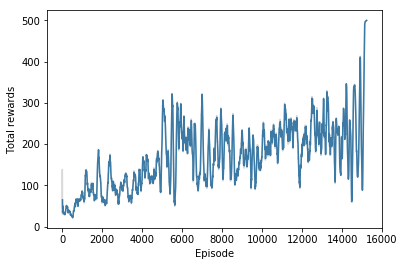

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

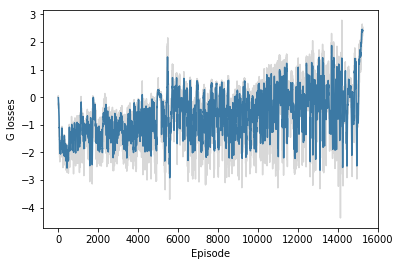

In [30]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

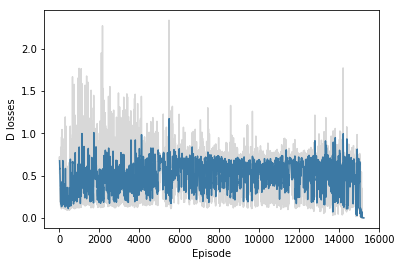

In [31]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses R')

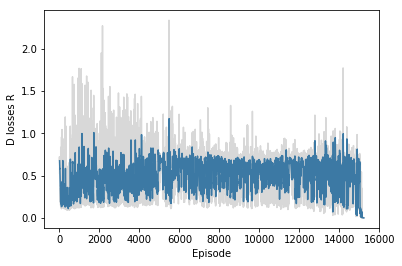

In [32]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

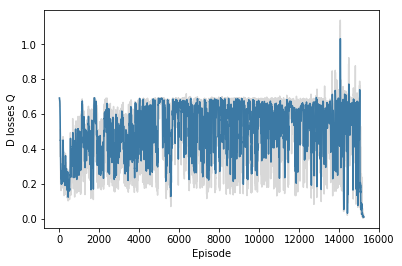

In [34]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [35]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
    # if total_reward == 500:
    #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model2.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.